In [610]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import struct
import warnings

from typing import Tuple, Literal, Optional, List, Dict
# Importation des modules nécessaires de scikit-learn
from scipy.stats import entropy
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cityblock


from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, average_precision_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

from sklearn.base import clone
from sklearn.base import ClassifierMixin

# Classificateurs de scikit-learn
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)
from sklearn.linear_model import (
    LogisticRegression,
    RidgeClassifier,
    ElasticNetCV
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier,NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE


# LightGBM
import lightgbm

# Configuration du logging
import logging
# Ignorer les warnings
warnings.filterwarnings("ignore")


In [611]:
# Supprimer tous les handlers existants
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Configurer le logger avec un format sans date/heure/niveau
logging.basicConfig(format='%(message)s', level=logging.INFO)

In [612]:
def calculate_pr_auc(y_true, y_prob):
    """
    Calcule et retourne le PR AUC pour une série de valeurs réelles et prédites.
    
    Args:
        y_true (array-like): Les valeurs réelles des classes (0 ou 1).
        y_prob (array-like): Les probabilités prédites des classes positives (entre 0 et 1).
    
    Returns:
        float: La valeur du PR AUC.
    """
    # Vérifier que y_true et y_prob sont compatibles
    if len(y_true) != len(y_prob):
        raise ValueError("La taille de y_true et y_prob doit être la même.")
    
    # Calcul de la courbe Precision-Recall
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)

    return pr_auc

In [613]:
def split_dataset(X, y, labeled_ratio, test_ratio):
    """
    Divise un dataset en train, test et pool en garantissant que chaque classe soit présente dans le set d'entraînement.
    """
    # Séparer l’ensemble de test
    X_train_pool, X_test, y_train_pool, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=42, stratify=y
    )

    # Taille totale de l’ensemble train + pool
    train_pool_size = X_train_pool.shape[0]

    # Nombre d'échantillons à labelliser
    nb_labeled = int(labeled_ratio * train_pool_size)

    # Diviser train_pool en labeled et pool
    X_train, X_pool, y_train, y_pool = train_test_split(
        X_train_pool, y_train_pool, train_size=nb_labeled, random_state=42, stratify=y_train_pool
    )

    return X_train, X_pool, y_train, y_pool, X_test, y_test

In [ ]:
def split_dataset_biased(X, y, labeled_ratio, test_ratio):
    """
    Divise un dataset en train, test et pool en garantissant que :
    - Le set de test est d'abord séparé.
    - Le train initial ne contient que les échantillons où X[:, 106] == 1.
    - On respecte les proportions demandées.
    """

    # Étape 1 : Séparation du test dès le début
    X_train_pool, X_test, y_train_pool, y_test = train_test_split(
        X, y, test_size=test_ratio, random_state=42, stratify=y
    )

    # Taille totale après suppression du test
    train_pool_size = X_train_pool.shape[0]
    
    # Nombre d'échantillons à mettre dans train (en % de train+pool)
    nb_labeled = int(labeled_ratio * train_pool_size)

    # Étape 2 : Sélection des échantillons biaisés pour le train
    mask = X_train_pool[:, 106] == 1  # On filtre sur la feature 106
    X_biased = X_train_pool[mask]
    y_biased = y_train_pool[mask]
    print(f"X_biased[106]{np.unique(X_biased[:,106],return_counts=True)}")
    print(f"y_biased{np.unique(y_biased,return_counts=True)}")
    print(f"shape de y_biased {y_biased.shape}")
    # Vérifier si assez d'exemples biaisés existent
    nb_labeled = min(nb_labeled, X_biased.shape[0])  # Ne pas dépasser ce qui est disponible
    print(f"nb_labeled{nb_labeled}")
    # Prendre les nb_labeled premiers éléments de la sélection biaisée
    X_train, y_train = X_biased[:nb_labeled], y_biased[:nb_labeled]

    # Étape 3 : Constituer le pool avec le reste des données non sélectionnées
    mask_remaining = np.ones(train_pool_size, dtype=bool)  # Tout est True au départ
    mask_remaining[np.where(mask)[0][:nb_labeled]] = False  # On enlève les éléments du train

    X_pool, y_pool = X_train_pool[mask_remaining], y_train_pool[mask_remaining]
    print(np.unique(y_train,return_counts=True))
    return X_train, X_pool, y_train, y_pool, X_test, y_test


In [615]:
def calculate_uncertainty(probabilities: np.ndarray, method: Literal["entropy", "margin", "least_confident", "random"] = "entropy") -> np.ndarray:
    """
    Calcule l'incertitude des prédictions basées sur les probabilités de classe.
    
    Paramètres :
        probabilities (np.ndarray) : Matrice des probabilités de classe pour chaque échantillon, de forme (n_samples, n_classes).
        method (str, optionnel) : Méthode d'incertitude à utiliser. Les options sont :
            - "entropy" : Entropie de Shannon.
            - "margin" : Différence entre les deux plus grandes probabilités.
            - "least_confident" : Complément de la plus grande probabilité.
            - "random" : Valeur aléatoire entre 0 et 1 pour chaque échantillon.
        
    Retourne :
        np.ndarray : Un tableau d'incertitude de forme (n_samples,) avec les scores d'incertitude pour chaque échantillon.
        
    Lève :
        ValueError : Si la méthode d'incertitude spécifiée n'est pas reconnue.
    """
    
    # Calcul de l'incertitude en fonction de la méthode choisie
    if method == "entropy":
        # Entropie de Shannon
        return entropy(probabilities.T, base=2)  # Probabilités doivent être de forme (n_classes, n_samples)
    
    elif method == "margin":
    # Si vous avez seulement deux classes
        if probabilities.shape[1] == 1:
            # Cas où la probabilité de chaque classe est un seul vecteur (probabilité = 1 pour une classe)
            return np.zeros(probabilities.shape[0])  # Pas de marge, car on est complètement confiant (différence = 0)
    
        elif probabilities.shape[1] == 2:
            # Cas classique avec deux classes
            prob_class_1 = probabilities[:, 0]
            prob_class_2 = probabilities[:, 1]
            return np.abs(prob_class_1 - prob_class_2)
    
        else:
            # Cas avec plus de deux classes, utiliser la marge entre les deux plus grandes probabilités
            sorted_probs = np.sort(probabilities, axis=1)
            return sorted_probs[:, -1] - sorted_probs[:, -2]

    
    elif method == "least_confident":
        # Complément de la probabilité la plus élevée (1 - max(probabilities))
        return 1 - np.max(probabilities, axis=1)
    
    elif method == "random":
        # Valeurs aléatoires entre 0 et 1
        return np.random.rand(probabilities.shape[0])
    
    else:
        # Si une méthode d'incertitude non reconnue est fournie, lever une exception
        raise ValueError("Méthode d'incertitude non reconnue")

In [616]:
def train_and_evaluate(X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, model_class: type[ClassifierMixin],metric) -> tuple:
    """
    Entraîne un modèle sur un ensemble d'entraînement et évalue sa performance sur un ensemble de test.
    
    Paramètres :
        X_train (np.ndarray) : Les caractéristiques d'entraînement, de forme (n_samples, n_features).
        y_train (np.ndarray) : Les étiquettes d'entraînement, de forme (n_samples,).
        X_test (np.ndarray) : Les caractéristiques de test, de forme (n_samples, n_features).
        y_test (np.ndarray) : Les étiquettes de test, de forme (n_samples,).
        model_class (type) : La classe du modèle de classification (doit être un sous-type de `ClassifierMixin`, par exemple `RandomForestClassifier`).

    Retourne :
        tuple : Un tuple contenant :
            - Le modèle entraîné (`model`).
            - La précision sur l'ensemble de test (`accuracy`).
    """
    # Initialisation du modèle
    model = model_class()
    
    # Entraînement du modèle
    model.fit(X_train, y_train)
    
    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)
    
    # Si la métrique est F1, calculer F1-score
    if metric == f1_score:
        result = metric(y_test, y_pred, average="macro")
    
    # Si la métrique est "PR AUC", calculer PR AUC
    elif metric == "PR AUC":
        y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive
        result = calculate_pr_auc(y_test, y_pred_prob)
    
    # Autres métriques
    else:
        result = metric(y_test, y_pred)
    
    return model, result

In [617]:
def select_uncertain_samples(model: ClassifierMixin, X_pool: np.ndarray, method: str, batch_size: int) -> np.ndarray:
    """
    Sélectionne les échantillons les plus incertains dans un ensemble de données non labellisées, en fonction de la méthode d'incertitude choisie.
    
    Paramètres :
        model (ClassifierMixin) : Le modèle d'apprentissage supervisé entraîné, avec une méthode `predict_proba` (par exemple, un classifieur comme `RandomForestClassifier` ou `SVC`).
        X_pool (np.ndarray) : Le tableau des caractéristiques des échantillons non labellisés, de forme (n_samples, n_features).
        method (str) : La méthode d'incertitude à utiliser pour calculer l'incertitude. Les options disponibles sont :
            - "entropy"
            - "margin"
            - "least_confident"
            - "random"
        batch_size (int) : Le nombre d'échantillons à sélectionner en fonction de l'incertitude.

    Retourne :
        np.ndarray : Un tableau des indices des `batch_size` échantillons les plus incertains dans `X_pool`.
    """
    # Probabilités prédites pour chaque échantillon
    probabilities = model.predict_proba(X_pool)
    
    # Calcul des incertitudes en fonction de la méthode choisie
    uncertainties = calculate_uncertainty(probabilities, method=method)
    
    # Sélection des indices des échantillons les plus incertains
    if method == "margin":
        # La méthode "margin" prend les échantillons ayant les plus petites marges entre les deux classes les plus probables
        return np.argsort(uncertainties)[:batch_size]
    else:
        # Pour les autres méthodes, on prend les échantillons ayant les incertitudes les plus élevées
        return np.argsort(uncertainties)[-batch_size:]

In [618]:
def update_labeled_unlabeled_sets(X_train: np.ndarray, y_train: np.ndarray, X_pool: np.ndarray, y_pool: np.ndarray, uncertain_indices: np.ndarray) -> tuple:
    """
    Met à jour les ensembles d'échantillons labellisés et non-labellisés après sélection des échantillons incertains.
    
    Paramètres :
        X_train (np.ndarray) : Ensemble des caractéristiques des échantillons labellisés (de taille (n_labeled_samples, n_features)).
        y_train (np.ndarray) : Ensemble des labels des échantillons labellisés (de taille (n_labeled_samples,)).
        X_pool (np.ndarray) : Ensemble des caractéristiques des échantillons non labellisés (de taille (n_pool_samples, n_features)).
        y_pool (np.ndarray) : Ensemble des labels des échantillons non labellisés (de taille (n_pool_samples,)).
        uncertain_indices (np.ndarray) : Indices des échantillons les plus incertains dans `X_pool`, qui doivent être ajoutés à `X_train` (de taille (batch_size,)).

    Retourne :
        tuple : 
            - X_train (np.ndarray) : Ensemble mis à jour des caractéristiques des échantillons labellisés.
            - y_train (np.ndarray) : Ensemble mis à jour des labels des échantillons labellisés.
            - X_pool (np.ndarray) : Ensemble mis à jour des caractéristiques des échantillons non labellisés.
            - y_pool (np.ndarray) : Ensemble mis à jour des labels des échantillons non labellisés.
    """
    # Ajout des échantillons incertains à l'ensemble des échantillons labellisés
    X_train = np.vstack((X_train, X_pool[uncertain_indices]))  # Empile les échantillons incertains sur l'ensemble de train
    y_train = np.hstack((y_train, y_pool[uncertain_indices]))  # Ajoute les labels des échantillons incertains

    # Création d'un masque pour supprimer les échantillons incertains de l'ensemble non-labellisé
    mask = np.ones(len(X_pool), dtype=bool)  # Crée un masque de True pour tous les échantillons non labellisés
    mask[uncertain_indices] = False  # Marque les indices incertains comme False dans le masque
    
    # Mise à jour de l'ensemble non-labellisé en excluant les échantillons incertains
    X_pool = X_pool[mask]  # Ne garde que les échantillons non incertains
    y_pool = y_pool[mask]  # Ne garde que les labels des échantillons non incertains

    return X_train, y_train, X_pool, y_pool

In [619]:
def hybrid_uncertainty(model, X_pool: np.ndarray, w1: float = 0.33, w2: float = 0.33, w3: float = 0.34) -> np.ndarray:
    """
    Combine plusieurs mesures d'incertitude (confiance minimale, marge et entropie) en une seule mesure pondérée.
    
    Args:
        model (sklearn.base.BaseEstimator): Le modèle de classification entraîné.
        X_pool (np.ndarray): Les échantillons non labellisés (de taille (n_pool_samples, n_features)).
        w1 (float, optional): Poids de la mesure "least confident" (par défaut 0.33).
        w2 (float, optional): Poids de la mesure "margin" (par défaut 0.33).
        w3 (float, optional): Poids de la mesure "entropy" (par défaut 0.34).
    
    Returns:
        np.ndarray: Un tableau des scores d'incertitude combinés (de taille (n_pool_samples,)).
    """
    # Prédictions des probabilités pour chaque classe
    proba = model.predict_proba(X_pool)
    
    # Mesure d'incertitude "Least Confident" : 1 - probabilité maximale
    least_confident = 1 - np.max(proba, axis=1)
    
    # Mesure "Margin" : différence entre les deux plus grandes probabilités
    if proba.shape[1] == 1:
        # Si on a qu'une seule classe (par exemple, probabilité = 1 pour une seule classe), on ne peut pas calculer une marge
        margin = np.zeros(proba.shape[0])  # Pas de marge dans ce cas
    else:
        sorted_proba = np.sort(proba, axis=1)
        margin = sorted_proba[:, -1] - sorted_proba[:, -2]
    
    # Entropie des probabilités : mesure de l'incertitude globale
    epsilon = 1e-10  # Ajout d'un petit epsilon pour éviter log(0)
    entropy = -np.sum(proba * np.log(proba + epsilon), axis=1)
    
    # Combinaison des scores d'incertitude avec les poids
    combined_score = w1 * least_confident + w2 * (1 - margin) + w3 * entropy
    
    return combined_score


In [620]:
def select_uncertain_samples_hybrid(model, X_pool: np.ndarray, batch_size: int) -> np.ndarray:
    """
    Sélectionne les échantillons les plus incertains selon la stratégie hybride en combinant 
    plusieurs mesures d'incertitude.
    
    Args:
        model (sklearn.base.BaseEstimator): Le modèle de classification entraîné.
        X_pool (np.ndarray): Les échantillons non labellisés (de taille (n_pool_samples, n_features)).
        batch_size (int): Nombre d'échantillons à sélectionner pour chaque itération.
    
    Returns:
        np.ndarray: Indices des échantillons les plus incertains dans X_pool (de taille (batch_size,)).
    """
    # Calcul des scores d'incertitude combinés (stratégie hybride)
    scores = hybrid_uncertainty(model, X_pool)
    
    # Sélectionner les indices des échantillons les plus incertains
    return np.argsort(scores)[-batch_size:]  # Retourne les indices des scores d'incertitude les plus élevés

In [621]:
def select_uncertain_samples_qbc(method: str, models: list, X_train: np.ndarray, y_train: np.ndarray, 
                                 X_pool: np.ndarray, batch_size: int) -> np.ndarray:
    """
    Sélectionne les échantillons les plus incertains en utilisant le Query by Committee (QBC).
    
    Le QBC évalue l'incertitude des échantillons dans l'ensemble non-labellisé en comparant les 
    prédictions des modèles d'un comité. Trois méthodes sont supportées :
    - "qbc-variance" : variance des prédictions des modèles sur chaque échantillon.
    - "qbc-entropy" : entropie des votes du comité.
    - "qbc-KL" : divergence Kullback-Leibler entre les prédictions des modèles et la probabilité moyenne.
    
    Args:
        method (str): Méthode d'incertitude à utiliser. Une des options suivantes :
                      - "qbc-variance"
                      - "qbc-entropy"
                      - "qbc-KL"
        models (list): Liste des modèles (du comité), chacun devant avoir la méthode `predict_proba`.
        X_train (np.ndarray): Ensemble de données d'entraînement labellisées (n_samples, n_features).
        y_train (np.ndarray): Labels des données d'entraînement (n_samples,).
        X_pool (np.ndarray): Données non-labellisées (n_pool_samples, n_features).
        batch_size (int): Nombre d'échantillons à sélectionner dans chaque itération.
    
    Returns:
        np.ndarray: Indices des échantillons les plus incertains dans `X_pool` (taille = batch_size).
    """
    # Entraîner chaque modèle du comité sur les données labellisées
    for model in models:
        model.fit(X_train, y_train)

    # Obtenir les prédictions de chaque modèle sur le pool de données non labellisées
    predictions = np.array([model.predict_proba(X_pool) for model in models])  # Shape: (n_models, n_samples, n_classes)

    # Initialiser l'incertitude
    uncertainty = None

    if method == "qbc-variance":
        # Calcul de la variance des prédictions pour chaque échantillon
        uncertainty = np.var(predictions, axis=0)  # Variance des probabilités
        uncertainty = np.mean(uncertainty, axis=1)  # Moyenne de la variance sur les classes

    elif method == "qbc-entropy":
        # Comptage des votes pour chaque classe
        n_models, n_samples, n_classes = predictions.shape
        vote_counts = np.zeros((n_samples, n_classes))

        for i in range(n_samples):
            for j in range(n_models):
                # Trouver la classe prédite par chaque modèle
                predicted_class = np.argmax(predictions[j, i, :])
                vote_counts[i, predicted_class] += 1

        # Calcul des probabilités de vote
        vote_probs = vote_counts / n_models

        # Calcul de l'entropie des votes pour chaque échantillon
        uncertainty = np.array([entropy(vote_probs[i, :], base=2) for i in range(n_samples)])

    elif method == "qbc-KL":
        # Calcul de la probabilité moyenne (P_avg) pour chaque échantillon
        P_avg = np.mean(predictions, axis=0)  # Moyenne des prédictions des modèles (n_samples, n_classes)

        # Calcul de la divergence Kullback-Leibler (KL) pour chaque échantillon
        n_samples, n_classes = P_avg.shape
        uncertainty = np.zeros(n_samples)

        for i in range(n_samples):
            for model_preds in predictions[:, i, :]:
                # Calcul de la divergence KL pour chaque échantillon
                uncertainty[i] += np.sum(model_preds * np.log(model_preds / P_avg[i, :]))

    else:
        raise ValueError("Méthode d'incertitude non reconnue. Choisissez parmi 'qbc-variance', 'qbc-entropy' ou 'qbc-KL'.")

    # Sélectionner les indices des échantillons ayant l'incertitude la plus élevée
    uncertain_indices = np.argsort(uncertainty)[-batch_size:]

    return uncertain_indices

In [622]:
#à terminer
def select_uncertain_samples_egl(model, X_pool: np.ndarray, batch_size: int) -> np.ndarray:
    """
    Sélectionne les échantillons les plus informatifs en utilisant la méthode EGL (Expected Gradient Length).
    
    Cette méthode sélectionne les échantillons qui entraîneraient la plus grande mise à jour du modèle
    en fonction de la norme du gradient de la fonction de coût par rapport à chaque échantillon.
    
    Args:
        model : Estimation du modèle de classification (doit être basé sur des gradients, ex : régression logistique).
        X_pool : Données non-labellisées pour lesquelles nous souhaitons calculer l'incertitude.
        batch_size : Nombre d'échantillons à sélectionner.
    
    Returns:
        np.ndarray : Indices des échantillons les plus incertains dans `X_pool`.
    """
    if not hasattr(model, "coef_"):
        raise ValueError("Le modèle doit être une régression logistique ou un autre modèle basé sur des gradients.")
    
    gradients = []
    
    # Obtenir les probabilités de prédiction
    probs = model.predict_proba(X_pool)  # Probabilités pour chaque classe (n_samples, n_classes)
    
    # Calculer l'incertitude pour chaque échantillon en utilisant la méthode EGL
    for i, x in enumerate(X_pool):
        expected_grad = 0
        
        for class_idx in range(probs.shape[1]):  # Parcourir chaque classe
            prob = probs[i, class_idx]
            
            # Créer un vecteur one-hot pour la classe cible
            y_dummy = np.zeros((1, probs.shape[1]))
            y_dummy[0, class_idx] = 1
            
            try:
                # Calcul du gradient pour cette classe en ajustant temporairement le modèle
                model.fit(x.reshape(1, -1), y_dummy.argmax(axis=1))  # Entraînement temporaire sur l'exemple (1, -1) pour l'ajustement de la forme
                grad = np.linalg.norm(model.coef_)  # Norme du gradient
                expected_grad += prob * grad  # Calcul de l'espérance du gradient
            except ValueError:
                # Si une erreur survient, on passe à la classe suivante
                continue
        
        gradients.append(expected_grad)
    
    # Sélection des indices des plus grandes valeurs de gradient
    uncertain_indices = np.argsort(gradients)[-batch_size:]
    
    return uncertain_indices


In [623]:
def compute_information_density(X_pool: np.ndarray, similarity_metric: str = 'cosine') -> np.ndarray:
    """
    Calcule la densité d'information pour chaque point du pool en fonction de la similarité avec les autres points.
    
    Args:
        X_pool (numpy.ndarray): Ensemble non labellisé de taille (n_samples, n_features).
        similarity_metric (str): Type de mesure de similarité ('cosine' ou 'euclidean').
    
    Returns:
        numpy.ndarray: Score de densité pour chaque instance.
    """
    # Calcul de la matrice de similarité en fonction de la métrique choisie
    if similarity_metric == 'cosine':
        similarity_matrix = cosine_similarity(X_pool)
    elif similarity_metric == 'euclidean':
        distance_matrix = np.linalg.norm(X_pool[:, np.newaxis] - X_pool, axis=2)
        similarity_matrix = 1 / (1 + distance_matrix)  # Conversion en similarité
    else:
        raise ValueError("Metric non supportée. Utilisez 'cosine' ou 'euclidean'.")
    
    # Calcul de la moyenne des similarités pour chaque point (densité)
    # Evite l'auto-similarité (similarité d'un point avec lui-même) en mettant la diagonale à zéro
    np.fill_diagonal(similarity_matrix, 0)
    
    density_scores = np.mean(similarity_matrix, axis=1)
    
    # Normalisation des scores de densité entre 0 et 1 (facultatif)
    density_scores /= np.max(density_scores)
    
    return density_scores

In [624]:
def select_uncertain_samples_density(model, X_pool: np.ndarray, batch_size: int, similarity_metric: str = 'cosine') -> list:
    """
    Sélectionne les échantillons en combinant incertitude et densité d'information.
    
    Args:
        model : Modèle de classification entraîné utilisé pour l'incertitude.
        X_pool : Ensemble non labellisé de taille (n_samples, n_features).
        batch_size : Nombre d'échantillons à sélectionner.
        similarity_metric : Type de mesure de similarité ('cosine' ou 'euclidean').
    
    Returns:
        list: Indices des échantillons sélectionnés.
    """
    # 1. Vérification de la méthode de calcul des probabilités pour l'incertitude
    if not hasattr(model, "predict_proba"):
        raise ValueError("Le modèle doit implémenter 'predict_proba' pour calculer l'incertitude.")
    
    probas = model.predict_proba(X_pool)
    # Calcul de l'incertitude (exemple : entropie prédictive)
    uncertainty = -np.sum(probas * np.log(probas + 1e-10), axis=1)  # Évite log(0)
    
    # 2. Calcul de la densité d'information
    density_scores = compute_information_density(X_pool, similarity_metric)
    
    # 3. Combinaison des scores : pondération entre incertitude et densité
    combined_scores = uncertainty * density_scores
    
    # 4. Sélection des indices des échantillons les plus incertains et informatifs
    selected_indices = np.argsort(combined_scores)[-batch_size:]
    
    return selected_indices.tolist()

In [625]:
def select_uncertain_samples_by_distance_density(method, model, X_pool, batch_size, models, X_train, y_train, similarity_metric='cityblock'):
    """
    Sélectionne les échantillons les plus éloignés des autres clusters, tout en tenant compte de la densité.
    
    Parameters:
    - method : méthode d'Active Learning (utile pour l'interface mais non utilisée dans cette méthode).
    - model : modèle de classification utilisé pour l'Active Learning.
    - X_pool : ensemble des données non labellisées.
    - batch_size : nombre d'échantillons à ajouter au training set.
    - models : liste de modèles pour les méthodes basées sur un comité (utile dans certains cas de AL).
    - X_train : ensemble d'entraînement labellisé.
    - y_train : labels de l'ensemble d'entraînement.
    - similarity_metric : critère de similarité pour calculer les distances (par défaut 'cosine').
    
    Returns:
    - indices des échantillons sélectionnés dans X_pool.
    """
    # Étape 1: Calculer les distances des points dans le pool par rapport aux points labellisés.
    nn = NearestNeighbors(n_neighbors=1, metric=similarity_metric)
    nn.fit(X_train)  # Apprendre les distances des points labellisés
    
    # Trouver la distance minimale pour chaque point dans le pool par rapport à l'ensemble labellisé
    distances, indices = nn.kneighbors(X_pool)
    
    # Étape 2: Calculer la densité des points du pool en utilisant le k-nearest neighbors (KNN)
    density_nn = NearestNeighbors(n_neighbors=5, metric=similarity_metric)  # Utilisation de 5 voisins pour estimer la densité
    density_nn.fit(X_pool)
    densities, _ = density_nn.kneighbors(X_pool)  # Obtient la distance des 5 voisins les plus proches
    densities = densities.mean(axis=1)  # Moyenne des distances des voisins, plus élevé = plus densément peuplé
    
    # Étape 3: Calculer une métrique combinée basée sur la distance et la densité
    # Les points éloignés des autres clusters et ayant une faible densité sont considérés comme plus incertains
    score = distances.flatten() / (densities + 1e-5)  # Pour éviter la division par zéro

    # Étape 4: Sélectionner les indices des points avec les scores les plus élevés (points éloignés et peu denses)
    uncertain_indices = np.argsort(score)[-batch_size:]  # Sélectionner les "batch_size" plus incertains
    
    return uncertain_indices

In [626]:
def select_uncertain_samples_general(method: str, model: object, X_pool: np.ndarray, batch_size: int, models: Optional[List[object]] = None, X_train: Optional[np.ndarray] = None, y_train: Optional[np.ndarray] = None, similarity_metric: str = 'cosine') -> np.ndarray:
    """
    Sélectionne les échantillons les plus incertains selon la méthode spécifiée.
    
    Args:
        method (str): Méthode de sélection. Doit être l'une des suivantes : 
            'qbc-variance', 'qbc-entropy', 'qbc-KL', 'hybrid', 'EGL', 'least_confident', 
            'margin', 'entropy', 'random', 'density'.
        model (object): Modèle de classification entraîné (ex. RandomForestClassifier, LogisticRegression, etc.).
        X_pool (numpy.ndarray): Ensemble non labellisé de taille (n_samples, n_features).
        batch_size (int): Nombre d'échantillons à sélectionner.
        models (list, optionnel): Liste de modèles pour la méthode QBC. Requis pour 'qbc-*'.
        X_train (numpy.ndarray, optionnel): Données d'entraînement labellisées. Requis pour QBC.
        y_train (numpy.ndarray, optionnel): Labels d'entraînement. Requis pour QBC.
        similarity_metric (str, optionnel): Métrique de similarité pour 'density'. Valeurs possibles : 'cosine', 'euclidean'.
    
    Returns:
        numpy.ndarray: Indices des échantillons les plus incertains sélectionnés.
    
    Raises:
        ValueError: Si la méthode est inconnue ou si les arguments nécessaires sont manquants.
    """
    
    # Vérification des arguments nécessaires pour certaines méthodes
    if method in ["qbc-variance", "qbc-entropy", "qbc-KL"]:
        if models is None or X_train is None or y_train is None:
            raise ValueError("Les méthodes QBC nécessitent un comité de modèles et des données d'entraînement labellisées.")
        return select_uncertain_samples_qbc(method, models, X_train, y_train, X_pool, batch_size)
    
    elif method == "hybrid":
        return select_uncertain_samples_hybrid(model, X_pool, batch_size)
    
    elif method == "EGL":
        return select_uncertain_samples_egl(model, X_pool, batch_size)
    
    elif method in ["least_confident", "margin", "entropy"]:
        return select_uncertain_samples(model, X_pool, method, batch_size)
    
    elif method == "random":
        # Sélection aléatoire d'échantillons sans remplacement
        return np.random.choice(len(X_pool), size=batch_size, replace=False)
    
    elif method == "density":
        return select_uncertain_samples_density(model, X_pool, batch_size, similarity_metric)
    elif method =="distance_density":
        return(select_uncertain_samples_by_distance_density(method, model, X_pool, batch_size, models, X_train, y_train, similarity_metric='cosine'))
    
    else:
        raise ValueError(f"Méthode de sélection non reconnue : {method}")


In [627]:
def plot_active_learning_results(dataset_name: str, methods: List[str], accuracies: Dict[str, Dict[str, List[float]]],
                                 labeled_ratio: float, batch_ratio: float, n_iterations: int, 
                                 full_training_accuracies: Dict[str, float], final_accuracies: Dict[str, Dict[str, float]], 
                                 initial_accuracies: Dict[str, float],metric) -> Dict[str, float]:
    """
    Génère et affiche les graphiques d'évolution de l'accuracy et d'amélioration de l'accuracy pour un dataset donné.
    
    Args:
        dataset_name (str): Nom du dataset.
        methods (list): Liste des méthodes utilisées.
        accuracies (dict): Dictionnaire des accuracies obtenues par méthode pour chaque dataset.
        labeled_ratio (float): Ratio initial de données labellisées.
        batch_ratio (float): Ratio de batch d'ajout de labels à chaque itération.
        n_iterations (int): Nombre total d'itérations.
        full_training_accuracies (dict): Accuracy du modèle entraîné sur tout le training set pour chaque dataset.
        final_accuracies (dict): Dictionnaire des accuracies finales obtenues par chaque méthode après toutes les itérations.
        initial_accuracies (dict): Dictionnaire des accuracies initiales avant le processus d'Active Learning.
    
    Returns:
        dict: Dictionnaire des améliorations d'accuracy pour chaque méthode.
    """
    
    # === Courbe d'évolution de l'accuracy ===
    fig = px.line(title=f"Évolution de l'{metric.__name__ if hasattr(metric, '__name__') else str(metric)} sur {dataset_name}")
    
    
    # Tracer l'évolution de l'accuracy pour chaque méthode
    for method in methods:
        # Ajout de l'accuracy initiale avant la première itération
        x_values = [(labeled_ratio + i * batch_ratio) * 100 for i in range(n_iterations + 1)]
        y_values = [initial_accuracies[dataset_name]] + accuracies[dataset_name][method]
        
        fig.add_scatter(x=x_values, y=y_values, mode='lines+markers', name=method)
    
    # Ajouter la performance du modèle entraîné sur tout le training set
    fig.add_scatter(
        x=[labeled_ratio * 100, (labeled_ratio + (n_iterations+1) * batch_ratio) * 100],
        y=[full_training_accuracies[dataset_name]] * 2,
        mode='lines', name="Full Training Set", line=dict(dash='dash')
    )
    
    # Mise en forme du graphique : axes et légende
    fig.update_layout(
        xaxis_title="% du training set labellisé",
        yaxis_title="Accuracy",
        xaxis=dict(range=[labeled_ratio * 100, (labeled_ratio + n_iterations * batch_ratio) * 100]),
        yaxis=dict(range=[min(min(accuracies[dataset_name][m]) for m in methods) - 0.02, 
                          max(full_training_accuracies[dataset_name], 
                              max(final_accuracies[dataset_name].values())) + 0.02])
    )
    fig.show()
    
    # === Barres d'amélioration de l'accuracy ===
    # Calculer l'amélioration de l'accuracy pour chaque méthode
    accuracy_improvements = {
        method: final_accuracies[dataset_name][method] - initial_accuracies[dataset_name] 
        for method in methods
    }
    
    # Tracer un graphique en barres montrant l'amélioration de l'accuracy
    fig = px.bar(
        x=methods, 
        y=[accuracy_improvements[m] for m in methods],
        labels={"x": "Méthode", "y": f"Amélioration de l'{metric.__name__ if hasattr(metric, '__name__') else str(metric)}"},
        title=f"Amélioration de l'{metric.__name__ if hasattr(metric, '__name__') else str(metric)} sur {dataset_name}"
    )

    
    # Ajuster les limites de l'axe des y pour un meilleur affichage
    fig.update_layout(
        yaxis=dict(range=[min(accuracy_improvements.values()) - 0.01, 
                          max(accuracy_improvements.values()) + 0.01])
    )
    fig.show()
    
    return accuracy_improvements


In [628]:
def run_active_learning_experiment_datasets(datasets: dict, METRICS: dict,labeled_ratio: float, test_ratio: float, 
                                            n_iterations: int, batch_ratio: float, methods: list, 
                                            model_class: type, models: list) -> dict:
    """
    Exécute une expérimentation d'Active Learning sur plusieurs datasets avec différentes méthodes de sélection d'incertitude.
    
    Paramètres:
        datasets (dict): Un dictionnaire contenant les datasets sous la forme {nom_dataset: (X, y)},
                         où X est un np.ndarray (features) et y est un np.ndarray (labels).
        labeled_ratio (float): Proportion initiale d'échantillons labellisés dans l'ensemble d'entraînement.
        test_ratio (float): Proportion d'échantillons dédiés à l'ensemble de test.
        n_iterations (int): Nombre d'itérations d'Active Learning.
        batch_ratio (float): Proportion d'échantillons ajoutés à chaque itération (par rapport à la taille totale du training dataset).
        methods (list): Liste des méthodes de sélection d'incertitude à tester.
        model_class (type): Classe du modèle de classification utilisé (doit être compatible avec `fit` et `predict`).
        models (list): Liste des modèles pour les méthodes basées sur un comité (ex: Query By Committee).

    Retourne:
        dict: Un dictionnaire contenant les précisions finales pour chaque dataset et chaque méthode d'Active Learning.
    """
    
    # Initialisation des dictionnaires pour stocker les résultats
    results= {dataset_name: {method: [] for method in methods} for dataset_name in datasets.keys()}
    final_results = {dataset_name: {} for dataset_name in datasets.keys()}
    initial_results = {}
    full_training_results = {}
    
    for dataset_name, (X, y) in datasets.items():
        metric=METRICS[dataset_name]
        logging.info(f"\nTraitement du dataset: {dataset_name}")
        logging.info(f"\nMétrique utilisée: {metric.__name__ if hasattr(metric, '__name__') else str(metric)}")
        # Création des ensembles d'entraînement et de test
        X_train, X_pool, y_train, y_pool, X_test, y_test = split_dataset(X, y, labeled_ratio, test_ratio)
        batch_size = int(batch_ratio * (X_train.shape[0]+X_pool.shape[0]))
        
        total_samples = X.shape[0]
        labeled_percentage = (X_train.shape[0] /(X_train.shape[0]+X_pool.shape[0])) * 100
        unlabeled_percentage = (X_pool.shape[0] / (X_train.shape[0]+X_pool.shape[0])) * 100
        test_percentage = (X_test.shape[0] / total_samples) * 100

        # Affichage des tailles des ensembles
        total_samples = X.shape[0]
        logging.info(f"Taille totale du dataset {dataset_name}: {total_samples/total_samples*100:.2f}% ({total_samples}/{total_samples})")
        logging.info(f"Taille de l'ensemble de test: {test_percentage:.2f}% ({X_test.shape[0]}/{total_samples})")
        logging.info(f"Taille de l'ensemble de training: {100-test_percentage:.2f}% ({X_train.shape[0]+X_pool.shape[0]}/{total_samples})")     
        logging.info(f"Taille de l'ensemble labellisé dans le training set: {labeled_percentage:.2f}% ({X_train.shape[0]}/{X_train.shape[0]+X_pool.shape[0]})")
        logging.info(f"Taille de l'ensemble non-labellisé dans le training set: {unlabeled_percentage:.2f}% ({X_pool.shape[0]}/{X_train.shape[0]+X_pool.shape[0]})")
        logging.info(f"Nb d'itérations: {n_iterations}")
        logging.info(f"Nb de données labellisées en plus à chaque itération: {batch_size/(X_train.shape[0]+X_pool.shape[0])*100:.2f}% ({batch_size}/{X_train.shape[0]+X_pool.shape[0]})")
        
        # Évaluation initiale
        model = model_class()
        y_pred_initial = model.fit(X_train, y_train).predict(X_test)
        if metric == "PR AUC":
            print("Classes présentes dans y_train:", np.unique(y_train, return_counts=True))
            probas = model.predict_proba(X_test)
            print("Shape de predict_proba:", probas.shape)

            y_pred_prob_initial = model.predict_proba(X_test)[:, 1]
            initial_results[dataset_name] = calculate_pr_auc(y_test, y_pred_prob_initial)
        else:
            initial_results[dataset_name] = (
                metric(y_test, y_pred_initial, average="macro") if metric == f1_score else metric(y_test, y_pred_initial)
            )
        

        # Modèle entraîné sur l'ensemble complet des données d'entraînement
        model_full = model_class()
        model_full.fit(np.vstack((X_train, X_pool)), np.hstack((y_train, y_pool)))
        if metric == "PR AUC":
            y_pred_prob_full = model_full.predict_proba(X_test)[:, 1]
            full_training_results[dataset_name] = calculate_pr_auc(y_test, y_pred_prob_full)
        else:
            full_training_results[dataset_name] = (
                metric(y_test, model_full.predict(X_test), average="macro") if metric == f1_score else metric(y_test, model_full.predict(X_test))
            )

        # === Boucle principale d'Active Learning ===
        for method in methods:
            X_train_temp, y_train_temp = X_train.copy(), y_train.copy()
            X_pool_temp, y_pool_temp = X_pool.copy(), y_pool.copy()
            results[dataset_name][method].append(initial_results[dataset_name])
            for i in range(n_iterations):
                # Entraînement et évaluation du modèle
                model, acc = train_and_evaluate(X_train_temp, y_train_temp, X_test, y_test, model_class,metric)
                results[dataset_name][method].append(acc)
                
                # Vérification de l'existence d'échantillons non labellisés
                if len(X_pool_temp) == 0:
                    logging.info(f"\nToutes les données ont été labellisées après {i} itérations.")
                    break
                
                # Ajustement de la taille du batch si nécessaire
                actual_batch_size = min(batch_size, len(X_pool_temp))
                if actual_batch_size < batch_size:
                    logging.info(f"\nBatch réduit à {actual_batch_size} échantillons car la pool est presque vide.")
                
                # Sélection des échantillons les plus incertains
                uncertain_indices = select_uncertain_samples_general(method, model, X_pool_temp, actual_batch_size, models, X_train_temp, y_train_temp, similarity_metric='cosine')
                
                # Mise à jour des ensembles labellisés et non-labellisés
                X_train_temp, y_train_temp, X_pool_temp, y_pool_temp = update_labeled_unlabeled_sets(
                    X_train_temp, y_train_temp, X_pool_temp, y_pool_temp, uncertain_indices
                )
                
                logging.info(f"{method} - Iteration {i+1}: {len(X_train_temp)/(X_train.shape[0]+X_pool.shape[0])*100:.2f}% ({len(X_train_temp)}/{(X_train.shape[0]+X_pool.shape[0])}) samples labeled, {metric.__name__ if hasattr(metric, '__name__') else str(metric)}: {acc:.4f} on {dataset_name}")
            
            # Final evaluation after Active Learning
            if metric == "PR AUC":
                y_pred_prob_final = model.predict_proba(X_test)[:, 1]
                pr_auc = calculate_pr_auc(y_test, y_pred_prob_final)
                final_results[dataset_name][method] = pr_auc
                logging.info(f"Final PR AUC ({method}) on {dataset_name}: {pr_auc:.4f}")
            else:
                final_results[dataset_name][method] = (
                    metric(y_test, model.predict(X_test), average="macro") if metric == f1_score else metric(y_test, model.predict(X_test))
                )
                logging.info(f"Final {metric.__name__ if hasattr(metric, '__name__') else str(metric)} ({method}) on {dataset_name}: {final_results[dataset_name][method]:.4f}")        
        #Génération des graphiques et affichage des résultats
        #result_improvements = plot_active_learning_results(dataset_name, methods, results, labeled_ratio, batch_ratio,i+1, full_training_results, final_results, initial_results,metric)
        
        logging.info(f"Initial {metric.__name__ if hasattr(metric, '__name__') else str(metric)} on {dataset_name}: {initial_results[dataset_name]:.4f}")
        logging.info(f"Full Training Set {metric.__name__ if hasattr(metric, '__name__') else str(metric)} on {dataset_name}: {full_training_results[dataset_name]:.4f}")

        #for method in methods:
           #logging.info(f"{metric.__name__ if hasattr(metric, '__name__') else str(metric)} Improvement ({method}) on {dataset_name}: {result_improvements[method]:.4f}")
    
    return results

In [629]:
def run_active_learning_experiment_datasets_biased(datasets: dict, METRICS: dict,labeled_ratio: float, test_ratio: float, 
                                            n_iterations: int, batch_ratio: float, methods: list, 
                                            model_class: type, models: list) -> dict:
    """
    Exécute une expérimentation d'Active Learning sur plusieurs datasets avec différentes méthodes de sélection d'incertitude.
    
    Paramètres:
        datasets (dict): Un dictionnaire contenant les datasets sous la forme {nom_dataset: (X, y)},
                         où X est un np.ndarray (features) et y est un np.ndarray (labels).
        labeled_ratio (float): Proportion initiale d'échantillons labellisés dans l'ensemble d'entraînement.
        test_ratio (float): Proportion d'échantillons dédiés à l'ensemble de test.
        n_iterations (int): Nombre d'itérations d'Active Learning.
        batch_ratio (float): Proportion d'échantillons ajoutés à chaque itération (par rapport à la taille totale du training dataset).
        methods (list): Liste des méthodes de sélection d'incertitude à tester.
        model_class (type): Classe du modèle de classification utilisé (doit être compatible avec `fit` et `predict`).
        models (list): Liste des modèles pour les méthodes basées sur un comité (ex: Query By Committee).

    Retourne:
        dict: Un dictionnaire contenant les précisions finales pour chaque dataset et chaque méthode d'Active Learning.
    """
    
    # Initialisation des dictionnaires pour stocker les résultats
    results= {dataset_name: {method: [] for method in methods} for dataset_name in datasets.keys()}
    final_results = {dataset_name: {} for dataset_name in datasets.keys()}
    initial_results = {}
    full_training_results = {}
    
    for dataset_name, (X, y) in datasets.items():
        metric=METRICS[dataset_name]
        logging.info(f"\nTraitement du dataset: {dataset_name}")
        logging.info(f"\nMétrique utilisée: {metric.__name__ if hasattr(metric, '__name__') else str(metric)}")
        # Création des ensembles d'entraînement et de test
        X_train, X_pool, y_train, y_pool, X_test, y_test = split_dataset_biased(X, y, labeled_ratio, test_ratio)
        batch_size = int(batch_ratio * (X_train.shape[0]+X_pool.shape[0]))
        
        total_samples = X.shape[0]
        labeled_percentage = (X_train.shape[0] /(X_train.shape[0]+X_pool.shape[0])) * 100
        unlabeled_percentage = (X_pool.shape[0] / (X_train.shape[0]+X_pool.shape[0])) * 100
        test_percentage = (X_test.shape[0] / total_samples) * 100

        # Affichage des tailles des ensembles
        total_samples = X.shape[0]
        logging.info(f"Taille totale du dataset {dataset_name}: {total_samples/total_samples*100:.2f}% ({total_samples}/{total_samples})")
        logging.info(f"Taille de l'ensemble de test: {test_percentage:.2f}% ({X_test.shape[0]}/{total_samples})")
        logging.info(f"Taille de l'ensemble de training: {100-test_percentage:.2f}% ({X_train.shape[0]+X_pool.shape[0]}/{total_samples})")     
        logging.info(f"Taille de l'ensemble labellisé dans le training set: {labeled_percentage:.2f}% ({X_train.shape[0]}/{X_train.shape[0]+X_pool.shape[0]})")
        logging.info(f"Taille de l'ensemble non-labellisé dans le training set: {unlabeled_percentage:.2f}% ({X_pool.shape[0]}/{X_train.shape[0]+X_pool.shape[0]})")
        logging.info(f"Nb d'itérations: {n_iterations}")
        logging.info(f"Nb de données labellisées en plus à chaque itération: {batch_size/(X_train.shape[0]+X_pool.shape[0])*100:.2f}% ({batch_size}/{X_train.shape[0]+X_pool.shape[0]})")
        print("Classes présentes dans xtrain 106:", np.unique(X_train[:,106], return_counts=True))
        # Évaluation initiale
        model = model_class()
        y_pred_initial = model.fit(X_train, y_train).predict(X_test)
        if metric == "PR AUC":
            print("Classes présentes dans y_train:", np.unique(y_train, return_counts=True))
            probas = model.predict_proba(X_test)
            print("Shape de predict_proba:", probas.shape)

            y_pred_prob_initial = model.predict_proba(X_test)[:, 1]
            initial_results[dataset_name] = calculate_pr_auc(y_test, y_pred_prob_initial)
        else:
            initial_results[dataset_name] = (
                metric(y_test, y_pred_initial, average="macro") if metric == f1_score else metric(y_test, y_pred_initial)
            )
        

        # Modèle entraîné sur l'ensemble complet des données d'entraînement
        model_full = model_class()
        model_full.fit(np.vstack((X_train, X_pool)), np.hstack((y_train, y_pool)))
        if metric == "PR AUC":
            y_pred_prob_full = model_full.predict_proba(X_test)[:, 1]
            full_training_results[dataset_name] = calculate_pr_auc(y_test, y_pred_prob_full)
        else:
            full_training_results[dataset_name] = (
                metric(y_test, model_full.predict(X_test), average="macro") if metric == f1_score else metric(y_test, model_full.predict(X_test))
            )

        # === Boucle principale d'Active Learning ===
        for method in methods:
            X_train_temp, y_train_temp = X_train.copy(), y_train.copy()
            X_pool_temp, y_pool_temp = X_pool.copy(), y_pool.copy()
            results[dataset_name][method].append(initial_results[dataset_name])
            for i in range(n_iterations):
                # Entraînement et évaluation du modèle
                model, acc = train_and_evaluate(X_train_temp, y_train_temp, X_test, y_test, model_class,metric)
                results[dataset_name][method].append(acc)
                
                # Vérification de l'existence d'échantillons non labellisés
                if len(X_pool_temp) == 0:
                    logging.info(f"\nToutes les données ont été labellisées après {i} itérations.")
                    break
                
                # Ajustement de la taille du batch si nécessaire
                actual_batch_size = min(batch_size, len(X_pool_temp))
                if actual_batch_size < batch_size:
                    logging.info(f"\nBatch réduit à {actual_batch_size} échantillons car la pool est presque vide.")
                
                # Sélection des échantillons les plus incertains
                uncertain_indices = select_uncertain_samples_general(method, model, X_pool_temp, actual_batch_size, models, X_train_temp, y_train_temp, similarity_metric='cosine')
                
                # Mise à jour des ensembles labellisés et non-labellisés
                X_train_temp, y_train_temp, X_pool_temp, y_pool_temp = update_labeled_unlabeled_sets(
                    X_train_temp, y_train_temp, X_pool_temp, y_pool_temp, uncertain_indices
                )
                
                logging.info(f"{method} - Iteration {i+1}: {len(X_train_temp)/(X_train.shape[0]+X_pool.shape[0])*100:.2f}% ({len(X_train_temp)}/{(X_train.shape[0]+X_pool.shape[0])}) samples labeled, {metric.__name__ if hasattr(metric, '__name__') else str(metric)}: {acc:.4f} on {dataset_name}")
            
            # Final evaluation after Active Learning
            if metric == "PR AUC":
                y_pred_prob_final = model.predict_proba(X_test)[:, 1]
                pr_auc = calculate_pr_auc(y_test, y_pred_prob_final)
                final_results[dataset_name][method] = pr_auc
                logging.info(f"Final PR AUC ({method}) on {dataset_name}: {pr_auc:.4f}")
            else:
                final_results[dataset_name][method] = (
                    metric(y_test, model.predict(X_test), average="macro") if metric == f1_score else metric(y_test, model.predict(X_test))
                )
                logging.info(f"Final {metric.__name__ if hasattr(metric, '__name__') else str(metric)} ({method}) on {dataset_name}: {final_results[dataset_name][method]:.4f}")        
        #Génération des graphiques et affichage des résultats
        #result_improvements = plot_active_learning_results(dataset_name, methods, results, labeled_ratio, batch_ratio,i+1, full_training_results, final_results, initial_results,metric)
        
        logging.info(f"Initial {metric.__name__ if hasattr(metric, '__name__') else str(metric)} on {dataset_name}: {initial_results[dataset_name]:.4f}")
        logging.info(f"Full Training Set {metric.__name__ if hasattr(metric, '__name__') else str(metric)} on {dataset_name}: {full_training_results[dataset_name]:.4f}")

       # for method in methods:
           #logging.info(f"{metric.__name__ if hasattr(metric, '__name__') else str(metric)} Improvement ({method}) on {dataset_name}: {result_improvements[method]:.4f}")
    
    return results

Traitement MNIST

In [630]:
def read_images(filename: str) -> np.ndarray:
    """
    Lit les images à partir d'un fichier binaire au format MNIST.
    
    Args:
        filename (str): Le nom du fichier contenant les images.
        
    Returns:
        np.ndarray: Un tableau numpy de forme (nb_images, nb_rows, nb_cols) contenant les images lues.
    
    L'assertion `magic_number == 2051` vérifie que le fichier est bien au format attendu pour les images.
    """
    with open(filename, 'rb') as file:
        # Lire les 16 premiers octets pour obtenir les métadonnées
        magic_number, nb_images, nb_rows, nb_cols = struct.unpack('>IIII', file.read(16))
        
        # Vérification du magic_number (doit être 2051 pour les images MNIST)
        assert magic_number == 2051, "Wrong file format"
        
        # Lire les données d'images et les redimensionner en un tableau 3D (nb_images, nb_rows, nb_cols)
        image_data = np.fromfile(file, dtype=np.uint8).reshape(nb_images, nb_rows, nb_cols)
        
    return image_data

In [631]:
def read_targets(filename: str) -> np.ndarray:
    """
    Lit les cibles (labels) à partir d'un fichier binaire au format MNIST.
    
    Args:
        filename (str): Le nom du fichier contenant les cibles.
        
    Returns:
        np.ndarray: Un tableau numpy contenant les labels des images lues.
    
    L'assertion `magic_number == 2049` vérifie que le fichier est bien au format attendu pour les cibles.
    """
    with open(filename, 'rb') as file:
        # Lire les 8 premiers octets pour obtenir les métadonnées
        magic_number, nb_items = struct.unpack('>II', file.read(8))
        
        # Vérification du magic_number (doit être 2049 pour les cibles MNIST)
        assert magic_number == 2049, "Wrong file format"
        
        # Lire les labels
        targets = np.fromfile(file, dtype=np.uint8)
        
    return targets

In [632]:
path_images_file = '../t10k-images.idx3-ubyte'
path_to_targets = '../t10k-labels.idx1-ubyte'

X_MNIST= read_images(path_images_file).reshape(-1, 28*28)
y_MNIST = read_targets(path_to_targets)
unique_classes, class_counts = np.unique(y_MNIST, return_counts=True)

print(X_MNIST.shape)
for cls, count in zip(unique_classes, class_counts):
    print(f"Classe {cls}: {count} échantillons")

(10000, 784)
Classe 0: 980 échantillons
Classe 1: 1135 échantillons
Classe 2: 1032 échantillons
Classe 3: 1010 échantillons
Classe 4: 982 échantillons
Classe 5: 892 échantillons
Classe 6: 958 échantillons
Classe 7: 1028 échantillons
Classe 8: 974 échantillons
Classe 9: 1009 échantillons


Traitement PRS

In [633]:
color_values = {
    "Yellow": 2,
    "Brown": 2,
    "Red": 2,
    "Black": 2,
    "Grey": 2,
    "Pink": 2,
    "No flag": 0,
    "Blue": 1,
    "Bluish": 1,
    "Purple": 1,
    "Green": 0,
    "Salmon": 1,
}

In [634]:
df1=pd.read_csv("all_reviews_features 2.csv")
df2=pd.read_csv("reviews_since_february_with_features 1.csv")
df3=pd.read_csv("reviews_test_nb_bets 2.csv")
df=pd.concat([df1,df2,df3])

# Charger les datasets
df1 = pd.read_csv("all_reviews_features 2.csv")
df2 = pd.read_csv("reviews_since_february_with_features 1.csv")
df3 = pd.read_csv("reviews_test_nb_bets 2.csv")

# Combinaison des datasets
df = pd.concat([df1, df2, df3])

# Définir les caractéristiques
FEATURES = ['SINGLE_PROPORTION_30D', 'MARKET_MARGIN_30D', 'TURNOVER_PER_BET_30D', 'DEPOSIT_MAX_30D', 
            'SHIELD_REJECTION_30D', 'LIVE_PROPORTION_30D', 'GGR_PER_BET_30D', 'MARGIN_30D', 
            'MARGIN_PER_BET_30D', 'CLOSING_LINE_VALUE_30D', 'MAX_STAKE_RATIO_30D', 'MARKET_TYPE_SCORE_30D', 
            'BET_SCORE_30D', 'TIME_BEFORE_EVENT_30D', 'LATE_BET_ACTION_COUNT_30D', 
            'LATE_BET_STOLEN_AMOUNT_EURO_30D', 'SINGLE_PROPORTION_10D', 'MARKET_MARGIN_10D', 
            'TURNOVER_PER_BET_10D', 'DEPOSIT_MAX_10D', 'SHIELD_REJECTION_10D', 'LIVE_PROPORTION_10D', 
            'GGR_PER_BET_10D', 'MARGIN_10D', 'MARGIN_PER_BET_10D', 'CLOSING_LINE_VALUE_10D', 
            'MAX_STAKE_RATIO_10D', 'MARKET_TYPE_SCORE_10D', 'BET_SCORE_10D', 'TIME_BEFORE_EVENT_10D', 
            'LATE_BET_ACTION_COUNT_10D', 'LATE_BET_STOLEN_AMOUNT_EURO_10D', 'SELECTION_DIVERSITY_LAST_0_DAYS', 
            'SHARP_SHARE_LAST_0_DAYS', 'YELLOW_BREAKOUT_LAST_0_DAYS', 'RISKY_RING_RATIO_LAST_0_DAYS', 
            'SINGLE_PROPORTION_365D', 'MARKET_MARGIN_365D', 'TURNOVER_PER_BET_365D', 'DEPOSIT_MAX_365D', 
            'SHIELD_REJECTION_365D', 'LIVE_PROPORTION_365D', 'GGR_PER_BET_365D', 'MARGIN_PER_BET_365D', 
            'MARGIN_365D', 'CLOSING_LINE_VALUE_365D', 'MARKET_TYPE_SCORE_365D', 'BET_SCORE_365D', 
            'SHARP_SHARE_365D', 'TIME_BEFORE_EVENT_365D', 'MAX_STAKE_RATIO_365D', 'SINGLE_PROPORTION_180D', 
            'MARKET_MARGIN_180D', 'TURNOVER_PER_BET_180D', 'DEPOSIT_MAX_180D', 'SHIELD_REJECTION_180D', 
            'LIVE_PROPORTION_180D', 'GGR_PER_BET_180D', 'MARGIN_PER_BET_180D', 'MARGIN_180D', 
            'CLOSING_LINE_VALUE_180D', 'MARKET_TYPE_SCORE_180D', 'BET_SCORE_180D', 'SHARP_SHARE_180D', 
            'TIME_BEFORE_EVENT_180D', 'MAX_STAKE_RATIO_180D', 'SINGLE_PROPORTION_90D', 'MARKET_MARGIN_90D', 
            'TURNOVER_PER_BET_90D', 'DEPOSIT_MAX_90D', 'SHIELD_REJECTION_90D', 'LIVE_PROPORTION_90D', 
            'GGR_PER_BET_90D', 'MARGIN_PER_BET_90D', 'MARGIN_90D', 'CLOSING_LINE_VALUE_90D', 
            'MARKET_TYPE_SCORE_90D', 'BET_SCORE_90D', 'SHARP_SHARE_90D', 'TIME_BEFORE_EVENT_90D', 
            'MAX_STAKE_RATIO_90D', 'LATE_BET_ACTION_COUNT_90D', 'LATE_BET_STOLEN_AMOUNT_EURO_90D', 
            'SHARP_SHARE_30D', 'SHARP_SHARE_10D', 'has_previous', 'NB_BET_LAST_10_DAYS', 
            'NB_BET_LAST_30_DAYS', 'NB_BET_LAST_90_DAYS', 'NB_BET_LAST_180_DAYS', 'NB_BET_LAST_365_DAYS', 
            'TURNOVER_LAST_10_DAYS', 'TURNOVER_LAST_30_DAYS', 'TURNOVER_LAST_90_DAYS', 
            'TURNOVER_LAST_180_DAYS', 'TURNOVER_LAST_365_DAYS', 'DEPOSIT_LAST_10_DAYS', 
            'DEPOSIT_LAST_30_DAYS', 'DEPOSIT_LAST_90_DAYS', 'DEPOSIT_LAST_180_DAYS', 'DEPOSIT_LAST_365_DAYS', 
            'GGR_LAST_10_DAYS', 'GGR_LAST_30_DAYS', 'GGR_LAST_90_DAYS', 'GGR_LAST_180_DAYS', 
            'GGR_LAST_365_DAYS', 'ORIGINAL_FLAG']

# Mapper les colonnes 'CURRENT_FLAG' et 'ORIGINAL_FLAG' avec color_values
color_values = {
    "Yellow": 2,
    "Brown": 2,
    "Red": 2,
    "Black": 2,
    "Grey": 2,
    "Pink": 2,
    "No flag": 0,
    "Blue": 1,
    "Bluish": 1,
    "Purple": 1,
    "Green": 0,
    "Salmon": 1,
}
df['label'] = df['CURRENT_FLAG'].map(color_values).fillna(0)  # Remplacement et gestion des valeurs manquantes
df['ORIGINAL_FLAG'] = df['ORIGINAL_FLAG'].map(color_values).fillna(0)
df['label'] = df['label'].replace(1, 0)  # Correction spécifique si nécessaire
df['label'] = df['label'].replace(2, 1)  # pour adapter à AUC

df['ORIGINAL_FLAG'] = df['ORIGINAL_FLAG'].replace(1, 0)  # Correction spécifique si nécessaire
df['ORIGINAL_FLAG'] = df['ORIGINAL_FLAG'].replace(2, 1)  # pour adapter à AUC
print(df.columns.get_loc("ORIGINAL_FLAG"),len(FEATURES),FEATURES.index("ORIGINAL_FLAG")
)
# Extraire les features et labels
X_PRS = df[FEATURES]
y_PRS = df["label"]
print(y_PRS.value_counts())
# Conversion en numpy arrays
X_PRS = X_PRS.to_numpy()
y_PRS = y_PRS.to_numpy()

X_PRS.shape


112 107 106
label
0.0    18373
1.0     3877
Name: count, dtype: int64


(22250, 107)

Dataset foot : https://www.kaggle.com/datasets/vivovinco/20222023-football-player-stats/data

In [635]:
df=pd.read_csv("2022-2023 Football Player Stats.csv",delimiter=";")
df=df.drop(['Rk','Player','Nation','Squad','Comp'],axis=1)
# Créer une instance de LabelEncoder
label_encoder = LabelEncoder()

# Appliquer fit_transform à la colonne 'Pos' et assigner les valeurs encodées à la nouvelle colonne 'Pos'
df['Pos'] = label_encoder.fit_transform(df['Pos'])

X_foot=df.drop("Pos",axis=1).to_numpy()
y_foot=df["Pos"].to_numpy()


# Appliquer SMOTE
smote = SMOTE(sampling_strategy={0: 959, 1: 950, 2: 939, 3: 910, 4: 909, 5: 910, 6: 909, 7: 910, 8: 889, 9: 895}, random_state=42)
X_foot, y_foot = smote.fit_resample(X_foot, y_foot)

print(np.unique(y_foot,return_counts=True),
X_foot.shape)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([959, 950, 939, 910, 909, 910, 909, 910, 889, 895])) (9180, 118)


In [263]:

labeled_ratio=0.01 # Nombre d'échantillons labellisés initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
n_iterations = 100 # Nombre d'itérations d'Active Learning
batch_ratio =0.02 # Taille du batch d'échantillons ajoutés à chaque itération
#methods=["random", "least_confident", "margin", "entropy","hybrid","qbc-variance","qbc-entropy","qbc-KL"]
methods=["random", "least_confident", "margin", "entropy"]
model_class=lambda : RandomForestClassifier()
# Créer un comité avec 3 modèles différents
# Liste de modèles pour le comité
models = [
    clone(RandomForestClassifier()),  # Random Forest
    clone(LogisticRegression(max_iter=1000)), # Régression Logistique
    clone(SVC(probability=True)),      # Régression Ridge pour classificati)           # Analyse discriminante quadratique
]
#datasets={"MNIST":(X_MNIST,y_MNIST),"PRS":(X_PRS,y_PRS),"Foot":(X_foot,y_foot)}
datasets={"MNIST":(X_MNIST,y_MNIST)}
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}

# Exécution de l'expérience
run_active_learning_experiment_datasets(datasets, METRICS, labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models)


Traitement du dataset: MNIST

Métrique utilisée: f1_score
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 1.25% (100/8000)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (7900/8000)
Nb d'itérations: 100
Nb de données labellisées en plus à chaque itération: 2.00% (160/8000)
random - Iteration 1: 3.25% (260/8000) samples labeled, f1_score: 0.6654 on MNIST
random - Iteration 2: 5.25% (420/8000) samples labeled, f1_score: 0.8054 on MNIST
random - Iteration 3: 7.25% (580/8000) samples labeled, f1_score: 0.8575 on MNIST
random - Iteration 4: 9.25% (740/8000) samples labeled, f1_score: 0.8568 on MNIST
random - Iteration 5: 11.25% (900/8000) samples labeled, f1_score: 0.8736 on MNIST
random - Iteration 6: 13.25% (1060/8000) samples labeled, f1_score: 0.8912 on MNIST
random - Iteration 7: 15.25% (1220/8000) samples l

Initial f1_score on MNIST: 0.6756
Full Training Set f1_score on MNIST: 0.9492
f1_score Improvement (random) on MNIST: 0.2720
f1_score Improvement (least_confident) on MNIST: 0.2752
f1_score Improvement (margin) on MNIST: 0.2740
f1_score Improvement (entropy) on MNIST: 0.2736


{'MNIST': {'random': 0.9475675359324629,
  'least_confident': 0.9508515377808099,
  'margin': 0.9496510294188489,
  'entropy': 0.9492399291277973}}

In [261]:

labeled_ratio=0.01 # Nombre d'échantillons labellisés initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
n_iterations = 100 # Nombre d'itérations d'Active Learning
batch_ratio =0.02 # Taille du batch d'échantillons ajoutés à chaque itération
#methods=["random", "least_confident", "margin", "entropy","hybrid","qbc-variance","qbc-entropy","qbc-KL"]
methods=["random", "least_confident", "margin", "entropy"]
model_class=lambda : RandomForestClassifier()
# Créer un comité avec 3 modèles différents
# Liste de modèles pour le comité
models = [
    clone(RandomForestClassifier()),  # Random Forest
    clone(LogisticRegression(max_iter=1000)), # Régression Logistique
    clone(SVC(probability=True)),      # Régression Ridge pour classificati)           # Analyse discriminante quadratique
]
#datasets={"MNIST":(X_MNIST,y_MNIST),"PRS":(X_PRS,y_PRS),"Foot":(X_foot,y_foot)}
datasets={"PRS":(X_PRS,y_PRS)}
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}

# Exécution de l'expérience
run_active_learning_experiment_datasets(datasets, METRICS, labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models)


Traitement du dataset: PRS

Métrique utilisée: PR AUC
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.25% (222/17800)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (17578/17800)
Nb d'itérations: 100
Nb de données labellisées en plus à chaque itération: 2.00% (356/17800)
random - Iteration 1: 3.25% (578/17800) samples labeled, PR AUC: 0.5290 on PRS
random - Iteration 2: 5.25% (934/17800) samples labeled, PR AUC: 0.5909 on PRS
random - Iteration 3: 7.25% (1290/17800) samples labeled, PR AUC: 0.6258 on PRS
random - Iteration 4: 9.25% (1646/17800) samples labeled, PR AUC: 0.6462 on PRS
random - Iteration 5: 11.25% (2002/17800) samples labeled, PR AUC: 0.6746 on PRS
random - Iteration 6: 13.25% (2358/17800) samples labeled, PR AUC: 0.6716 on PRS
random - Iteration 7: 15.25% (2714/17800) samples labeled, PR AUC:

Initial PR AUC on PRS: 0.5293
Full Training Set PR AUC on PRS: 0.7625
PR AUC Improvement (random) on PRS: 0.2341
PR AUC Improvement (least_confident) on PRS: 0.2402
PR AUC Improvement (margin) on PRS: 0.2334
PR AUC Improvement (entropy) on PRS: 0.2306


{'PRS': {'random': np.float64(0.7633041859985228),
  'least_confident': np.float64(0.7694368740194627),
  'margin': np.float64(0.7626643585339734),
  'entropy': np.float64(0.7598703637904684)}}

In [262]:

labeled_ratio=0.01 # Nombre d'échantillons labellisés initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
n_iterations = 100 # Nombre d'itérations d'Active Learning
batch_ratio =0.02 # Taille du batch d'échantillons ajoutés à chaque itération
#methods=["random", "least_confident", "margin", "entropy","hybrid","qbc-variance","qbc-entropy","qbc-KL"]
methods=["random", "least_confident", "margin", "entropy"]
model_class=lambda : RandomForestClassifier()
# Créer un comité avec 3 modèles différents
# Liste de modèles pour le comité
models = [
    clone(RandomForestClassifier()),  # Random Forest
    clone(LogisticRegression(max_iter=1000)), # Régression Logistique
    clone(SVC(probability=True)),      # Régression Ridge pour classificati)           # Analyse discriminante quadratique
]
#datasets={"MNIST":(X_MNIST,y_MNIST),"PRS":(X_PRS,y_PRS),"Foot":(X_foot,y_foot)}
datasets={"Foot":(X_foot,y_foot)}
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}

# Exécution de l'expérience
run_active_learning_experiment_datasets(datasets, METRICS, labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models)


Traitement du dataset: Foot

Métrique utilisée: f1_score
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 1.24% (91/7344)
Taille de l'ensemble non-labellisé dans le training set: 98.76% (7253/7344)
Nb d'itérations: 100
Nb de données labellisées en plus à chaque itération: 1.99% (146/7344)
random - Iteration 1: 3.23% (237/7344) samples labeled, f1_score: 0.4147 on Foot
random - Iteration 2: 5.22% (383/7344) samples labeled, f1_score: 0.5880 on Foot
random - Iteration 3: 7.20% (529/7344) samples labeled, f1_score: 0.6578 on Foot
random - Iteration 4: 9.19% (675/7344) samples labeled, f1_score: 0.6968 on Foot
random - Iteration 5: 11.18% (821/7344) samples labeled, f1_score: 0.7196 on Foot
random - Iteration 6: 13.17% (967/7344) samples labeled, f1_score: 0.7462 on Foot
random - Iteration 7: 15.16% (1113/7344) samples labeled, f1_sco

Initial f1_score on Foot: 0.4187
Full Training Set f1_score on Foot: 0.9360
f1_score Improvement (random) on Foot: 0.5205
f1_score Improvement (least_confident) on Foot: 0.5214
f1_score Improvement (margin) on Foot: 0.5155
f1_score Improvement (entropy) on Foot: 0.5220


{'Foot': {'random': 0.9392663812996931,
  'least_confident': 0.9401716813703009,
  'margin': 0.9342330917896284,
  'entropy': 0.9407660151550153}}

3% initialement labellisé. Ajout de 1% à chaque itération jusqu'à labelliser tout le training set

In [36]:

labeled_ratio=0.03 # Nombre d'échantillons labellisés initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
n_iterations = 100 # Nombre d'itérations d'Active Learning
batch_ratio =0.01 # Taille du batch d'échantillons ajoutés à chaque itération
#methods=["random", "least_confident", "margin", "entropy","hybrid","qbc-variance","qbc-entropy","qbc-KL"]
methods=["random", "least_confident", "margin", "entropy"]
model_class=lambda : RandomForestClassifier()
# Créer un comité avec 3 modèles différents
# Liste de modèles pour le comité
models = [
    clone(RandomForestClassifier()),  # Random Forest
    clone(LogisticRegression(max_iter=1000)), # Régression Logistique
    clone(SVC(probability=True)),      # Régression Ridge pour classificati)           # Analyse discriminante quadratique
]
datasets={"MNIST":(X_MNIST,y_MNIST),"PRS":(X_PRS,y_PRS),"Amazon":(X_Amazon,y_Amazon)}
#datasets={"MNIST":(X_MNIST,y_MNIST),"PRS":(X_PRS,y_PRS)}
# Exécution de l'expérience
run_active_learning_experiment_datasets(datasets, labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models)


Traitement du dataset: MNIST
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 3.00% (300/8000)
Taille de l'ensemble non-labellisé dans le training set: 77.00% (7700/8000)
Nb d'itérations: 100
Nb de données labellisées en plus à chaque itération: 1.00% (80/8000)
random - Iteration 1: 4.75% (380/8000) samples labeled, Accuracy: 0.8040 on MNIST
random - Iteration 2: 5.75% (460/8000) samples labeled, Accuracy: 0.8435 on MNIST
random - Iteration 3: 6.75% (540/8000) samples labeled, Accuracy: 0.8705 on MNIST
random - Iteration 4: 7.75% (620/8000) samples labeled, Accuracy: 0.8700 on MNIST
random - Iteration 5: 8.75% (700/8000) samples labeled, Accuracy: 0.8690 on MNIST
random - Iteration 6: 9.75% (780/8000) samples labeled, Accuracy: 0.8730 on MNIST
random - Iteration 7: 10.75% (860/8000) samples labeled, Accuracy: 0.8910 on MNIST


Initial Accuracy on MNIST: 0.8230
Full Training Set Accuracy on MNIST: 0.9490
Accuracy Improvement (random) on MNIST: 0.1250
Accuracy Improvement (least_confident) on MNIST: 0.1315
Accuracy Improvement (margin) on MNIST: 0.1235
Accuracy Improvement (entropy) on MNIST: 0.1240

Traitement du dataset: PRS
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 3.00% (667/17800)
Taille de l'ensemble non-labellisé dans le training set: 77.00% (17133/17800)
Nb d'itérations: 100
Nb de données labellisées en plus à chaque itération: 1.00% (178/17800)
random - Iteration 1: 4.75% (845/17800) samples labeled, Accuracy: 0.8746 on PRS
random - Iteration 2: 5.75% (1023/17800) samples labeled, Accuracy: 0.8755 on PRS
random - Iteration 3: 6.75% (1201/17800) samples labeled, Accuracy: 0.8780 on PRS
random - Iteration 4: 7.75% (1379/17800) samples lab

Initial Accuracy on PRS: 0.8742
Full Training Set Accuracy on PRS: 0.8993
Accuracy Improvement (random) on PRS: 0.0211
Accuracy Improvement (least_confident) on PRS: 0.0234
Accuracy Improvement (margin) on PRS: 0.0236
Accuracy Improvement (entropy) on PRS: 0.0229

Traitement du dataset: Amazon
Taille totale du dataset Amazon: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 3.00% (300/8000)
Taille de l'ensemble non-labellisé dans le training set: 77.00% (7700/8000)
Nb d'itérations: 100
Nb de données labellisées en plus à chaque itération: 1.00% (80/8000)
random - Iteration 1: 4.75% (380/8000) samples labeled, Accuracy: 0.3305 on Amazon
random - Iteration 2: 5.75% (460/8000) samples labeled, Accuracy: 0.3340 on Amazon
random - Iteration 3: 6.75% (540/8000) samples labeled, Accuracy: 0.3445 on Amazon
random - Iteration 4: 7.75% (620/8000) samples labeled, Accu

Initial Accuracy on Amazon: 0.3135
Full Training Set Accuracy on Amazon: 0.5060
Accuracy Improvement (random) on Amazon: 0.1930
Accuracy Improvement (least_confident) on Amazon: 0.1915
Accuracy Improvement (margin) on Amazon: 0.1960
Accuracy Improvement (entropy) on Amazon: 0.1795


{'MNIST': {'random': 0.948,
  'least_confident': 0.9545,
  'margin': 0.9465,
  'entropy': 0.947},
 'PRS': {'random': 0.8952808988764045,
  'least_confident': 0.8975280898876404,
  'margin': 0.8977528089887641,
  'entropy': 0.8970786516853932},
 'Amazon': {'random': 0.5065,
  'least_confident': 0.505,
  'margin': 0.5095,
  'entropy': 0.493}}

In [461]:

labeled_ratio=0.03 # Nombre d'échantillons labellisés initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
n_iterations = 100# Nombre d'itérations d'Active Learning
batch_ratio =0.01 # Taille du batch d'échantillons ajoutés à chaque itération
#methods=["random", "least_confident", "margin", "entropy","hybrid","qbc-variance","qbc-entropy","qbc-KL"]
methods=["random", "least_confident", "margin", "entropy"]
model_class=lambda : RandomForestClassifier()
# Créer un comité avec 3 modèles différents
# Liste de modèles pour le comité
models = [
    clone(RandomForestClassifier()),  # Random Forest
    clone(LogisticRegression(max_iter=1000)), # Régression Logistique
    clone(SVC(probability=True)),      # Régression Ridge pour classificati)           # Analyse discriminante quadratique
]
datasets={"Foot":(X_foot,y_foot)}
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}
#datasets={"MNIST":(X_MNIST,y_MNIST),"PRS":(X_PRS,y_PRS)}
# Exécution de l'expérience
run_active_learning_experiment_datasets(datasets, METRICS,labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models)


Traitement du dataset: Foot

Métrique utilisée: f1_score
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 3.00% (220/7344)
Taille de l'ensemble non-labellisé dans le training set: 97.00% (7124/7344)
Nb d'itérations: 100
Nb de données labellisées en plus à chaque itération: 0.99% (73/7344)
random - Iteration 1: 3.99% (293/7344) samples labeled, f1_score: 0.6121 on Foot
random - Iteration 2: 4.98% (366/7344) samples labeled, f1_score: 0.6436 on Foot
random - Iteration 3: 5.98% (439/7344) samples labeled, f1_score: 0.6334 on Foot
random - Iteration 4: 6.97% (512/7344) samples labeled, f1_score: 0.6687 on Foot
random - Iteration 5: 7.97% (585/7344) samples labeled, f1_score: 0.6768 on Foot
random - Iteration 6: 8.96% (658/7344) samples labeled, f1_score: 0.6772 on Foot
random - Iteration 7: 9.95% (731/7344) samples labeled, f1_score: 

KeyboardInterrupt: 

évolution de l'accuracy en donnant jusqu'à 30% du training set avec différents batch_ratio. 1% initialement labellisé

In [464]:
# Paramètres fixes
labeled_ratio = 0.01  # 1% de données labellisées initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
methods = ["random", "least_confident", "margin", "entropy"]
model_class = lambda: RandomForestClassifier()
datasets={"MNIST":(X_MNIST,y_MNIST)}

# Liste des batch ratios à tester
batch_ratios = [0.01,0.02,0.05,0.075,0.1,0.5]
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}
# Stockage des résultats
accuracy_results = {}

for batch_ratio in batch_ratios:
    # Calculer le nombre d'itérations nécessaires pour atteindre 30%
    n_iterations = int(np.ceil((0.30 - labeled_ratio) / batch_ratio))
    
    print(f"Testing batch_ratio = {batch_ratio} with n_iterations = {n_iterations}")
    
    # Exécuter l'expérience
    accuracy_results[batch_ratio] = run_active_learning_experiment_datasets(
        datasets, METRICS,labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models
    )





Traitement du dataset: MNIST

Métrique utilisée: f1_score
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 1.00% (80/8000)
Taille de l'ensemble non-labellisé dans le training set: 99.00% (7920/8000)
Nb d'itérations: 29
Nb de données labellisées en plus à chaque itération: 1.00% (80/8000)


Testing batch_ratio = 0.01 with n_iterations = 29


random - Iteration 1: 2.00% (160/8000) samples labeled, f1_score: 0.7267 on MNIST
random - Iteration 2: 3.00% (240/8000) samples labeled, f1_score: 0.8061 on MNIST
random - Iteration 3: 4.00% (320/8000) samples labeled, f1_score: 0.8321 on MNIST
random - Iteration 4: 5.00% (400/8000) samples labeled, f1_score: 0.8534 on MNIST
random - Iteration 5: 6.00% (480/8000) samples labeled, f1_score: 0.8674 on MNIST
random - Iteration 6: 7.00% (560/8000) samples labeled, f1_score: 0.8752 on MNIST
random - Iteration 7: 8.00% (640/8000) samples labeled, f1_score: 0.8844 on MNIST
random - Iteration 8: 9.00% (720/8000) samples labeled, f1_score: 0.8837 on MNIST
random - Iteration 9: 10.00% (800/8000) samples labeled, f1_score: 0.8934 on MNIST
random - Iteration 10: 11.00% (880/8000) samples labeled, f1_score: 0.8935 on MNIST
random - Iteration 11: 12.00% (960/8000) samples labeled, f1_score: 0.9025 on MNIST
random - Iteration 12: 13.00% (1040/8000) samples labeled, f1_score: 0.9025 on MNIST
random -

Initial f1_score on MNIST: 0.7181
Full Training Set f1_score on MNIST: 0.9547
f1_score Improvement (random) on MNIST: 0.2118
f1_score Improvement (least_confident) on MNIST: 0.2382
f1_score Improvement (margin) on MNIST: 0.2430
f1_score Improvement (entropy) on MNIST: 0.2350

Traitement du dataset: MNIST

Métrique utilisée: f1_score
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 1.00% (80/8000)
Taille de l'ensemble non-labellisé dans le training set: 99.00% (7920/8000)
Nb d'itérations: 15
Nb de données labellisées en plus à chaque itération: 2.00% (160/8000)


Testing batch_ratio = 0.02 with n_iterations = 15


random - Iteration 1: 3.00% (240/8000) samples labeled, f1_score: 0.7290 on MNIST
random - Iteration 2: 5.00% (400/8000) samples labeled, f1_score: 0.8455 on MNIST
random - Iteration 3: 7.00% (560/8000) samples labeled, f1_score: 0.8691 on MNIST
random - Iteration 4: 9.00% (720/8000) samples labeled, f1_score: 0.8833 on MNIST
random - Iteration 5: 11.00% (880/8000) samples labeled, f1_score: 0.8938 on MNIST
random - Iteration 6: 13.00% (1040/8000) samples labeled, f1_score: 0.9039 on MNIST
random - Iteration 7: 15.00% (1200/8000) samples labeled, f1_score: 0.9061 on MNIST
random - Iteration 8: 17.00% (1360/8000) samples labeled, f1_score: 0.9131 on MNIST
random - Iteration 9: 19.00% (1520/8000) samples labeled, f1_score: 0.9180 on MNIST
random - Iteration 10: 21.00% (1680/8000) samples labeled, f1_score: 0.9216 on MNIST
random - Iteration 11: 23.00% (1840/8000) samples labeled, f1_score: 0.9254 on MNIST
random - Iteration 12: 25.00% (2000/8000) samples labeled, f1_score: 0.9260 on MNIS

Initial f1_score on MNIST: 0.7223
Full Training Set f1_score on MNIST: 0.9541
f1_score Improvement (random) on MNIST: 0.2146
f1_score Improvement (least_confident) on MNIST: 0.2362
f1_score Improvement (margin) on MNIST: 0.2419
f1_score Improvement (entropy) on MNIST: 0.2337

Traitement du dataset: MNIST

Métrique utilisée: f1_score
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 1.00% (80/8000)
Taille de l'ensemble non-labellisé dans le training set: 99.00% (7920/8000)
Nb d'itérations: 6
Nb de données labellisées en plus à chaque itération: 5.00% (400/8000)


Testing batch_ratio = 0.05 with n_iterations = 6


random - Iteration 1: 6.00% (480/8000) samples labeled, f1_score: 0.7223 on MNIST
random - Iteration 2: 11.00% (880/8000) samples labeled, f1_score: 0.8507 on MNIST
random - Iteration 3: 16.00% (1280/8000) samples labeled, f1_score: 0.9003 on MNIST
random - Iteration 4: 21.00% (1680/8000) samples labeled, f1_score: 0.9125 on MNIST
random - Iteration 5: 26.00% (2080/8000) samples labeled, f1_score: 0.9249 on MNIST
random - Iteration 6: 31.00% (2480/8000) samples labeled, f1_score: 0.9265 on MNIST
Final f1_score (random) on MNIST: 0.9265
least_confident - Iteration 1: 6.00% (480/8000) samples labeled, f1_score: 0.7129 on MNIST
least_confident - Iteration 2: 11.00% (880/8000) samples labeled, f1_score: 0.8067 on MNIST
least_confident - Iteration 3: 16.00% (1280/8000) samples labeled, f1_score: 0.9043 on MNIST
least_confident - Iteration 4: 21.00% (1680/8000) samples labeled, f1_score: 0.9337 on MNIST
least_confident - Iteration 5: 26.00% (2080/8000) samples labeled, f1_score: 0.9461 on MN

Initial f1_score on MNIST: 0.7442
Full Training Set f1_score on MNIST: 0.9519
f1_score Improvement (random) on MNIST: 0.1823
f1_score Improvement (least_confident) on MNIST: 0.2099
f1_score Improvement (margin) on MNIST: 0.2158
f1_score Improvement (entropy) on MNIST: 0.2007

Traitement du dataset: MNIST

Métrique utilisée: f1_score
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 1.00% (80/8000)
Taille de l'ensemble non-labellisé dans le training set: 99.00% (7920/8000)
Nb d'itérations: 4
Nb de données labellisées en plus à chaque itération: 7.50% (600/8000)


Testing batch_ratio = 0.075 with n_iterations = 4


random - Iteration 1: 8.50% (680/8000) samples labeled, f1_score: 0.7077 on MNIST
random - Iteration 2: 16.00% (1280/8000) samples labeled, f1_score: 0.8926 on MNIST
random - Iteration 3: 23.50% (1880/8000) samples labeled, f1_score: 0.9082 on MNIST
random - Iteration 4: 31.00% (2480/8000) samples labeled, f1_score: 0.9229 on MNIST
Final f1_score (random) on MNIST: 0.9229
least_confident - Iteration 1: 8.50% (680/8000) samples labeled, f1_score: 0.7218 on MNIST
least_confident - Iteration 2: 16.00% (1280/8000) samples labeled, f1_score: 0.8506 on MNIST
least_confident - Iteration 3: 23.50% (1880/8000) samples labeled, f1_score: 0.9184 on MNIST
least_confident - Iteration 4: 31.00% (2480/8000) samples labeled, f1_score: 0.9417 on MNIST
Final f1_score (least_confident) on MNIST: 0.9417
margin - Iteration 1: 8.50% (680/8000) samples labeled, f1_score: 0.7307 on MNIST
margin - Iteration 2: 16.00% (1280/8000) samples labeled, f1_score: 0.8564 on MNIST
margin - Iteration 3: 23.50% (1880/8000

Initial f1_score on MNIST: 0.7335
Full Training Set f1_score on MNIST: 0.9512
f1_score Improvement (random) on MNIST: 0.1894
f1_score Improvement (least_confident) on MNIST: 0.2082
f1_score Improvement (margin) on MNIST: 0.2167
f1_score Improvement (entropy) on MNIST: 0.1917

Traitement du dataset: MNIST

Métrique utilisée: f1_score
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 1.00% (80/8000)
Taille de l'ensemble non-labellisé dans le training set: 99.00% (7920/8000)
Nb d'itérations: 3
Nb de données labellisées en plus à chaque itération: 10.00% (800/8000)


Testing batch_ratio = 0.1 with n_iterations = 3


random - Iteration 1: 11.00% (880/8000) samples labeled, f1_score: 0.7217 on MNIST
random - Iteration 2: 21.00% (1680/8000) samples labeled, f1_score: 0.8904 on MNIST
random - Iteration 3: 31.00% (2480/8000) samples labeled, f1_score: 0.9200 on MNIST
Final f1_score (random) on MNIST: 0.9200
least_confident - Iteration 1: 11.00% (880/8000) samples labeled, f1_score: 0.7158 on MNIST
least_confident - Iteration 2: 21.00% (1680/8000) samples labeled, f1_score: 0.8690 on MNIST
least_confident - Iteration 3: 31.00% (2480/8000) samples labeled, f1_score: 0.9363 on MNIST
Final f1_score (least_confident) on MNIST: 0.9363
margin - Iteration 1: 11.00% (880/8000) samples labeled, f1_score: 0.7107 on MNIST
margin - Iteration 2: 21.00% (1680/8000) samples labeled, f1_score: 0.8929 on MNIST
margin - Iteration 3: 31.00% (2480/8000) samples labeled, f1_score: 0.9368 on MNIST
Final f1_score (margin) on MNIST: 0.9368
entropy - Iteration 1: 11.00% (880/8000) samples labeled, f1_score: 0.7198 on MNIST
entr

Initial f1_score on MNIST: 0.7197
Full Training Set f1_score on MNIST: 0.9550
f1_score Improvement (random) on MNIST: 0.2004
f1_score Improvement (least_confident) on MNIST: 0.2166
f1_score Improvement (margin) on MNIST: 0.2171
f1_score Improvement (entropy) on MNIST: 0.2088

Traitement du dataset: MNIST

Métrique utilisée: f1_score
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 1.00% (80/8000)
Taille de l'ensemble non-labellisé dans le training set: 99.00% (7920/8000)
Nb d'itérations: 1
Nb de données labellisées en plus à chaque itération: 50.00% (4000/8000)


Testing batch_ratio = 0.5 with n_iterations = 1


random - Iteration 1: 51.00% (4080/8000) samples labeled, f1_score: 0.7325 on MNIST
Final f1_score (random) on MNIST: 0.7325
least_confident - Iteration 1: 51.00% (4080/8000) samples labeled, f1_score: 0.7168 on MNIST
Final f1_score (least_confident) on MNIST: 0.7168
margin - Iteration 1: 51.00% (4080/8000) samples labeled, f1_score: 0.7254 on MNIST
Final f1_score (margin) on MNIST: 0.7254
entropy - Iteration 1: 51.00% (4080/8000) samples labeled, f1_score: 0.7126 on MNIST
Final f1_score (entropy) on MNIST: 0.7126


Initial f1_score on MNIST: 0.7137
Full Training Set f1_score on MNIST: 0.9500
f1_score Improvement (random) on MNIST: 0.0188
f1_score Improvement (least_confident) on MNIST: 0.0031
f1_score Improvement (margin) on MNIST: 0.0117
f1_score Improvement (entropy) on MNIST: -0.0011


In [466]:
# Paramètres fixes
labeled_ratio = 0.01  # 1% de données labellisées initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
methods = ["random", "least_confident", "margin", "entropy"]
model_class = lambda: RandomForestClassifier()
datasets={"PRS":(X_PRS,y_PRS)}
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}
# Liste des batch ratios à tester
batch_ratios = [0.01,0.02,0.05,0.075,0.1,0.5]

# Stockage des résultats
accuracy_results = {}

for batch_ratio in batch_ratios:
    # Calculer le nombre d'itérations nécessaires pour atteindre 30%
    n_iterations = int(np.ceil((0.30 - labeled_ratio) / batch_ratio))
    
    print(f"Testing batch_ratio = {batch_ratio} with n_iterations = {n_iterations}")
    
    # Exécuter l'expérience
    accuracy_results[batch_ratio] = run_active_learning_experiment_datasets(
        datasets, METRICS ,labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models
    )





Traitement du dataset: PRS

Métrique utilisée: PR AUC
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.00% (178/17800)
Taille de l'ensemble non-labellisé dans le training set: 99.00% (17622/17800)
Nb d'itérations: 29
Nb de données labellisées en plus à chaque itération: 1.00% (178/17800)


Testing batch_ratio = 0.01 with n_iterations = 29
Classes présentes dans y_train: (array([0., 1.]), array([147,  31]))
Shape de predict_proba: (4450, 2)


random - Iteration 1: 2.00% (356/17800) samples labeled, PR AUC: 0.5868 on PRS
random - Iteration 2: 3.00% (534/17800) samples labeled, PR AUC: 0.6444 on PRS
random - Iteration 3: 4.00% (712/17800) samples labeled, PR AUC: 0.6810 on PRS
random - Iteration 4: 5.00% (890/17800) samples labeled, PR AUC: 0.6775 on PRS
random - Iteration 5: 6.00% (1068/17800) samples labeled, PR AUC: 0.6818 on PRS
random - Iteration 6: 7.00% (1246/17800) samples labeled, PR AUC: 0.6834 on PRS
random - Iteration 7: 8.00% (1424/17800) samples labeled, PR AUC: 0.6878 on PRS
random - Iteration 8: 9.00% (1602/17800) samples labeled, PR AUC: 0.6869 on PRS
random - Iteration 9: 10.00% (1780/17800) samples labeled, PR AUC: 0.7017 on PRS
random - Iteration 10: 11.00% (1958/17800) samples labeled, PR AUC: 0.7114 on PRS
random - Iteration 11: 12.00% (2136/17800) samples labeled, PR AUC: 0.7174 on PRS
random - Iteration 12: 13.00% (2314/17800) samples labeled, PR AUC: 0.7271 on PRS
random - Iteration 13: 14.00% (2492/1

Initial PR AUC on PRS: 0.5845
Full Training Set PR AUC on PRS: 0.7729
PR AUC Improvement (random) on PRS: 0.1760
PR AUC Improvement (least_confident) on PRS: 0.1682
PR AUC Improvement (margin) on PRS: 0.1610
PR AUC Improvement (entropy) on PRS: 0.1675

Traitement du dataset: PRS

Métrique utilisée: PR AUC
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.00% (178/17800)
Taille de l'ensemble non-labellisé dans le training set: 99.00% (17622/17800)
Nb d'itérations: 15
Nb de données labellisées en plus à chaque itération: 2.00% (356/17800)


Testing batch_ratio = 0.02 with n_iterations = 15
Classes présentes dans y_train: (array([0., 1.]), array([147,  31]))
Shape de predict_proba: (4450, 2)


random - Iteration 1: 3.00% (534/17800) samples labeled, PR AUC: 0.5941 on PRS
random - Iteration 2: 5.00% (890/17800) samples labeled, PR AUC: 0.6461 on PRS
random - Iteration 3: 7.00% (1246/17800) samples labeled, PR AUC: 0.6708 on PRS
random - Iteration 4: 9.00% (1602/17800) samples labeled, PR AUC: 0.6966 on PRS
random - Iteration 5: 11.00% (1958/17800) samples labeled, PR AUC: 0.7091 on PRS
random - Iteration 6: 13.00% (2314/17800) samples labeled, PR AUC: 0.7291 on PRS
random - Iteration 7: 15.00% (2670/17800) samples labeled, PR AUC: 0.7323 on PRS
random - Iteration 8: 17.00% (3026/17800) samples labeled, PR AUC: 0.7356 on PRS
random - Iteration 9: 19.00% (3382/17800) samples labeled, PR AUC: 0.7380 on PRS
random - Iteration 10: 21.00% (3738/17800) samples labeled, PR AUC: 0.7372 on PRS
random - Iteration 11: 23.00% (4094/17800) samples labeled, PR AUC: 0.7503 on PRS
random - Iteration 12: 25.00% (4450/17800) samples labeled, PR AUC: 0.7477 on PRS
random - Iteration 13: 27.00% (

Initial PR AUC on PRS: 0.5867
Full Training Set PR AUC on PRS: 0.7744
PR AUC Improvement (random) on PRS: 0.1631
PR AUC Improvement (least_confident) on PRS: 0.1732
PR AUC Improvement (margin) on PRS: 0.1622
PR AUC Improvement (entropy) on PRS: 0.1694

Traitement du dataset: PRS

Métrique utilisée: PR AUC
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.00% (178/17800)
Taille de l'ensemble non-labellisé dans le training set: 99.00% (17622/17800)
Nb d'itérations: 6
Nb de données labellisées en plus à chaque itération: 5.00% (890/17800)


Testing batch_ratio = 0.05 with n_iterations = 6
Classes présentes dans y_train: (array([0., 1.]), array([147,  31]))
Shape de predict_proba: (4450, 2)


random - Iteration 1: 6.00% (1068/17800) samples labeled, PR AUC: 0.5876 on PRS
random - Iteration 2: 11.00% (1958/17800) samples labeled, PR AUC: 0.6801 on PRS
random - Iteration 3: 16.00% (2848/17800) samples labeled, PR AUC: 0.7147 on PRS
random - Iteration 4: 21.00% (3738/17800) samples labeled, PR AUC: 0.7212 on PRS
random - Iteration 5: 26.00% (4628/17800) samples labeled, PR AUC: 0.7360 on PRS
random - Iteration 6: 31.00% (5518/17800) samples labeled, PR AUC: 0.7373 on PRS
Final PR AUC (random) on PRS: 0.7373
least_confident - Iteration 1: 6.00% (1068/17800) samples labeled, PR AUC: 0.6038 on PRS
least_confident - Iteration 2: 11.00% (1958/17800) samples labeled, PR AUC: 0.6697 on PRS
least_confident - Iteration 3: 16.00% (2848/17800) samples labeled, PR AUC: 0.7232 on PRS
least_confident - Iteration 4: 21.00% (3738/17800) samples labeled, PR AUC: 0.7185 on PRS
least_confident - Iteration 5: 26.00% (4628/17800) samples labeled, PR AUC: 0.7331 on PRS
least_confident - Iteration 6

Initial PR AUC on PRS: 0.5939
Full Training Set PR AUC on PRS: 0.7686
PR AUC Improvement (random) on PRS: 0.1433
PR AUC Improvement (least_confident) on PRS: 0.1587
PR AUC Improvement (margin) on PRS: 0.1508
PR AUC Improvement (entropy) on PRS: 0.1459

Traitement du dataset: PRS

Métrique utilisée: PR AUC
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.00% (178/17800)
Taille de l'ensemble non-labellisé dans le training set: 99.00% (17622/17800)
Nb d'itérations: 4
Nb de données labellisées en plus à chaque itération: 7.50% (1335/17800)


Testing batch_ratio = 0.075 with n_iterations = 4
Classes présentes dans y_train: (array([0., 1.]), array([147,  31]))
Shape de predict_proba: (4450, 2)


random - Iteration 1: 8.50% (1513/17800) samples labeled, PR AUC: 0.5834 on PRS
random - Iteration 2: 16.00% (2848/17800) samples labeled, PR AUC: 0.7049 on PRS
random - Iteration 3: 23.50% (4183/17800) samples labeled, PR AUC: 0.7394 on PRS
random - Iteration 4: 31.00% (5518/17800) samples labeled, PR AUC: 0.7423 on PRS
Final PR AUC (random) on PRS: 0.7423
least_confident - Iteration 1: 8.50% (1513/17800) samples labeled, PR AUC: 0.5886 on PRS
least_confident - Iteration 2: 16.00% (2848/17800) samples labeled, PR AUC: 0.6849 on PRS
least_confident - Iteration 3: 23.50% (4183/17800) samples labeled, PR AUC: 0.7313 on PRS
least_confident - Iteration 4: 31.00% (5518/17800) samples labeled, PR AUC: 0.7292 on PRS
Final PR AUC (least_confident) on PRS: 0.7292
margin - Iteration 1: 8.50% (1513/17800) samples labeled, PR AUC: 0.6012 on PRS
margin - Iteration 2: 16.00% (2848/17800) samples labeled, PR AUC: 0.6933 on PRS
margin - Iteration 3: 23.50% (4183/17800) samples labeled, PR AUC: 0.7459 

Initial PR AUC on PRS: 0.5717
Full Training Set PR AUC on PRS: 0.7705
PR AUC Improvement (random) on PRS: 0.1706
PR AUC Improvement (least_confident) on PRS: 0.1575
PR AUC Improvement (margin) on PRS: 0.1768
PR AUC Improvement (entropy) on PRS: 0.1605

Traitement du dataset: PRS

Métrique utilisée: PR AUC
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.00% (178/17800)
Taille de l'ensemble non-labellisé dans le training set: 99.00% (17622/17800)
Nb d'itérations: 3
Nb de données labellisées en plus à chaque itération: 10.00% (1780/17800)


Testing batch_ratio = 0.1 with n_iterations = 3
Classes présentes dans y_train: (array([0., 1.]), array([147,  31]))
Shape de predict_proba: (4450, 2)


random - Iteration 1: 11.00% (1958/17800) samples labeled, PR AUC: 0.5802 on PRS
random - Iteration 2: 21.00% (3738/17800) samples labeled, PR AUC: 0.7105 on PRS
random - Iteration 3: 31.00% (5518/17800) samples labeled, PR AUC: 0.7353 on PRS
Final PR AUC (random) on PRS: 0.7353
least_confident - Iteration 1: 11.00% (1958/17800) samples labeled, PR AUC: 0.5746 on PRS
least_confident - Iteration 2: 21.00% (3738/17800) samples labeled, PR AUC: 0.7237 on PRS
least_confident - Iteration 3: 31.00% (5518/17800) samples labeled, PR AUC: 0.7280 on PRS
Final PR AUC (least_confident) on PRS: 0.7280
margin - Iteration 1: 11.00% (1958/17800) samples labeled, PR AUC: 0.5945 on PRS
margin - Iteration 2: 21.00% (3738/17800) samples labeled, PR AUC: 0.6975 on PRS
margin - Iteration 3: 31.00% (5518/17800) samples labeled, PR AUC: 0.7375 on PRS
Final PR AUC (margin) on PRS: 0.7375
entropy - Iteration 1: 11.00% (1958/17800) samples labeled, PR AUC: 0.5781 on PRS
entropy - Iteration 2: 21.00% (3738/17800)

Initial PR AUC on PRS: 0.5841
Full Training Set PR AUC on PRS: 0.7734
PR AUC Improvement (random) on PRS: 0.1513
PR AUC Improvement (least_confident) on PRS: 0.1439
PR AUC Improvement (margin) on PRS: 0.1534
PR AUC Improvement (entropy) on PRS: 0.1465

Traitement du dataset: PRS

Métrique utilisée: PR AUC
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.00% (178/17800)
Taille de l'ensemble non-labellisé dans le training set: 99.00% (17622/17800)
Nb d'itérations: 1
Nb de données labellisées en plus à chaque itération: 50.00% (8900/17800)


Testing batch_ratio = 0.5 with n_iterations = 1
Classes présentes dans y_train: (array([0., 1.]), array([147,  31]))
Shape de predict_proba: (4450, 2)


random - Iteration 1: 51.00% (9078/17800) samples labeled, PR AUC: 0.5605 on PRS
Final PR AUC (random) on PRS: 0.5605
least_confident - Iteration 1: 51.00% (9078/17800) samples labeled, PR AUC: 0.5798 on PRS
Final PR AUC (least_confident) on PRS: 0.5798
margin - Iteration 1: 51.00% (9078/17800) samples labeled, PR AUC: 0.5808 on PRS
Final PR AUC (margin) on PRS: 0.5808
entropy - Iteration 1: 51.00% (9078/17800) samples labeled, PR AUC: 0.5912 on PRS
Final PR AUC (entropy) on PRS: 0.5912


Initial PR AUC on PRS: 0.5937
Full Training Set PR AUC on PRS: 0.7706
PR AUC Improvement (random) on PRS: -0.0332
PR AUC Improvement (least_confident) on PRS: -0.0140
PR AUC Improvement (margin) on PRS: -0.0130
PR AUC Improvement (entropy) on PRS: -0.0026


In [467]:
# Paramètres fixes
labeled_ratio = 0.01  # 1% de données labellisées initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
methods = ["random", "least_confident", "margin", "entropy"]
model_class = lambda: RandomForestClassifier()
datasets={"Foot":(X_foot,y_foot)}
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}
# Liste des batch ratios à tester
batch_ratios = [0.01,0.02,0.05,0.075,0.1,0.5]

# Stockage des résultats
accuracy_results = {}

for batch_ratio in batch_ratios:
    # Calculer le nombre d'itérations nécessaires pour atteindre 30%
    n_iterations = int(np.ceil((0.30 - labeled_ratio) / batch_ratio))
    
    print(f"Testing batch_ratio = {batch_ratio} with n_iterations = {n_iterations}")
    
    # Exécuter l'expérience
    accuracy_results[batch_ratio] = run_active_learning_experiment_datasets(
        datasets,METRICS, labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models
    )





Traitement du dataset: Foot

Métrique utilisée: f1_score
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 0.99% (73/7344)
Taille de l'ensemble non-labellisé dans le training set: 99.01% (7271/7344)
Nb d'itérations: 29
Nb de données labellisées en plus à chaque itération: 0.99% (73/7344)


Testing batch_ratio = 0.01 with n_iterations = 29


random - Iteration 1: 1.99% (146/7344) samples labeled, f1_score: 0.5030 on Foot
random - Iteration 2: 2.98% (219/7344) samples labeled, f1_score: 0.5346 on Foot
random - Iteration 3: 3.98% (292/7344) samples labeled, f1_score: 0.5935 on Foot
random - Iteration 4: 4.97% (365/7344) samples labeled, f1_score: 0.6077 on Foot
random - Iteration 5: 5.96% (438/7344) samples labeled, f1_score: 0.6441 on Foot
random - Iteration 6: 6.96% (511/7344) samples labeled, f1_score: 0.6654 on Foot
random - Iteration 7: 7.95% (584/7344) samples labeled, f1_score: 0.6933 on Foot
random - Iteration 8: 8.95% (657/7344) samples labeled, f1_score: 0.6919 on Foot
random - Iteration 9: 9.94% (730/7344) samples labeled, f1_score: 0.7104 on Foot
random - Iteration 10: 10.93% (803/7344) samples labeled, f1_score: 0.7152 on Foot
random - Iteration 11: 11.93% (876/7344) samples labeled, f1_score: 0.7472 on Foot
random - Iteration 12: 12.92% (949/7344) samples labeled, f1_score: 0.7609 on Foot
random - Iteration 13:

Initial f1_score on Foot: 0.5088
Full Training Set f1_score on Foot: 0.9397
f1_score Improvement (random) on Foot: 0.3417
f1_score Improvement (least_confident) on Foot: 0.3926
f1_score Improvement (margin) on Foot: 0.4167
f1_score Improvement (entropy) on Foot: 0.3386

Traitement du dataset: Foot

Métrique utilisée: f1_score
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 0.99% (73/7344)
Taille de l'ensemble non-labellisé dans le training set: 99.01% (7271/7344)
Nb d'itérations: 15
Nb de données labellisées en plus à chaque itération: 1.99% (146/7344)


Testing batch_ratio = 0.02 with n_iterations = 15


random - Iteration 1: 2.98% (219/7344) samples labeled, f1_score: 0.4916 on Foot
random - Iteration 2: 4.97% (365/7344) samples labeled, f1_score: 0.5923 on Foot
random - Iteration 3: 6.96% (511/7344) samples labeled, f1_score: 0.6445 on Foot
random - Iteration 4: 8.95% (657/7344) samples labeled, f1_score: 0.6872 on Foot
random - Iteration 5: 10.93% (803/7344) samples labeled, f1_score: 0.7230 on Foot
random - Iteration 6: 12.92% (949/7344) samples labeled, f1_score: 0.7362 on Foot
random - Iteration 7: 14.91% (1095/7344) samples labeled, f1_score: 0.7662 on Foot
random - Iteration 8: 16.90% (1241/7344) samples labeled, f1_score: 0.7769 on Foot
random - Iteration 9: 18.89% (1387/7344) samples labeled, f1_score: 0.7784 on Foot
random - Iteration 10: 20.87% (1533/7344) samples labeled, f1_score: 0.7982 on Foot
random - Iteration 11: 22.86% (1679/7344) samples labeled, f1_score: 0.8054 on Foot
random - Iteration 12: 24.85% (1825/7344) samples labeled, f1_score: 0.8305 on Foot
random - It

Initial f1_score on Foot: 0.5069
Full Training Set f1_score on Foot: 0.9413
f1_score Improvement (random) on Foot: 0.3382
f1_score Improvement (least_confident) on Foot: 0.3721
f1_score Improvement (margin) on Foot: 0.4178
f1_score Improvement (entropy) on Foot: 0.3224

Traitement du dataset: Foot

Métrique utilisée: f1_score
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 0.99% (73/7344)
Taille de l'ensemble non-labellisé dans le training set: 99.01% (7271/7344)
Nb d'itérations: 6
Nb de données labellisées en plus à chaque itération: 5.00% (367/7344)


Testing batch_ratio = 0.05 with n_iterations = 6


random - Iteration 1: 5.99% (440/7344) samples labeled, f1_score: 0.4941 on Foot
random - Iteration 2: 10.99% (807/7344) samples labeled, f1_score: 0.6566 on Foot
random - Iteration 3: 15.99% (1174/7344) samples labeled, f1_score: 0.7339 on Foot
random - Iteration 4: 20.98% (1541/7344) samples labeled, f1_score: 0.7742 on Foot
random - Iteration 5: 25.98% (1908/7344) samples labeled, f1_score: 0.7962 on Foot
random - Iteration 6: 30.98% (2275/7344) samples labeled, f1_score: 0.8227 on Foot
Final f1_score (random) on Foot: 0.8227
least_confident - Iteration 1: 5.99% (440/7344) samples labeled, f1_score: 0.5004 on Foot
least_confident - Iteration 2: 10.99% (807/7344) samples labeled, f1_score: 0.5992 on Foot
least_confident - Iteration 3: 15.99% (1174/7344) samples labeled, f1_score: 0.7126 on Foot
least_confident - Iteration 4: 20.98% (1541/7344) samples labeled, f1_score: 0.7584 on Foot
least_confident - Iteration 5: 25.98% (1908/7344) samples labeled, f1_score: 0.8110 on Foot
least_co

Initial f1_score on Foot: 0.4774
Full Training Set f1_score on Foot: 0.9416
f1_score Improvement (random) on Foot: 0.3453
f1_score Improvement (least_confident) on Foot: 0.3756
f1_score Improvement (margin) on Foot: 0.4157
f1_score Improvement (entropy) on Foot: 0.3165

Traitement du dataset: Foot

Métrique utilisée: f1_score
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 0.99% (73/7344)
Taille de l'ensemble non-labellisé dans le training set: 99.01% (7271/7344)
Nb d'itérations: 4
Nb de données labellisées en plus à chaque itération: 7.49% (550/7344)


Testing batch_ratio = 0.075 with n_iterations = 4


random - Iteration 1: 8.48% (623/7344) samples labeled, f1_score: 0.5053 on Foot
random - Iteration 2: 15.97% (1173/7344) samples labeled, f1_score: 0.6988 on Foot
random - Iteration 3: 23.46% (1723/7344) samples labeled, f1_score: 0.7728 on Foot
random - Iteration 4: 30.95% (2273/7344) samples labeled, f1_score: 0.8248 on Foot
Final f1_score (random) on Foot: 0.8248
least_confident - Iteration 1: 8.48% (623/7344) samples labeled, f1_score: 0.5105 on Foot
least_confident - Iteration 2: 15.97% (1173/7344) samples labeled, f1_score: 0.6581 on Foot
least_confident - Iteration 3: 23.46% (1723/7344) samples labeled, f1_score: 0.7521 on Foot
least_confident - Iteration 4: 30.95% (2273/7344) samples labeled, f1_score: 0.8000 on Foot
Final f1_score (least_confident) on Foot: 0.8000
margin - Iteration 1: 8.48% (623/7344) samples labeled, f1_score: 0.4965 on Foot
margin - Iteration 2: 15.97% (1173/7344) samples labeled, f1_score: 0.7298 on Foot
margin - Iteration 3: 23.46% (1723/7344) samples la

Initial f1_score on Foot: 0.5198
Full Training Set f1_score on Foot: 0.9437
f1_score Improvement (random) on Foot: 0.3050
f1_score Improvement (least_confident) on Foot: 0.2802
f1_score Improvement (margin) on Foot: 0.3449
f1_score Improvement (entropy) on Foot: 0.2633

Traitement du dataset: Foot

Métrique utilisée: f1_score
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 0.99% (73/7344)
Taille de l'ensemble non-labellisé dans le training set: 99.01% (7271/7344)
Nb d'itérations: 3
Nb de données labellisées en plus à chaque itération: 9.99% (734/7344)


Testing batch_ratio = 0.1 with n_iterations = 3


random - Iteration 1: 10.99% (807/7344) samples labeled, f1_score: 0.5003 on Foot
random - Iteration 2: 20.98% (1541/7344) samples labeled, f1_score: 0.7694 on Foot
random - Iteration 3: 30.98% (2275/7344) samples labeled, f1_score: 0.8104 on Foot
Final f1_score (random) on Foot: 0.8104
least_confident - Iteration 1: 10.99% (807/7344) samples labeled, f1_score: 0.4686 on Foot
least_confident - Iteration 2: 20.98% (1541/7344) samples labeled, f1_score: 0.6698 on Foot
least_confident - Iteration 3: 30.98% (2275/7344) samples labeled, f1_score: 0.7851 on Foot
Final f1_score (least_confident) on Foot: 0.7851
margin - Iteration 1: 10.99% (807/7344) samples labeled, f1_score: 0.4918 on Foot
margin - Iteration 2: 20.98% (1541/7344) samples labeled, f1_score: 0.7317 on Foot
margin - Iteration 3: 30.98% (2275/7344) samples labeled, f1_score: 0.8278 on Foot
Final f1_score (margin) on Foot: 0.8278
entropy - Iteration 1: 10.99% (807/7344) samples labeled, f1_score: 0.4994 on Foot
entropy - Iterati

Initial f1_score on Foot: 0.4951
Full Training Set f1_score on Foot: 0.9393
f1_score Improvement (random) on Foot: 0.3153
f1_score Improvement (least_confident) on Foot: 0.2899
f1_score Improvement (margin) on Foot: 0.3327
f1_score Improvement (entropy) on Foot: 0.2612

Traitement du dataset: Foot

Métrique utilisée: f1_score
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 0.99% (73/7344)
Taille de l'ensemble non-labellisé dans le training set: 99.01% (7271/7344)
Nb d'itérations: 1
Nb de données labellisées en plus à chaque itération: 50.00% (3672/7344)


Testing batch_ratio = 0.5 with n_iterations = 1


random - Iteration 1: 50.99% (3745/7344) samples labeled, f1_score: 0.5164 on Foot
Final f1_score (random) on Foot: 0.5164
least_confident - Iteration 1: 50.99% (3745/7344) samples labeled, f1_score: 0.4844 on Foot
Final f1_score (least_confident) on Foot: 0.4844
margin - Iteration 1: 50.99% (3745/7344) samples labeled, f1_score: 0.4920 on Foot
Final f1_score (margin) on Foot: 0.4920
entropy - Iteration 1: 50.99% (3745/7344) samples labeled, f1_score: 0.5044 on Foot
Final f1_score (entropy) on Foot: 0.5044


Initial f1_score on Foot: 0.4869
Full Training Set f1_score on Foot: 0.9416
f1_score Improvement (random) on Foot: 0.0295
f1_score Improvement (least_confident) on Foot: -0.0025
f1_score Improvement (margin) on Foot: 0.0051
f1_score Improvement (entropy) on Foot: 0.0176


évolution de l'accuracy en donnant jusqu'à 50% du training set avec différents batch_ratio. 1% initialement labellisé

In [136]:
# Paramètres fixes
labeled_ratio = 0.01  # 1% de données labellisées initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
methods = ["random", "least_confident", "margin", "entropy"]
model_class = lambda: RandomForestClassifier()
datasets={"MNIST":(X_MNIST,y_MNIST)}

# Liste des batch ratios à tester
batch_ratios = [0.01,0.02,0.05,0.075,0.1,0.5]

# Stockage des résultats
accuracy_results = {}

for batch_ratio in batch_ratios:
    # Calculer le nombre d'itérations nécessaires pour atteindre 30%
    n_iterations = int(np.ceil((0.50 - labeled_ratio) / batch_ratio))
    
    print(f"Testing batch_ratio = {batch_ratio} with n_iterations = {n_iterations}")
    
    # Exécuter l'expérience
    accuracy_results[batch_ratio] = run_active_learning_experiment_datasets(
        datasets, labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models
    )





Traitement du dataset: MNIST
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 1.25% (100/8000)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (7900/8000)
Nb d'itérations: 49
Nb de données labellisées en plus à chaque itération: 1.00% (80/8000)


Testing batch_ratio = 0.01 with n_iterations = 49


random - Iteration 1: 2.25% (180/8000) samples labeled, Accuracy: 0.6970 on MNIST
random - Iteration 2: 3.25% (260/8000) samples labeled, Accuracy: 0.7565 on MNIST
random - Iteration 3: 4.25% (340/8000) samples labeled, Accuracy: 0.8210 on MNIST
random - Iteration 4: 5.25% (420/8000) samples labeled, Accuracy: 0.8395 on MNIST
random - Iteration 5: 6.25% (500/8000) samples labeled, Accuracy: 0.8560 on MNIST
random - Iteration 6: 7.25% (580/8000) samples labeled, Accuracy: 0.8585 on MNIST
random - Iteration 7: 8.25% (660/8000) samples labeled, Accuracy: 0.8815 on MNIST
random - Iteration 8: 9.25% (740/8000) samples labeled, Accuracy: 0.8790 on MNIST
random - Iteration 9: 10.25% (820/8000) samples labeled, Accuracy: 0.8805 on MNIST
random - Iteration 10: 11.25% (900/8000) samples labeled, Accuracy: 0.8940 on MNIST
random - Iteration 11: 12.25% (980/8000) samples labeled, Accuracy: 0.8985 on MNIST
random - Iteration 12: 13.25% (1060/8000) samples labeled, Accuracy: 0.8990 on MNIST
random -

Initial Accuracy on MNIST: 0.7010
Full Training Set Accuracy on MNIST: 0.9480
Accuracy Improvement (random) on MNIST: 0.2315
Accuracy Improvement (least_confident) on MNIST: 0.2520
Accuracy Improvement (margin) on MNIST: 0.2610
Accuracy Improvement (entropy) on MNIST: 0.2520

Traitement du dataset: MNIST
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 1.25% (100/8000)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (7900/8000)
Nb d'itérations: 25
Nb de données labellisées en plus à chaque itération: 2.00% (160/8000)


Testing batch_ratio = 0.02 with n_iterations = 25


random - Iteration 1: 3.25% (260/8000) samples labeled, Accuracy: 0.6855 on MNIST
random - Iteration 2: 5.25% (420/8000) samples labeled, Accuracy: 0.8290 on MNIST
random - Iteration 3: 7.25% (580/8000) samples labeled, Accuracy: 0.8630 on MNIST
random - Iteration 4: 9.25% (740/8000) samples labeled, Accuracy: 0.8725 on MNIST
random - Iteration 5: 11.25% (900/8000) samples labeled, Accuracy: 0.8865 on MNIST
random - Iteration 6: 13.25% (1060/8000) samples labeled, Accuracy: 0.8945 on MNIST
random - Iteration 7: 15.25% (1220/8000) samples labeled, Accuracy: 0.9015 on MNIST
random - Iteration 8: 17.25% (1380/8000) samples labeled, Accuracy: 0.9055 on MNIST
random - Iteration 9: 19.25% (1540/8000) samples labeled, Accuracy: 0.9035 on MNIST
random - Iteration 10: 21.25% (1700/8000) samples labeled, Accuracy: 0.9140 on MNIST
random - Iteration 11: 23.25% (1860/8000) samples labeled, Accuracy: 0.9175 on MNIST
random - Iteration 12: 25.25% (2020/8000) samples labeled, Accuracy: 0.9215 on MNIS

Initial Accuracy on MNIST: 0.6985
Full Training Set Accuracy on MNIST: 0.9460
Accuracy Improvement (random) on MNIST: 0.2330
Accuracy Improvement (least_confident) on MNIST: 0.2565
Accuracy Improvement (margin) on MNIST: 0.2515
Accuracy Improvement (entropy) on MNIST: 0.2565

Traitement du dataset: MNIST
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 1.25% (100/8000)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (7900/8000)
Nb d'itérations: 10
Nb de données labellisées en plus à chaque itération: 5.00% (400/8000)


Testing batch_ratio = 0.05 with n_iterations = 10


random - Iteration 1: 6.25% (500/8000) samples labeled, Accuracy: 0.6630 on MNIST
random - Iteration 2: 11.25% (900/8000) samples labeled, Accuracy: 0.8705 on MNIST
random - Iteration 3: 16.25% (1300/8000) samples labeled, Accuracy: 0.8970 on MNIST
random - Iteration 4: 21.25% (1700/8000) samples labeled, Accuracy: 0.9045 on MNIST
random - Iteration 5: 26.25% (2100/8000) samples labeled, Accuracy: 0.9160 on MNIST
random - Iteration 6: 31.25% (2500/8000) samples labeled, Accuracy: 0.9250 on MNIST
random - Iteration 7: 36.25% (2900/8000) samples labeled, Accuracy: 0.9290 on MNIST
random - Iteration 8: 41.25% (3300/8000) samples labeled, Accuracy: 0.9335 on MNIST
random - Iteration 9: 46.25% (3700/8000) samples labeled, Accuracy: 0.9385 on MNIST
random - Iteration 10: 51.25% (4100/8000) samples labeled, Accuracy: 0.9430 on MNIST
Final Accuracy (random) on MNIST: 0.9430
least_confident - Iteration 1: 6.25% (500/8000) samples labeled, Accuracy: 0.6825 on MNIST
least_confident - Iteration 2:

Initial Accuracy on MNIST: 0.6805
Full Training Set Accuracy on MNIST: 0.9545
Accuracy Improvement (random) on MNIST: 0.2625
Accuracy Improvement (least_confident) on MNIST: 0.2745
Accuracy Improvement (margin) on MNIST: 0.2745
Accuracy Improvement (entropy) on MNIST: 0.2715

Traitement du dataset: MNIST
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 1.25% (100/8000)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (7900/8000)
Nb d'itérations: 7
Nb de données labellisées en plus à chaque itération: 7.50% (600/8000)


Testing batch_ratio = 0.075 with n_iterations = 7


random - Iteration 1: 8.75% (700/8000) samples labeled, Accuracy: 0.6725 on MNIST
random - Iteration 2: 16.25% (1300/8000) samples labeled, Accuracy: 0.8720 on MNIST
random - Iteration 3: 23.75% (1900/8000) samples labeled, Accuracy: 0.9060 on MNIST
random - Iteration 4: 31.25% (2500/8000) samples labeled, Accuracy: 0.9170 on MNIST
random - Iteration 5: 38.75% (3100/8000) samples labeled, Accuracy: 0.9230 on MNIST
random - Iteration 6: 46.25% (3700/8000) samples labeled, Accuracy: 0.9335 on MNIST
random - Iteration 7: 53.75% (4300/8000) samples labeled, Accuracy: 0.9340 on MNIST
Final Accuracy (random) on MNIST: 0.9340
least_confident - Iteration 1: 8.75% (700/8000) samples labeled, Accuracy: 0.6830 on MNIST
least_confident - Iteration 2: 16.25% (1300/8000) samples labeled, Accuracy: 0.8455 on MNIST
least_confident - Iteration 3: 23.75% (1900/8000) samples labeled, Accuracy: 0.9185 on MNIST
least_confident - Iteration 4: 31.25% (2500/8000) samples labeled, Accuracy: 0.9385 on MNIST
lea

Initial Accuracy on MNIST: 0.6975
Full Training Set Accuracy on MNIST: 0.9490
Accuracy Improvement (random) on MNIST: 0.2365
Accuracy Improvement (least_confident) on MNIST: 0.2555
Accuracy Improvement (margin) on MNIST: 0.2560
Accuracy Improvement (entropy) on MNIST: 0.2545

Traitement du dataset: MNIST
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 1.25% (100/8000)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (7900/8000)
Nb d'itérations: 5
Nb de données labellisées en plus à chaque itération: 10.00% (800/8000)


Testing batch_ratio = 0.1 with n_iterations = 5


random - Iteration 1: 11.25% (900/8000) samples labeled, Accuracy: 0.6830 on MNIST
random - Iteration 2: 21.25% (1700/8000) samples labeled, Accuracy: 0.8930 on MNIST
random - Iteration 3: 31.25% (2500/8000) samples labeled, Accuracy: 0.9155 on MNIST
random - Iteration 4: 41.25% (3300/8000) samples labeled, Accuracy: 0.9255 on MNIST
random - Iteration 5: 51.25% (4100/8000) samples labeled, Accuracy: 0.9310 on MNIST
Final Accuracy (random) on MNIST: 0.9310
least_confident - Iteration 1: 11.25% (900/8000) samples labeled, Accuracy: 0.6960 on MNIST
least_confident - Iteration 2: 21.25% (1700/8000) samples labeled, Accuracy: 0.8345 on MNIST
least_confident - Iteration 3: 31.25% (2500/8000) samples labeled, Accuracy: 0.9235 on MNIST
least_confident - Iteration 4: 41.25% (3300/8000) samples labeled, Accuracy: 0.9490 on MNIST
least_confident - Iteration 5: 51.25% (4100/8000) samples labeled, Accuracy: 0.9535 on MNIST
Final Accuracy (least_confident) on MNIST: 0.9535
margin - Iteration 1: 11.2

Initial Accuracy on MNIST: 0.6910
Full Training Set Accuracy on MNIST: 0.9500
Accuracy Improvement (random) on MNIST: 0.2400
Accuracy Improvement (least_confident) on MNIST: 0.2625
Accuracy Improvement (margin) on MNIST: 0.2660
Accuracy Improvement (entropy) on MNIST: 0.2565

Traitement du dataset: MNIST
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 1.25% (100/8000)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (7900/8000)
Nb d'itérations: 1
Nb de données labellisées en plus à chaque itération: 50.00% (4000/8000)


Testing batch_ratio = 0.5 with n_iterations = 1


random - Iteration 1: 51.25% (4100/8000) samples labeled, Accuracy: 0.6795 on MNIST
Final Accuracy (random) on MNIST: 0.6795
least_confident - Iteration 1: 51.25% (4100/8000) samples labeled, Accuracy: 0.6940 on MNIST
Final Accuracy (least_confident) on MNIST: 0.6940
margin - Iteration 1: 51.25% (4100/8000) samples labeled, Accuracy: 0.6965 on MNIST
Final Accuracy (margin) on MNIST: 0.6965
entropy - Iteration 1: 51.25% (4100/8000) samples labeled, Accuracy: 0.6650 on MNIST
Final Accuracy (entropy) on MNIST: 0.6650


Initial Accuracy on MNIST: 0.6890
Full Training Set Accuracy on MNIST: 0.9510
Accuracy Improvement (random) on MNIST: -0.0095
Accuracy Improvement (least_confident) on MNIST: 0.0050
Accuracy Improvement (margin) on MNIST: 0.0075
Accuracy Improvement (entropy) on MNIST: -0.0240


In [137]:
# Paramètres fixes
labeled_ratio = 0.01  # 1% de données labellisées initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
methods = ["random", "least_confident", "margin", "entropy"]
model_class = lambda: RandomForestClassifier()
datasets={"PRS":(X_PRS,y_PRS)}

# Liste des batch ratios à tester
batch_ratios = [0.01,0.02,0.05,0.075,0.1,0.5]

# Stockage des résultats
accuracy_results = {}

for batch_ratio in batch_ratios:
    # Calculer le nombre d'itérations nécessaires pour atteindre 30%
    n_iterations = int(np.ceil((0.50 - labeled_ratio) / batch_ratio))
    
    print(f"Testing batch_ratio = {batch_ratio} with n_iterations = {n_iterations}")
    
    # Exécuter l'expérience
    accuracy_results[batch_ratio] = run_active_learning_experiment_datasets(
        datasets, labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models
    )





Traitement du dataset: PRS
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.25% (222/17800)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (17578/17800)
Nb d'itérations: 49
Nb de données labellisées en plus à chaque itération: 1.00% (178/17800)


Testing batch_ratio = 0.01 with n_iterations = 49


random - Iteration 1: 2.25% (400/17800) samples labeled, Accuracy: 0.8578 on PRS
random - Iteration 2: 3.25% (578/17800) samples labeled, Accuracy: 0.8667 on PRS
random - Iteration 3: 4.25% (756/17800) samples labeled, Accuracy: 0.8719 on PRS
random - Iteration 4: 5.25% (934/17800) samples labeled, Accuracy: 0.8742 on PRS
random - Iteration 5: 6.25% (1112/17800) samples labeled, Accuracy: 0.8755 on PRS
random - Iteration 6: 7.25% (1290/17800) samples labeled, Accuracy: 0.8796 on PRS
random - Iteration 7: 8.25% (1468/17800) samples labeled, Accuracy: 0.8822 on PRS
random - Iteration 8: 9.25% (1646/17800) samples labeled, Accuracy: 0.8836 on PRS
random - Iteration 9: 10.25% (1824/17800) samples labeled, Accuracy: 0.8845 on PRS
random - Iteration 10: 11.25% (2002/17800) samples labeled, Accuracy: 0.8858 on PRS
random - Iteration 11: 12.25% (2180/17800) samples labeled, Accuracy: 0.8856 on PRS
random - Iteration 12: 13.25% (2358/17800) samples labeled, Accuracy: 0.8881 on PRS
random - Iter

Initial Accuracy on PRS: 0.8535
Full Training Set Accuracy on PRS: 0.8955
Accuracy Improvement (random) on PRS: 0.0387
Accuracy Improvement (least_confident) on PRS: 0.0422
Accuracy Improvement (margin) on PRS: 0.0427
Accuracy Improvement (entropy) on PRS: 0.0409

Traitement du dataset: PRS
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.25% (222/17800)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (17578/17800)
Nb d'itérations: 25
Nb de données labellisées en plus à chaque itération: 2.00% (356/17800)


Testing batch_ratio = 0.02 with n_iterations = 25


random - Iteration 1: 3.25% (578/17800) samples labeled, Accuracy: 0.8537 on PRS
random - Iteration 2: 5.25% (934/17800) samples labeled, Accuracy: 0.8613 on PRS
random - Iteration 3: 7.25% (1290/17800) samples labeled, Accuracy: 0.8807 on PRS
random - Iteration 4: 9.25% (1646/17800) samples labeled, Accuracy: 0.8822 on PRS
random - Iteration 5: 11.25% (2002/17800) samples labeled, Accuracy: 0.8849 on PRS
random - Iteration 6: 13.25% (2358/17800) samples labeled, Accuracy: 0.8899 on PRS
random - Iteration 7: 15.25% (2714/17800) samples labeled, Accuracy: 0.8888 on PRS
random - Iteration 8: 17.25% (3070/17800) samples labeled, Accuracy: 0.8894 on PRS
random - Iteration 9: 19.25% (3426/17800) samples labeled, Accuracy: 0.8903 on PRS
random - Iteration 10: 21.25% (3782/17800) samples labeled, Accuracy: 0.8879 on PRS
random - Iteration 11: 23.25% (4138/17800) samples labeled, Accuracy: 0.8903 on PRS
random - Iteration 12: 25.25% (4494/17800) samples labeled, Accuracy: 0.8892 on PRS
random 

Initial Accuracy on PRS: 0.8530
Full Training Set Accuracy on PRS: 0.8973
Accuracy Improvement (random) on PRS: 0.0411
Accuracy Improvement (least_confident) on PRS: 0.0445
Accuracy Improvement (margin) on PRS: 0.0458
Accuracy Improvement (entropy) on PRS: 0.0440

Traitement du dataset: PRS
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.25% (222/17800)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (17578/17800)
Nb d'itérations: 10
Nb de données labellisées en plus à chaque itération: 5.00% (890/17800)


Testing batch_ratio = 0.05 with n_iterations = 10


random - Iteration 1: 6.25% (1112/17800) samples labeled, Accuracy: 0.8564 on PRS
random - Iteration 2: 11.25% (2002/17800) samples labeled, Accuracy: 0.8775 on PRS
random - Iteration 3: 16.25% (2892/17800) samples labeled, Accuracy: 0.8827 on PRS
random - Iteration 4: 21.25% (3782/17800) samples labeled, Accuracy: 0.8845 on PRS
random - Iteration 5: 26.25% (4672/17800) samples labeled, Accuracy: 0.8903 on PRS
random - Iteration 6: 31.25% (5562/17800) samples labeled, Accuracy: 0.8899 on PRS
random - Iteration 7: 36.25% (6452/17800) samples labeled, Accuracy: 0.8919 on PRS
random - Iteration 8: 41.25% (7342/17800) samples labeled, Accuracy: 0.8933 on PRS
random - Iteration 9: 46.25% (8232/17800) samples labeled, Accuracy: 0.8939 on PRS
random - Iteration 10: 51.25% (9122/17800) samples labeled, Accuracy: 0.8964 on PRS
Final Accuracy (random) on PRS: 0.8964
least_confident - Iteration 1: 6.25% (1112/17800) samples labeled, Accuracy: 0.8569 on PRS
least_confident - Iteration 2: 11.25% (2

Initial Accuracy on PRS: 0.8571
Full Training Set Accuracy on PRS: 0.8989
Accuracy Improvement (random) on PRS: 0.0393
Accuracy Improvement (least_confident) on PRS: 0.0413
Accuracy Improvement (margin) on PRS: 0.0380
Accuracy Improvement (entropy) on PRS: 0.0391

Traitement du dataset: PRS
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.25% (222/17800)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (17578/17800)
Nb d'itérations: 7
Nb de données labellisées en plus à chaque itération: 7.50% (1335/17800)


Testing batch_ratio = 0.075 with n_iterations = 7


random - Iteration 1: 8.75% (1557/17800) samples labeled, Accuracy: 0.8557 on PRS
random - Iteration 2: 16.25% (2892/17800) samples labeled, Accuracy: 0.8796 on PRS
random - Iteration 3: 23.75% (4227/17800) samples labeled, Accuracy: 0.8867 on PRS
random - Iteration 4: 31.25% (5562/17800) samples labeled, Accuracy: 0.8890 on PRS
random - Iteration 5: 38.75% (6897/17800) samples labeled, Accuracy: 0.8890 on PRS
random - Iteration 6: 46.25% (8232/17800) samples labeled, Accuracy: 0.8901 on PRS
random - Iteration 7: 53.75% (9567/17800) samples labeled, Accuracy: 0.8933 on PRS
Final Accuracy (random) on PRS: 0.8933
least_confident - Iteration 1: 8.75% (1557/17800) samples labeled, Accuracy: 0.8539 on PRS
least_confident - Iteration 2: 16.25% (2892/17800) samples labeled, Accuracy: 0.8854 on PRS
least_confident - Iteration 3: 23.75% (4227/17800) samples labeled, Accuracy: 0.8894 on PRS
least_confident - Iteration 4: 31.25% (5562/17800) samples labeled, Accuracy: 0.8935 on PRS
least_confiden

Initial Accuracy on PRS: 0.8551
Full Training Set Accuracy on PRS: 0.8971
Accuracy Improvement (random) on PRS: 0.0382
Accuracy Improvement (least_confident) on PRS: 0.0404
Accuracy Improvement (margin) on PRS: 0.0413
Accuracy Improvement (entropy) on PRS: 0.0387

Traitement du dataset: PRS
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.25% (222/17800)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (17578/17800)
Nb d'itérations: 5
Nb de données labellisées en plus à chaque itération: 10.00% (1780/17800)


Testing batch_ratio = 0.1 with n_iterations = 5


random - Iteration 1: 11.25% (2002/17800) samples labeled, Accuracy: 0.8528 on PRS
random - Iteration 2: 21.25% (3782/17800) samples labeled, Accuracy: 0.8858 on PRS
random - Iteration 3: 31.25% (5562/17800) samples labeled, Accuracy: 0.8861 on PRS
random - Iteration 4: 41.25% (7342/17800) samples labeled, Accuracy: 0.8906 on PRS
random - Iteration 5: 51.25% (9122/17800) samples labeled, Accuracy: 0.8865 on PRS
Final Accuracy (random) on PRS: 0.8865
least_confident - Iteration 1: 11.25% (2002/17800) samples labeled, Accuracy: 0.8521 on PRS
least_confident - Iteration 2: 21.25% (3782/17800) samples labeled, Accuracy: 0.8849 on PRS
least_confident - Iteration 3: 31.25% (5562/17800) samples labeled, Accuracy: 0.8906 on PRS
least_confident - Iteration 4: 41.25% (7342/17800) samples labeled, Accuracy: 0.8953 on PRS
least_confident - Iteration 5: 51.25% (9122/17800) samples labeled, Accuracy: 0.8939 on PRS
Final Accuracy (least_confident) on PRS: 0.8939
margin - Iteration 1: 11.25% (2002/178

Initial Accuracy on PRS: 0.8542
Full Training Set Accuracy on PRS: 0.8989
Accuracy Improvement (random) on PRS: 0.0324
Accuracy Improvement (least_confident) on PRS: 0.0398
Accuracy Improvement (margin) on PRS: 0.0422
Accuracy Improvement (entropy) on PRS: 0.0387

Traitement du dataset: PRS
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.25% (222/17800)
Taille de l'ensemble non-labellisé dans le training set: 98.75% (17578/17800)
Nb d'itérations: 1
Nb de données labellisées en plus à chaque itération: 50.00% (8900/17800)


Testing batch_ratio = 0.5 with n_iterations = 1


random - Iteration 1: 51.25% (9122/17800) samples labeled, Accuracy: 0.8573 on PRS
Final Accuracy (random) on PRS: 0.8573
least_confident - Iteration 1: 51.25% (9122/17800) samples labeled, Accuracy: 0.8528 on PRS
Final Accuracy (least_confident) on PRS: 0.8528
margin - Iteration 1: 51.25% (9122/17800) samples labeled, Accuracy: 0.8510 on PRS
Final Accuracy (margin) on PRS: 0.8510
entropy - Iteration 1: 51.25% (9122/17800) samples labeled, Accuracy: 0.8544 on PRS
Final Accuracy (entropy) on PRS: 0.8544


Initial Accuracy on PRS: 0.8584
Full Training Set Accuracy on PRS: 0.8960
Accuracy Improvement (random) on PRS: -0.0011
Accuracy Improvement (least_confident) on PRS: -0.0056
Accuracy Improvement (margin) on PRS: -0.0074
Accuracy Improvement (entropy) on PRS: -0.0040


In [141]:
# Paramètres fixes
labeled_ratio = 0.01  # 1% de données labellisées initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
methods = ["random", "least_confident", "margin", "entropy"]
model_class = lambda: RandomForestClassifier()
datasets={"Foot":(X_foot,y_foot)}

# Liste des batch ratios à tester
batch_ratios = [0.01,0.02,0.05,0.075,0.1,0.5]

# Stockage des résultats
accuracy_results = {}

for batch_ratio in batch_ratios:
    # Calculer le nombre d'itérations nécessaires pour atteindre 30%
    n_iterations = int(np.ceil((0.50 - labeled_ratio) / batch_ratio))
    
    print(f"Testing batch_ratio = {batch_ratio} with n_iterations = {n_iterations}")
    
    # Exécuter l'expérience
    accuracy_results[batch_ratio] = run_active_learning_experiment_datasets(
        datasets, labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models
    )





Traitement du dataset: Foot
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 1.24% (91/7344)
Taille de l'ensemble non-labellisé dans le training set: 98.76% (7253/7344)
Nb d'itérations: 49
Nb de données labellisées en plus à chaque itération: 0.99% (73/7344)


Testing batch_ratio = 0.01 with n_iterations = 49


random - Iteration 1: 2.23% (164/7344) samples labeled, Accuracy: 0.4052 on Foot
random - Iteration 2: 3.23% (237/7344) samples labeled, Accuracy: 0.5479 on Foot
random - Iteration 3: 4.22% (310/7344) samples labeled, Accuracy: 0.5763 on Foot
random - Iteration 4: 5.22% (383/7344) samples labeled, Accuracy: 0.6318 on Foot
random - Iteration 5: 6.21% (456/7344) samples labeled, Accuracy: 0.6552 on Foot
random - Iteration 6: 7.20% (529/7344) samples labeled, Accuracy: 0.6754 on Foot
random - Iteration 7: 8.20% (602/7344) samples labeled, Accuracy: 0.6819 on Foot
random - Iteration 8: 9.19% (675/7344) samples labeled, Accuracy: 0.7282 on Foot
random - Iteration 9: 10.19% (748/7344) samples labeled, Accuracy: 0.7168 on Foot
random - Iteration 10: 11.18% (821/7344) samples labeled, Accuracy: 0.7337 on Foot
random - Iteration 11: 12.17% (894/7344) samples labeled, Accuracy: 0.7375 on Foot
random - Iteration 12: 13.17% (967/7344) samples labeled, Accuracy: 0.7603 on Foot
random - Iteration 13

Initial Accuracy on Foot: 0.4363
Full Training Set Accuracy on Foot: 0.9363
Accuracy Improvement (random) on Foot: 0.4483
Accuracy Improvement (least_confident) on Foot: 0.5005
Accuracy Improvement (margin) on Foot: 0.5060
Accuracy Improvement (entropy) on Foot: 0.4809

Traitement du dataset: Foot
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 1.24% (91/7344)
Taille de l'ensemble non-labellisé dans le training set: 98.76% (7253/7344)
Nb d'itérations: 25
Nb de données labellisées en plus à chaque itération: 1.99% (146/7344)


Testing batch_ratio = 0.02 with n_iterations = 25


random - Iteration 1: 3.23% (237/7344) samples labeled, Accuracy: 0.4150 on Foot
random - Iteration 2: 5.22% (383/7344) samples labeled, Accuracy: 0.5871 on Foot
random - Iteration 3: 7.20% (529/7344) samples labeled, Accuracy: 0.6454 on Foot
random - Iteration 4: 9.19% (675/7344) samples labeled, Accuracy: 0.6819 on Foot
random - Iteration 5: 11.18% (821/7344) samples labeled, Accuracy: 0.7407 on Foot
random - Iteration 6: 13.17% (967/7344) samples labeled, Accuracy: 0.7663 on Foot
random - Iteration 7: 15.16% (1113/7344) samples labeled, Accuracy: 0.7843 on Foot
random - Iteration 8: 17.14% (1259/7344) samples labeled, Accuracy: 0.7859 on Foot
random - Iteration 9: 19.13% (1405/7344) samples labeled, Accuracy: 0.8050 on Foot
random - Iteration 10: 21.12% (1551/7344) samples labeled, Accuracy: 0.8056 on Foot
random - Iteration 11: 23.11% (1697/7344) samples labeled, Accuracy: 0.8197 on Foot
random - Iteration 12: 25.10% (1843/7344) samples labeled, Accuracy: 0.8208 on Foot
random - It

Initial Accuracy on Foot: 0.4270
Full Training Set Accuracy on Foot: 0.9379
Accuracy Improvement (random) on Foot: 0.4608
Accuracy Improvement (least_confident) on Foot: 0.5136
Accuracy Improvement (margin) on Foot: 0.5109
Accuracy Improvement (entropy) on Foot: 0.4864

Traitement du dataset: Foot
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 1.24% (91/7344)
Taille de l'ensemble non-labellisé dans le training set: 98.76% (7253/7344)
Nb d'itérations: 10
Nb de données labellisées en plus à chaque itération: 5.00% (367/7344)


Testing batch_ratio = 0.05 with n_iterations = 10


random - Iteration 1: 6.24% (458/7344) samples labeled, Accuracy: 0.4080 on Foot
random - Iteration 2: 11.23% (825/7344) samples labeled, Accuracy: 0.6797 on Foot
random - Iteration 3: 16.23% (1192/7344) samples labeled, Accuracy: 0.7511 on Foot
random - Iteration 4: 21.23% (1559/7344) samples labeled, Accuracy: 0.7832 on Foot
random - Iteration 5: 26.23% (1926/7344) samples labeled, Accuracy: 0.8219 on Foot
random - Iteration 6: 31.22% (2293/7344) samples labeled, Accuracy: 0.8420 on Foot
random - Iteration 7: 36.22% (2660/7344) samples labeled, Accuracy: 0.8540 on Foot
random - Iteration 8: 41.22% (3027/7344) samples labeled, Accuracy: 0.8606 on Foot
random - Iteration 9: 46.21% (3394/7344) samples labeled, Accuracy: 0.8720 on Foot
random - Iteration 10: 51.21% (3761/7344) samples labeled, Accuracy: 0.8785 on Foot
Final Accuracy (random) on Foot: 0.8785
least_confident - Iteration 1: 6.24% (458/7344) samples labeled, Accuracy: 0.4379 on Foot
least_confident - Iteration 2: 11.23% (825

Initial Accuracy on Foot: 0.4096
Full Training Set Accuracy on Foot: 0.9450
Accuracy Improvement (random) on Foot: 0.4690
Accuracy Improvement (least_confident) on Foot: 0.5158
Accuracy Improvement (margin) on Foot: 0.5267
Accuracy Improvement (entropy) on Foot: 0.5000

Traitement du dataset: Foot
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 1.24% (91/7344)
Taille de l'ensemble non-labellisé dans le training set: 98.76% (7253/7344)
Nb d'itérations: 7
Nb de données labellisées en plus à chaque itération: 7.49% (550/7344)


Testing batch_ratio = 0.075 with n_iterations = 7


random - Iteration 1: 8.73% (641/7344) samples labeled, Accuracy: 0.4319 on Foot
random - Iteration 2: 16.22% (1191/7344) samples labeled, Accuracy: 0.7108 on Foot
random - Iteration 3: 23.71% (1741/7344) samples labeled, Accuracy: 0.7794 on Foot
random - Iteration 4: 31.20% (2291/7344) samples labeled, Accuracy: 0.8371 on Foot
random - Iteration 5: 38.68% (2841/7344) samples labeled, Accuracy: 0.8606 on Foot
random - Iteration 6: 46.17% (3391/7344) samples labeled, Accuracy: 0.8747 on Foot
random - Iteration 7: 53.66% (3941/7344) samples labeled, Accuracy: 0.8922 on Foot
Final Accuracy (random) on Foot: 0.8922
least_confident - Iteration 1: 8.73% (641/7344) samples labeled, Accuracy: 0.4374 on Foot
least_confident - Iteration 2: 16.22% (1191/7344) samples labeled, Accuracy: 0.6498 on Foot
least_confident - Iteration 3: 23.71% (1741/7344) samples labeled, Accuracy: 0.7304 on Foot
least_confident - Iteration 4: 31.20% (2291/7344) samples labeled, Accuracy: 0.8148 on Foot
least_confident

Initial Accuracy on Foot: 0.4265
Full Training Set Accuracy on Foot: 0.9379
Accuracy Improvement (random) on Foot: 0.4657
Accuracy Improvement (least_confident) on Foot: 0.4929
Accuracy Improvement (margin) on Foot: 0.5153
Accuracy Improvement (entropy) on Foot: 0.4613

Traitement du dataset: Foot
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 1.24% (91/7344)
Taille de l'ensemble non-labellisé dans le training set: 98.76% (7253/7344)
Nb d'itérations: 5
Nb de données labellisées en plus à chaque itération: 9.99% (734/7344)


Testing batch_ratio = 0.1 with n_iterations = 5


random - Iteration 1: 11.23% (825/7344) samples labeled, Accuracy: 0.4232 on Foot
random - Iteration 2: 21.23% (1559/7344) samples labeled, Accuracy: 0.7424 on Foot
random - Iteration 3: 31.22% (2293/7344) samples labeled, Accuracy: 0.8088 on Foot
random - Iteration 4: 41.22% (3027/7344) samples labeled, Accuracy: 0.8459 on Foot
random - Iteration 5: 51.21% (3761/7344) samples labeled, Accuracy: 0.8731 on Foot
Final Accuracy (random) on Foot: 0.8731
least_confident - Iteration 1: 11.23% (825/7344) samples labeled, Accuracy: 0.4379 on Foot
least_confident - Iteration 2: 21.23% (1559/7344) samples labeled, Accuracy: 0.7004 on Foot
least_confident - Iteration 3: 31.22% (2293/7344) samples labeled, Accuracy: 0.7832 on Foot
least_confident - Iteration 4: 41.22% (3027/7344) samples labeled, Accuracy: 0.8344 on Foot
least_confident - Iteration 5: 51.21% (3761/7344) samples labeled, Accuracy: 0.8992 on Foot
Final Accuracy (least_confident) on Foot: 0.8992
margin - Iteration 1: 11.23% (825/7344

Initial Accuracy on Foot: 0.4243
Full Training Set Accuracy on Foot: 0.9385
Accuracy Improvement (random) on Foot: 0.4488
Accuracy Improvement (least_confident) on Foot: 0.4749
Accuracy Improvement (margin) on Foot: 0.5038
Accuracy Improvement (entropy) on Foot: 0.4455

Traitement du dataset: Foot
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 1.24% (91/7344)
Taille de l'ensemble non-labellisé dans le training set: 98.76% (7253/7344)
Nb d'itérations: 1
Nb de données labellisées en plus à chaque itération: 50.00% (3672/7344)


Testing batch_ratio = 0.5 with n_iterations = 1


random - Iteration 1: 51.24% (3763/7344) samples labeled, Accuracy: 0.4521 on Foot
Final Accuracy (random) on Foot: 0.4521
least_confident - Iteration 1: 51.24% (3763/7344) samples labeled, Accuracy: 0.4221 on Foot
Final Accuracy (least_confident) on Foot: 0.4221
margin - Iteration 1: 51.24% (3763/7344) samples labeled, Accuracy: 0.4276 on Foot
Final Accuracy (margin) on Foot: 0.4276
entropy - Iteration 1: 51.24% (3763/7344) samples labeled, Accuracy: 0.4319 on Foot
Final Accuracy (entropy) on Foot: 0.4319


Initial Accuracy on Foot: 0.4477
Full Training Set Accuracy on Foot: 0.9368
Accuracy Improvement (random) on Foot: 0.0044
Accuracy Improvement (least_confident) on Foot: -0.0256
Accuracy Improvement (margin) on Foot: -0.0202
Accuracy Improvement (entropy) on Foot: -0.0158


In [184]:

labeled_ratio=0.2 # Nombre d'échantillons labellisés initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
n_iterations = 100# Nombre d'itérations d'Active Learning
batch_ratio =0.02 # Taille du batch d'échantillons ajoutés à chaque itération
#methods=["random", "least_confident", "margin", "entropy","hybrid","qbc-variance","qbc-entropy","qbc-KL"]
methods=["random", "least_confident", "margin", "entropy"]
model_class=lambda : RandomForestClassifier()
# Créer un comité avec 3 modèles différents
# Liste de modèles pour le comité
models = [
    clone(RandomForestClassifier()),  # Random Forest
    clone(LogisticRegression(max_iter=1000)), # Régression Logistique
    clone(SVC(probability=True)),      # Régression Ridge pour classificati)           # Analyse discriminante quadratique
]
datasets={"MNIST":(X_MNIST,y_MNIST)}
#datasets={"MNIST":(X_MNIST,y_MNIST),"PRS":(X_PRS,y_PRS)}
# Exécution de l'expérience
run_active_learning_experiment_datasets(datasets, labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models)


Traitement du dataset: MNIST
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 25.00% (2000/8000)
Taille de l'ensemble non-labellisé dans le training set: 75.00% (6000/8000)
Nb d'itérations: 100
Nb de données labellisées en plus à chaque itération: 2.00% (160/8000)
random - Iteration 1: 27.00% (2160/8000) samples labeled, Accuracy: 0.9210 on MNIST
random - Iteration 2: 29.00% (2320/8000) samples labeled, Accuracy: 0.9200 on MNIST
random - Iteration 3: 31.00% (2480/8000) samples labeled, Accuracy: 0.9260 on MNIST
random - Iteration 4: 33.00% (2640/8000) samples labeled, Accuracy: 0.9240 on MNIST
random - Iteration 5: 35.00% (2800/8000) samples labeled, Accuracy: 0.9185 on MNIST
random - Iteration 6: 37.00% (2960/8000) samples labeled, Accuracy: 0.9275 on MNIST
random - Iteration 7: 39.00% (3120/8000) samples labeled, Accuracy: 

Initial Accuracy on MNIST: 0.9190
Full Training Set Accuracy on MNIST: 0.9515
Accuracy Improvement (random) on MNIST: 0.0270
Accuracy Improvement (least_confident) on MNIST: 0.0270
Accuracy Improvement (margin) on MNIST: 0.0315
Accuracy Improvement (entropy) on MNIST: 0.0350


{'MNIST': {'random': 0.946,
  'least_confident': 0.946,
  'margin': 0.9505,
  'entropy': 0.954}}

In [279]:
a=[None]
b=[1]
a+b

[None, 1]

In [452]:
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import f1_score

# Liste des ratios de données labellisées à tester
labeled_ratios = [0.0015,0.01,0.02 ,0.05, 0.1,0.2]
test_ratio = 0.2  # Proportion du dataset réservée au test
batch_ratio = 0.01  # Taille du batch d'échantillons ajoutés à chaque itération

# Liste pour stocker les itérations maximales pour chaque labeled_ratio
iterations_list = []

# Calculer le nombre d'itérations maximum pour chaque labeled_ratio
for labeled_ratio in labeled_ratios:
    max_iterations = int((0.50 - labeled_ratio) / batch_ratio)  # Pas dépasser 50%
    iterations_list.append(max_iterations)

methods = ["random", "margin"]
model_class = lambda: RandomForestClassifier()

# Liste des modèles pour le comité (si nécessaire)
models = [
    clone(RandomForestClassifier()),  
    clone(LogisticRegression(max_iter=1000)), 
    clone(SVC(probability=True)),      
]

datasets = {"MNIST":(X_MNIST,y_MNIST),}  # Exemple de dataset
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}
# Créer un graphique pour l'évolution de l'accuracy
for dataset_name in datasets:
    metric = METRICS[dataset_name]
    
    # Créer un graphique vierge pour chaque dataset
    fig = px.line(title=f"Évolution de l'{metric.__name__ if hasattr(metric, '__name__') else str(metric)} sur {dataset_name}")
    
    # Calculer x_values une fois pour toutes, en prenant le min des labeled_ratios
    min_labeled_ratio = min(labeled_ratios)  # On prend le min de labeled_ratios pour commencer
    x_values = [min_labeled_ratio * 100 + i * batch_ratio * 100 for i in range(int(50/(batch_ratio*100)))]
    print(f"len x values ={len(x_values)}")
    # Boucle pour chaque méthode
    y_values=[]
    # Boucle pour chaque labeled_ratio
    for labeled_ratio_idx in range(len(labeled_ratios)):
        labeled_ratio = labeled_ratios[labeled_ratio_idx]
        
        # Exécuter l'expérience d'Active Learning pour obtenir les résultats
        results = run_active_learning_experiment_datasets(datasets, METRICS, labeled_ratio, test_ratio, iterations_list[labeled_ratio_idx], batch_ratio, methods, model_class, models)
        print(results)
        for method in methods:
            # Récupérer les valeurs de y (accuracy pour chaque itération et méthode)
            y_values_per_iteration = results[dataset_name][method]
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
                # Compléter y_values avec des NaN pour les itérations avant que les données ne soient disponibles
            # On remplit y_values avec des None pour les itérations avant que le labeled_ratio ne soit atteint
            for _ in range (len(x_values)-len(y_values_per_iteration)):
                y_values_per_iteration=[np.nan]+y_values_per_iteration
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
            y_values.append(y_values_per_iteration)

            # Ajouter les résultats au graphique
            fig.add_scatter(x=x_values, y=y_values_per_iteration, mode="lines+markers", name=f"{method} pour dataset {dataset_name} avce labeled ratio {labeled_ratio}", connectgaps=True)
    min_y_values=[min(y) for y in y_values]
    max_y_values=[max(y) for y in y_values]
    min_y=min(min_y_values)
    max_y=max(max_y_values)

    # Déterminer le vrai pourcentage max atteint
    true_labeled_ratio = x_values[len(y_values_per_iteration) - 1]  # Dernière valeur de x associée

    # Ajouter la courbe avec la légende corrigée
    fig.add_scatter(
        x=x_values, 
        y=y_values_per_iteration, 
        mode="lines+markers", 
        name=f"{method} ({true_labeled_ratio:.1f}% labellisé)",  # Affichage corrigé
        connectgaps=True
    )
    # Mise en forme du graphique : axes et légende
    fig.update_layout(
        xaxis_title="% du training set labellisé",
        yaxis_title="Accuracy",
        xaxis=dict(range=[0, 50]),  # Plage de l'axe X de 0 à 50%
        yaxis=dict(range=[min_y, max_y])  # Plage de l'axe Y calculée dynamiquement
    )

    # Afficher le graphique
    fig.show()


Traitement du dataset: MNIST

Métrique utilisée: f1_score


Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 0.15% (12/8000)
Taille de l'ensemble non-labellisé dans le training set: 99.85% (7988/8000)
Nb d'itérations: 49
Nb de données labellisées en plus à chaque itération: 1.00% (80/8000)


len x values =50


random - Iteration 1: 1.15% (92/8000) samples labeled, f1_score: 0.2628 on MNIST
random - Iteration 2: 2.15% (172/8000) samples labeled, f1_score: 0.6377 on MNIST
random - Iteration 3: 3.15% (252/8000) samples labeled, f1_score: 0.7538 on MNIST
random - Iteration 4: 4.15% (332/8000) samples labeled, f1_score: 0.8112 on MNIST
random - Iteration 5: 5.15% (412/8000) samples labeled, f1_score: 0.8489 on MNIST
random - Iteration 6: 6.15% (492/8000) samples labeled, f1_score: 0.8599 on MNIST
random - Iteration 7: 7.15% (572/8000) samples labeled, f1_score: 0.8649 on MNIST
random - Iteration 8: 8.15% (652/8000) samples labeled, f1_score: 0.8814 on MNIST
random - Iteration 9: 9.15% (732/8000) samples labeled, f1_score: 0.8831 on MNIST
random - Iteration 10: 10.15% (812/8000) samples labeled, f1_score: 0.8830 on MNIST
random - Iteration 11: 11.15% (892/8000) samples labeled, f1_score: 0.8921 on MNIST
random - Iteration 12: 12.15% (972/8000) samples labeled, f1_score: 0.8952 on MNIST
random - It

{'MNIST': {'random': [0.2901279166080336, 0.26279057966127245, 0.6376673546777789, 0.7538118603095392, 0.8112370928537025, 0.8489151093264231, 0.8599071465020358, 0.8649176826179836, 0.8814033395281555, 0.8830747808427427, 0.8830391762601735, 0.8920701130930695, 0.8951543727090618, 0.8992090802471402, 0.8959461454802305, 0.9051603390013042, 0.9048744647118909, 0.9010433970389805, 0.913061194857517, 0.9136773973827552, 0.9154776494163492, 0.9175194277042493, 0.9209826842646368, 0.9258472612697692, 0.9211046309031785, 0.9204249052651529, 0.9285206807226267, 0.9258613881259314, 0.9260218154444677, 0.9329332699898985, 0.9284975687090073, 0.9315451127153181, 0.9269191026039122, 0.9330559928564313, 0.9300170759221931, 0.9347746058874928, 0.9364137834544636, 0.9302984648912573, 0.9319415193475645, 0.9336277985296396, 0.9357065582655061, 0.9322097441751174, 0.9347028118362071, 0.9335477261190979, 0.9392656494510178, 0.9356547065986625, 0.9374040504996852, 0.9390872644976035, 0.9394822543939993

random - Iteration 1: 2.00% (160/8000) samples labeled, f1_score: 0.7159 on MNIST
random - Iteration 2: 3.00% (240/8000) samples labeled, f1_score: 0.7794 on MNIST
random - Iteration 3: 4.00% (320/8000) samples labeled, f1_score: 0.8153 on MNIST
random - Iteration 4: 5.00% (400/8000) samples labeled, f1_score: 0.8233 on MNIST
random - Iteration 5: 6.00% (480/8000) samples labeled, f1_score: 0.8453 on MNIST
random - Iteration 6: 7.00% (560/8000) samples labeled, f1_score: 0.8562 on MNIST
random - Iteration 7: 8.00% (640/8000) samples labeled, f1_score: 0.8731 on MNIST
random - Iteration 8: 9.00% (720/8000) samples labeled, f1_score: 0.8652 on MNIST
random - Iteration 9: 10.00% (800/8000) samples labeled, f1_score: 0.8743 on MNIST
random - Iteration 10: 11.00% (880/8000) samples labeled, f1_score: 0.8817 on MNIST
random - Iteration 11: 12.00% (960/8000) samples labeled, f1_score: 0.8844 on MNIST
random - Iteration 12: 13.00% (1040/8000) samples labeled, f1_score: 0.8952 on MNIST
random -

{'MNIST': {'random': [0.7163973683669238, 0.7158743167863546, 0.7793663212137648, 0.8153244065069613, 0.823344184816686, 0.8453206453096316, 0.8561535753763305, 0.8730804251285116, 0.8652488850115226, 0.8743487023575881, 0.8817023732803044, 0.8844452380065746, 0.895220890993324, 0.9002877138737541, 0.9043890174067725, 0.9044674498858569, 0.9080200136630623, 0.909197080671911, 0.9115826322844642, 0.9132769025813511, 0.9192730203074525, 0.9183614415744135, 0.9198416225368605, 0.9232365110498627, 0.9203051676237255, 0.921777986652577, 0.9241112365522495, 0.9225176436068134, 0.9229359485399297, 0.9260855977517248, 0.9277030316030063, 0.9269830757122982, 0.9263081136874766, 0.9325275201168474, 0.9295589360256417, 0.9337698464874841, 0.9377966429414617, 0.9370182257373463, 0.9320883435007676, 0.9298153936522231, 0.9402102024913652, 0.937200702158551, 0.9357885177594845, 0.9341963908200895, 0.9379836747634063, 0.9335777338441918, 0.9368977168707225, 0.9426738231085177, 0.94082855280778, 0.942

random - Iteration 1: 3.00% (240/8000) samples labeled, f1_score: 0.7946 on MNIST
random - Iteration 2: 4.00% (320/8000) samples labeled, f1_score: 0.8132 on MNIST
random - Iteration 3: 5.00% (400/8000) samples labeled, f1_score: 0.8482 on MNIST
random - Iteration 4: 6.00% (480/8000) samples labeled, f1_score: 0.8528 on MNIST
random - Iteration 5: 7.00% (560/8000) samples labeled, f1_score: 0.8601 on MNIST
random - Iteration 6: 8.00% (640/8000) samples labeled, f1_score: 0.8768 on MNIST
random - Iteration 7: 9.00% (720/8000) samples labeled, f1_score: 0.8788 on MNIST
random - Iteration 8: 10.00% (800/8000) samples labeled, f1_score: 0.8893 on MNIST
random - Iteration 9: 11.00% (880/8000) samples labeled, f1_score: 0.8944 on MNIST
random - Iteration 10: 12.00% (960/8000) samples labeled, f1_score: 0.8873 on MNIST
random - Iteration 11: 13.00% (1040/8000) samples labeled, f1_score: 0.8944 on MNIST
random - Iteration 12: 14.00% (1120/8000) samples labeled, f1_score: 0.9038 on MNIST
random

{'MNIST': {'random': [0.7880937335082076, 0.7946344678515096, 0.8132261216288909, 0.8481705912186, 0.8527647052469796, 0.860094830513076, 0.8767690341339962, 0.8788045870518756, 0.8892780196862038, 0.8943887331025238, 0.8873343454599583, 0.8944214764407267, 0.9038144289881556, 0.8967761372950218, 0.906879025071871, 0.9070870058667835, 0.912569018595754, 0.9142458574475766, 0.9156416581572351, 0.9144998727971588, 0.9200682758202825, 0.9213315654879441, 0.9253883425777151, 0.9263307847072604, 0.926180251183192, 0.9213660509447392, 0.9316760802912079, 0.924689664397213, 0.9325080604609004, 0.9301963421389345, 0.9316585970741847, 0.9331515998035933, 0.9292348933281447, 0.9360308633855015, 0.9345831470811021, 0.9343731917014976, 0.9362644238055033, 0.935219120557867, 0.9401946237990269, 0.9346947542246908, 0.9404043770585391, 0.9353714248962854, 0.9356456478783304, 0.9377655595992394, 0.9429369146725902, 0.9377937428812316, 0.9359110565601346, 0.9346763829124105, 0.9408755160659734], 'margi

random - Iteration 1: 6.00% (480/8000) samples labeled, f1_score: 0.8670 on MNIST
random - Iteration 2: 7.00% (560/8000) samples labeled, f1_score: 0.8686 on MNIST
random - Iteration 3: 8.00% (640/8000) samples labeled, f1_score: 0.8778 on MNIST
random - Iteration 4: 9.00% (720/8000) samples labeled, f1_score: 0.8822 on MNIST
random - Iteration 5: 10.00% (800/8000) samples labeled, f1_score: 0.8890 on MNIST
random - Iteration 6: 11.00% (880/8000) samples labeled, f1_score: 0.8914 on MNIST
random - Iteration 7: 12.00% (960/8000) samples labeled, f1_score: 0.8916 on MNIST
random - Iteration 8: 13.00% (1040/8000) samples labeled, f1_score: 0.8959 on MNIST
random - Iteration 9: 14.00% (1120/8000) samples labeled, f1_score: 0.9031 on MNIST
random - Iteration 10: 15.00% (1200/8000) samples labeled, f1_score: 0.9101 on MNIST
random - Iteration 11: 16.00% (1280/8000) samples labeled, f1_score: 0.9111 on MNIST
random - Iteration 12: 17.00% (1360/8000) samples labeled, f1_score: 0.9119 on MNIST


{'MNIST': {'random': [0.8581142280631147, 0.8670274512283337, 0.8686257475724523, 0.8777844752737651, 0.8822174540747977, 0.8889739050314696, 0.8914300582103399, 0.8916112152587246, 0.8958614040102548, 0.903062339118395, 0.9100853372876341, 0.9110957800361907, 0.9118902850362682, 0.9072719962804887, 0.912848440249346, 0.9138284863020925, 0.9172892765335072, 0.9194037623850301, 0.9175571803648108, 0.9191998657234391, 0.9169412892818757, 0.9210812112498754, 0.9254337908111333, 0.9352674652786279, 0.9219266219144406, 0.9282353948847419, 0.9219187564343555, 0.9237714359282094, 0.9256643934041092, 0.9293178394735824, 0.9234930717226855, 0.9306519326616429, 0.9315229011402616, 0.9262896093744952, 0.9287259164705276, 0.9313287364607732, 0.9337355880657648, 0.9309907830917664, 0.9330657235109803, 0.9343894120789404, 0.9336661985967444, 0.9375618436310431, 0.9336129432520544, 0.9387301985362493, 0.9380803323896524, 0.9398055523691594], 'margin': [0.8581142280631147, 0.8521614864284753, 0.885143

random - Iteration 1: 11.00% (880/8000) samples labeled, f1_score: 0.8910 on MNIST
random - Iteration 2: 12.00% (960/8000) samples labeled, f1_score: 0.8903 on MNIST
random - Iteration 3: 13.00% (1040/8000) samples labeled, f1_score: 0.9035 on MNIST
random - Iteration 4: 14.00% (1120/8000) samples labeled, f1_score: 0.9067 on MNIST
random - Iteration 5: 15.00% (1200/8000) samples labeled, f1_score: 0.9053 on MNIST
random - Iteration 6: 16.00% (1280/8000) samples labeled, f1_score: 0.9022 on MNIST
random - Iteration 7: 17.00% (1360/8000) samples labeled, f1_score: 0.9116 on MNIST
random - Iteration 8: 18.00% (1440/8000) samples labeled, f1_score: 0.9167 on MNIST
random - Iteration 9: 19.00% (1520/8000) samples labeled, f1_score: 0.9193 on MNIST
random - Iteration 10: 20.00% (1600/8000) samples labeled, f1_score: 0.9109 on MNIST
random - Iteration 11: 21.00% (1680/8000) samples labeled, f1_score: 0.9233 on MNIST
random - Iteration 12: 22.00% (1760/8000) samples labeled, f1_score: 0.9172 

{'MNIST': {'random': [0.8907335010433455, 0.8910232554145111, 0.8903287568229027, 0.9034908281195595, 0.9067183821882573, 0.9052904189501347, 0.9022076520686906, 0.9115927517991782, 0.9167215246805457, 0.919309917812507, 0.9109343018181523, 0.923349871053491, 0.9171757658678252, 0.9170050222017029, 0.9179104729533236, 0.921268983386503, 0.9253696642603936, 0.9270613553500209, 0.9296363886212742, 0.9281783097038355, 0.9260397647438141, 0.9264270261846181, 0.9275966994091489, 0.9272717259214562, 0.9331455879473323, 0.9311931975088361, 0.9287456679625764, 0.9320227171351325, 0.9316625060893029, 0.9341619042003027, 0.9364066170009062, 0.9364184385237746, 0.9406833532102095, 0.9367594665906754, 0.9347129443649909, 0.9392164999240334, 0.9348803698641305, 0.9409016145698385, 0.9378551142409967, 0.9429447433088736, 0.9392658939806464], 'margin': [0.8907335010433455, 0.901715425221669, 0.900689767828404, 0.919774771848046, 0.9215566570346209, 0.9244186548111484, 0.9329971617103505, 0.9219937388

random - Iteration 1: 21.00% (1680/8000) samples labeled, f1_score: 0.9222 on MNIST
random - Iteration 2: 22.00% (1760/8000) samples labeled, f1_score: 0.9260 on MNIST
random - Iteration 3: 23.00% (1840/8000) samples labeled, f1_score: 0.9229 on MNIST
random - Iteration 4: 24.00% (1920/8000) samples labeled, f1_score: 0.9254 on MNIST
random - Iteration 5: 25.00% (2000/8000) samples labeled, f1_score: 0.9219 on MNIST
random - Iteration 6: 26.00% (2080/8000) samples labeled, f1_score: 0.9255 on MNIST
random - Iteration 7: 27.00% (2160/8000) samples labeled, f1_score: 0.9255 on MNIST
random - Iteration 8: 28.00% (2240/8000) samples labeled, f1_score: 0.9249 on MNIST
random - Iteration 9: 29.00% (2320/8000) samples labeled, f1_score: 0.9338 on MNIST
random - Iteration 10: 30.00% (2400/8000) samples labeled, f1_score: 0.9282 on MNIST
random - Iteration 11: 31.00% (2480/8000) samples labeled, f1_score: 0.9293 on MNIST
random - Iteration 12: 32.00% (2560/8000) samples labeled, f1_score: 0.929

{'MNIST': {'random': [0.9185730305796296, 0.9221568030577336, 0.9260094168220787, 0.9228729647725761, 0.9254466340655005, 0.9219042573903404, 0.9254782549092502, 0.9254798012838693, 0.9248997081552137, 0.9338276131463171, 0.9282308830893522, 0.9293212129523282, 0.9297483462703241, 0.9270628692078559, 0.9256945895107238, 0.9399635138032625, 0.9382794134223561, 0.935710729543817, 0.9374778932035032, 0.9344676921990356, 0.9332147051871246, 0.9332262190213862, 0.9358094511696752, 0.940291489831629, 0.93937588525042, 0.9454039897582502, 0.9389375044758275, 0.9390842631935643, 0.9419942776955443, 0.9403133574183166, 0.9393611290111197], 'margin': [0.9185730305796296, 0.9192932306542927, 0.9241060719255607, 0.9260582182759901, 0.9282998339777985, 0.9351784441915703, 0.9444445649545191, 0.9478495032172422, 0.9448816525570004, 0.9448376929509177, 0.9510885583988251, 0.9496549845462108, 0.9537366018035313, 0.9574963809610398, 0.954183346901923, 0.9540933557801516, 0.9589666872466758, 0.956539254

In [458]:
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import f1_score

# Liste des ratios de données labellisées à tester
labeled_ratios = [0.01,0.1,0.2,0.3,0.4]
test_ratio = 0.2  # Proportion du dataset réservée au test
batch_ratio = 0.01  # Taille du batch d'échantillons ajoutés à chaque itération

# Liste pour stocker les itérations maximales pour chaque labeled_ratio
iterations_list = []

# Calculer le nombre d'itérations maximum pour chaque labeled_ratio
for labeled_ratio in labeled_ratios:
    max_iterations = int((0.50 - labeled_ratio) / batch_ratio)  # Pas dépasser 50%
    iterations_list.append(max_iterations)

methods = ["random", "margin"]
model_class = lambda: RandomForestClassifier()

# Liste des modèles pour le comité (si nécessaire)
models = [
    clone(RandomForestClassifier()),  
    clone(LogisticRegression(max_iter=1000)), 
    clone(SVC(probability=True)),      
]

datasets = {"PRS":(X_PRS,y_PRS),}  # Exemple de dataset
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}
# Créer un graphique pour l'évolution de l'accuracy
for dataset_name in datasets:
    metric = METRICS[dataset_name]
    
    # Créer un graphique vierge pour chaque dataset
    fig = px.line(title=f"Évolution de l'{metric.__name__ if hasattr(metric, '__name__') else str(metric)} sur {dataset_name}")
    
    # Calculer x_values une fois pour toutes, en prenant le min des labeled_ratios
    min_labeled_ratio = min(labeled_ratios)  # On prend le min de labeled_ratios pour commencer
    x_values = [min_labeled_ratio * 100 + i * batch_ratio * 100 for i in range(int(50/(batch_ratio*100)))]
    print(f"len x values ={len(x_values)}")
    # Boucle pour chaque méthode
    y_values=[]
    # Boucle pour chaque labeled_ratio
    for labeled_ratio_idx in range(len(labeled_ratios)):
        labeled_ratio = labeled_ratios[labeled_ratio_idx]
        
        # Exécuter l'expérience d'Active Learning pour obtenir les résultats
        results = run_active_learning_experiment_datasets(datasets, METRICS, labeled_ratio, test_ratio, iterations_list[labeled_ratio_idx], batch_ratio, methods, model_class, models)
        print(results)
        for method in methods:
            # Récupérer les valeurs de y (accuracy pour chaque itération et méthode)
            y_values_per_iteration = results[dataset_name][method]
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
                # Compléter y_values avec des NaN pour les itérations avant que les données ne soient disponibles
            # On remplit y_values avec des None pour les itérations avant que le labeled_ratio ne soit atteint
            for _ in range (len(x_values)-len(y_values_per_iteration)):
                y_values_per_iteration=[np.nan]+y_values_per_iteration
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
            y_values.append(y_values_per_iteration)

            # Ajouter les résultats au graphique
            fig.add_scatter(x=x_values, y=y_values_per_iteration, mode="lines+markers", name=f"{method} pour dataset {dataset_name} avce labeled ratio {labeled_ratio}", connectgaps=True)
    min_y_values=[min(y) for y in y_values]
    max_y_values=[max(y) for y in y_values]
    min_y=min(min_y_values)
    max_y=max(max_y_values)

    # Mise en forme du graphique : axes et légende
    fig.update_layout(
        xaxis_title="% du training set labellisé",
        yaxis_title="Accuracy",
        xaxis=dict(range=[0, 50]),  # Plage de l'axe X de 0 à 50%
        yaxis=dict(range=[min_y, max_y])  # Plage de l'axe Y calculée dynamiquement
    )

    # Afficher le graphique
    fig.show()


Traitement du dataset: PRS

Métrique utilisée: PR AUC
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 1.00% (178/17800)
Taille de l'ensemble non-labellisé dans le training set: 99.00% (17622/17800)
Nb d'itérations: 49
Nb de données labellisées en plus à chaque itération: 1.00% (178/17800)


len x values =50
Classes présentes dans y_train: (array([0., 1.]), array([147,  31]))
Shape de predict_proba: (4450, 2)


random - Iteration 1: 2.00% (356/17800) samples labeled, PR AUC: 0.5726 on PRS
random - Iteration 2: 3.00% (534/17800) samples labeled, PR AUC: 0.5972 on PRS
random - Iteration 3: 4.00% (712/17800) samples labeled, PR AUC: 0.6538 on PRS
random - Iteration 4: 5.00% (890/17800) samples labeled, PR AUC: 0.6578 on PRS
random - Iteration 5: 6.00% (1068/17800) samples labeled, PR AUC: 0.6726 on PRS
random - Iteration 6: 7.00% (1246/17800) samples labeled, PR AUC: 0.6791 on PRS
random - Iteration 7: 8.00% (1424/17800) samples labeled, PR AUC: 0.6845 on PRS
random - Iteration 8: 9.00% (1602/17800) samples labeled, PR AUC: 0.6953 on PRS
random - Iteration 9: 10.00% (1780/17800) samples labeled, PR AUC: 0.7036 on PRS
random - Iteration 10: 11.00% (1958/17800) samples labeled, PR AUC: 0.7039 on PRS
random - Iteration 11: 12.00% (2136/17800) samples labeled, PR AUC: 0.7227 on PRS
random - Iteration 12: 13.00% (2314/17800) samples labeled, PR AUC: 0.7148 on PRS
random - Iteration 13: 14.00% (2492/1

{'PRS': {'random': [np.float64(0.5761030515381753), np.float64(0.5726081266527365), np.float64(0.5971879113374463), np.float64(0.6537509815197666), np.float64(0.6577553654675007), np.float64(0.672634254237878), np.float64(0.6790788955707601), np.float64(0.6845442375155604), np.float64(0.6953267815369977), np.float64(0.703616908469954), np.float64(0.7038886609559516), np.float64(0.722691268585422), np.float64(0.7147543043055115), np.float64(0.7210839007458414), np.float64(0.7271359141270896), np.float64(0.7307947806575242), np.float64(0.7407153967386746), np.float64(0.7302766344747975), np.float64(0.73481568001161), np.float64(0.7311801405044168), np.float64(0.7400248459571124), np.float64(0.736629611569843), np.float64(0.7288804626020092), np.float64(0.7436962761315559), np.float64(0.7319437345116324), np.float64(0.7352785968254263), np.float64(0.7413299296994046), np.float64(0.7391003532908983), np.float64(0.7425695197629343), np.float64(0.7402551554165173), np.float64(0.7458753467156

random - Iteration 1: 11.00% (1958/17800) samples labeled, PR AUC: 0.6976 on PRS
random - Iteration 2: 12.00% (2136/17800) samples labeled, PR AUC: 0.7069 on PRS
random - Iteration 3: 13.00% (2314/17800) samples labeled, PR AUC: 0.7064 on PRS
random - Iteration 4: 14.00% (2492/17800) samples labeled, PR AUC: 0.7132 on PRS
random - Iteration 5: 15.00% (2670/17800) samples labeled, PR AUC: 0.7242 on PRS
random - Iteration 6: 16.00% (2848/17800) samples labeled, PR AUC: 0.7228 on PRS
random - Iteration 7: 17.00% (3026/17800) samples labeled, PR AUC: 0.7308 on PRS
random - Iteration 8: 18.00% (3204/17800) samples labeled, PR AUC: 0.7206 on PRS
random - Iteration 9: 19.00% (3382/17800) samples labeled, PR AUC: 0.7257 on PRS
random - Iteration 10: 20.00% (3560/17800) samples labeled, PR AUC: 0.7283 on PRS
random - Iteration 11: 21.00% (3738/17800) samples labeled, PR AUC: 0.7349 on PRS
random - Iteration 12: 22.00% (3916/17800) samples labeled, PR AUC: 0.7397 on PRS
random - Iteration 13: 23

{'PRS': {'random': [np.float64(0.6886172576072064), np.float64(0.6975895354290271), np.float64(0.706853285155491), np.float64(0.7064106413980296), np.float64(0.713196144603653), np.float64(0.7242262338677569), np.float64(0.7227736671906687), np.float64(0.7308028132180652), np.float64(0.7206394525793367), np.float64(0.7256988334521035), np.float64(0.7283442791439886), np.float64(0.7348693926033967), np.float64(0.7396512012229286), np.float64(0.7327704976635998), np.float64(0.7425577149726148), np.float64(0.7388514104813754), np.float64(0.744410739362752), np.float64(0.749112454911645), np.float64(0.740120820076767), np.float64(0.7559540214706962), np.float64(0.7559147921689024), np.float64(0.7587348868439099), np.float64(0.7623297067482981), np.float64(0.7572062485108779), np.float64(0.7577759607909003), np.float64(0.7596638974404202), np.float64(0.7617198739369284), np.float64(0.7612269492147989), np.float64(0.7537233597030666), np.float64(0.7562404205923924), np.float64(0.768063785305

random - Iteration 1: 21.00% (3738/17800) samples labeled, PR AUC: 0.7220 on PRS
random - Iteration 2: 22.00% (3916/17800) samples labeled, PR AUC: 0.7331 on PRS
random - Iteration 3: 23.00% (4094/17800) samples labeled, PR AUC: 0.7382 on PRS
random - Iteration 4: 24.00% (4272/17800) samples labeled, PR AUC: 0.7333 on PRS
random - Iteration 5: 25.00% (4450/17800) samples labeled, PR AUC: 0.7421 on PRS
random - Iteration 6: 26.00% (4628/17800) samples labeled, PR AUC: 0.7380 on PRS
random - Iteration 7: 27.00% (4806/17800) samples labeled, PR AUC: 0.7379 on PRS
random - Iteration 8: 28.00% (4984/17800) samples labeled, PR AUC: 0.7494 on PRS
random - Iteration 9: 29.00% (5162/17800) samples labeled, PR AUC: 0.7443 on PRS
random - Iteration 10: 30.00% (5340/17800) samples labeled, PR AUC: 0.7394 on PRS
random - Iteration 11: 31.00% (5518/17800) samples labeled, PR AUC: 0.7458 on PRS
random - Iteration 12: 32.00% (5696/17800) samples labeled, PR AUC: 0.7462 on PRS
random - Iteration 13: 33

{'PRS': {'random': [np.float64(0.7266335345043108), np.float64(0.7219508125794077), np.float64(0.7331110358245947), np.float64(0.7381987319317207), np.float64(0.733275715354673), np.float64(0.7421499387513436), np.float64(0.7380256736642461), np.float64(0.7378581948713738), np.float64(0.7494104388721203), np.float64(0.744338739864554), np.float64(0.739389132164815), np.float64(0.745804109243889), np.float64(0.7462450492409413), np.float64(0.7471310371832037), np.float64(0.7514845684831037), np.float64(0.7469913733575737), np.float64(0.7493929932407125), np.float64(0.7577905906089156), np.float64(0.750360673750742), np.float64(0.7614287655361768), np.float64(0.7591795461605575), np.float64(0.7618555300364571), np.float64(0.7569598955121253), np.float64(0.7622677747463448), np.float64(0.7578052017100286), np.float64(0.7592287771198013), np.float64(0.7631403399394887), np.float64(0.7628010742855904), np.float64(0.7611354940844393), np.float64(0.7629089565912603), np.float64(0.762914571620

random - Iteration 1: 31.00% (5518/17800) samples labeled, PR AUC: 0.7491 on PRS
random - Iteration 2: 32.00% (5696/17800) samples labeled, PR AUC: 0.7501 on PRS
random - Iteration 3: 33.00% (5874/17800) samples labeled, PR AUC: 0.7514 on PRS
random - Iteration 4: 34.00% (6052/17800) samples labeled, PR AUC: 0.7488 on PRS
random - Iteration 5: 35.00% (6230/17800) samples labeled, PR AUC: 0.7485 on PRS
random - Iteration 6: 36.00% (6408/17800) samples labeled, PR AUC: 0.7559 on PRS
random - Iteration 7: 37.00% (6586/17800) samples labeled, PR AUC: 0.7566 on PRS
random - Iteration 8: 38.00% (6764/17800) samples labeled, PR AUC: 0.7577 on PRS
random - Iteration 9: 39.00% (6942/17800) samples labeled, PR AUC: 0.7622 on PRS
random - Iteration 10: 40.00% (7120/17800) samples labeled, PR AUC: 0.7496 on PRS
random - Iteration 11: 41.00% (7298/17800) samples labeled, PR AUC: 0.7506 on PRS
random - Iteration 12: 42.00% (7476/17800) samples labeled, PR AUC: 0.7536 on PRS
random - Iteration 13: 43

{'PRS': {'random': [np.float64(0.7449204484876477), np.float64(0.7490577958087289), np.float64(0.7501265155585375), np.float64(0.7513521498337306), np.float64(0.7488450486985501), np.float64(0.7485431385546883), np.float64(0.7558641866456399), np.float64(0.7565731836902102), np.float64(0.7576965564953937), np.float64(0.7621654440925058), np.float64(0.7496464210126823), np.float64(0.7505646670269055), np.float64(0.7535572582739753), np.float64(0.7557409167149566), np.float64(0.7616627509451366), np.float64(0.759600748961107), np.float64(0.7567592928633019), np.float64(0.7665502766552603), np.float64(0.7524544563048841), np.float64(0.7616256906497415), np.float64(0.7647181892079974)], 'margin': [np.float64(0.7449204484876477), np.float64(0.7481908592567683), np.float64(0.7621291031283223), np.float64(0.7570096185401107), np.float64(0.7606849502647537), np.float64(0.7675561125692523), np.float64(0.7632412504833473), np.float64(0.7630318078756462), np.float64(0.7591610899605116), np.float6

random - Iteration 1: 41.00% (7298/17800) samples labeled, PR AUC: 0.7545 on PRS
random - Iteration 2: 42.00% (7476/17800) samples labeled, PR AUC: 0.7581 on PRS
random - Iteration 3: 43.00% (7654/17800) samples labeled, PR AUC: 0.7541 on PRS
random - Iteration 4: 44.00% (7832/17800) samples labeled, PR AUC: 0.7540 on PRS
random - Iteration 5: 45.00% (8010/17800) samples labeled, PR AUC: 0.7579 on PRS
random - Iteration 6: 46.00% (8188/17800) samples labeled, PR AUC: 0.7572 on PRS
random - Iteration 7: 47.00% (8366/17800) samples labeled, PR AUC: 0.7676 on PRS
random - Iteration 8: 48.00% (8544/17800) samples labeled, PR AUC: 0.7595 on PRS
random - Iteration 9: 49.00% (8722/17800) samples labeled, PR AUC: 0.7664 on PRS
Final PR AUC (random) on PRS: 0.7664
margin - Iteration 1: 41.00% (7298/17800) samples labeled, PR AUC: 0.7547 on PRS
margin - Iteration 2: 42.00% (7476/17800) samples labeled, PR AUC: 0.7569 on PRS
margin - Iteration 3: 43.00% (7654/17800) samples labeled, PR AUC: 0.758

{'PRS': {'random': [np.float64(0.7574261556369142), np.float64(0.7544583940141951), np.float64(0.7581229786387975), np.float64(0.754128511950823), np.float64(0.7540483606512268), np.float64(0.7579237903799175), np.float64(0.7572098141201304), np.float64(0.7676133883631437), np.float64(0.7594769165684551), np.float64(0.7664087071202434)], 'margin': [np.float64(0.7574261556369142), np.float64(0.7546541895729973), np.float64(0.7568523653609291), np.float64(0.7586842596616324), np.float64(0.7666883439568707), np.float64(0.7652346792519683), np.float64(0.7674853887156675), np.float64(0.770695156159509), np.float64(0.7659760060942251), np.float64(0.7701623710702291)]}}
len y values per iteration= 10
len y values per iteration= 50
len y values per iteration= 10
len y values per iteration= 50


In [ ]:
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import clone
from sklearn.metrics import f1_score

# Liste des ratios de données labellisées à tester
labeled_ratios = [0.0015,0.01,0.02 ,0.05, 0.1,0.2]
test_ratio = 0.2  # Proportion du dataset réservée au test
batch_ratio = 0.01  # Taille du batch d'échantillons ajoutés à chaque itération

# Liste pour stocker les itérations maximales pour chaque labeled_ratio
iterations_list = []

# Calculer le nombre d'itérations maximum pour chaque labeled_ratio
for labeled_ratio in labeled_ratios:
    max_iterations = int((0.50 - labeled_ratio) / batch_ratio)  # Pas dépasser 50%
    iterations_list.append(max_iterations)

methods = ["random", "margin"]
model_class = lambda: RandomForestClassifier()

# Liste des modèles pour le comité (si nécessaire)
models = [
    clone(RandomForestClassifier()),  
    clone(LogisticRegression(max_iter=1000)), 
    clone(SVC(probability=True)),      
]

datasets = {"Foot":(X_foot,y_foot),}  # Exemple de dataset
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}
# Créer un graphique pour l'évolution de l'accuracy
for dataset_name in datasets:
    metric = METRICS[dataset_name]
    
    # Créer un graphique vierge pour chaque dataset
    fig = px.line(title=f"Évolution de l'{metric.__name__ if hasattr(metric, '__name__') else str(metric)} sur {dataset_name}")
    
    # Calculer x_values une fois pour toutes, en prenant le min des labeled_ratios
    min_labeled_ratio = min(labeled_ratios)  # On prend le min de labeled_ratios pour commencer
    x_values = [min_labeled_ratio * 100 + i * batch_ratio * 100 for i in range(int(50/(batch_ratio*100)))]
    print(f"len x values ={len(x_values)}")
    # Boucle pour chaque méthode
    y_values=[]
    # Boucle pour chaque labeled_ratio
    for labeled_ratio_idx in range(len(labeled_ratios)):
        labeled_ratio = labeled_ratios[labeled_ratio_idx]
        
        # Exécuter l'expérience d'Active Learning pour obtenir les résultats
        results = run_active_learning_experiment_datasets(datasets, METRICS, labeled_ratio, test_ratio, iterations_list[labeled_ratio_idx], batch_ratio, methods, model_class, models)
        print(results)
        for method in methods:
            # Récupérer les valeurs de y (accuracy pour chaque itération et méthode)
            y_values_per_iteration = results[dataset_name][method]
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
                # Compléter y_values avec des NaN pour les itérations avant que les données ne soient disponibles
            # On remplit y_values avec des None pour les itérations avant que le labeled_ratio ne soit atteint
            for _ in range (len(x_values)-len(y_values_per_iteration)):
                y_values_per_iteration=[np.nan]+y_values_per_iteration
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
            y_values.append(y_values_per_iteration)

            # Ajouter les résultats au graphique
            fig.add_scatter(x=x_values, y=y_values_per_iteration, mode="lines+markers", name=f"{method} pour dataset {dataset_name} avce labeled ratio {labeled_ratio}", connectgaps=True)
    min_y_values=[min(y) for y in y_values]
    max_y_values=[max(y) for y in y_values]
    min_y=min(min_y_values)
    max_y=max(max_y_values)

    # Mise en forme du graphique : axes et légende
    fig.update_layout(
        xaxis_title="% du training set labellisé",
        yaxis_title="Accuracy",
        xaxis=dict(range=[0, 50]),  # Plage de l'axe X de 0 à 50%
        yaxis=dict(range=[min_y, max_y])  # Plage de l'axe Y calculée dynamiquement
    )

    # Afficher le graphique
    fig.show()


Traitement du dataset: Foot

Métrique utilisée: f1_score
Taille totale du dataset Foot: 100.00% (9180/9180)
Taille de l'ensemble de test: 20.00% (1836/9180)
Taille de l'ensemble de training: 80.00% (7344/9180)
Taille de l'ensemble labellisé dans le training set: 0.15% (11/7344)
Taille de l'ensemble non-labellisé dans le training set: 99.85% (7333/7344)
Nb d'itérations: 49
Nb de données labellisées en plus à chaque itération: 0.99% (73/7344)


len x values =50


random - Iteration 1: 1.14% (84/7344) samples labeled, f1_score: 0.2696 on Foot
random - Iteration 2: 2.14% (157/7344) samples labeled, f1_score: 0.4509 on Foot
random - Iteration 3: 3.13% (230/7344) samples labeled, f1_score: 0.5513 on Foot
random - Iteration 4: 4.13% (303/7344) samples labeled, f1_score: 0.6005 on Foot
random - Iteration 5: 5.12% (376/7344) samples labeled, f1_score: 0.6016 on Foot
random - Iteration 6: 6.11% (449/7344) samples labeled, f1_score: 0.6445 on Foot
random - Iteration 7: 7.11% (522/7344) samples labeled, f1_score: 0.6763 on Foot
random - Iteration 8: 8.10% (595/7344) samples labeled, f1_score: 0.6831 on Foot
random - Iteration 9: 9.10% (668/7344) samples labeled, f1_score: 0.7194 on Foot
random - Iteration 10: 10.09% (741/7344) samples labeled, f1_score: 0.7249 on Foot
random - Iteration 11: 11.08% (814/7344) samples labeled, f1_score: 0.7483 on Foot
random - Iteration 12: 12.08% (887/7344) samples labeled, f1_score: 0.7484 on Foot
random - Iteration 13: 

{'Foot': {'random': [0.27637646673185273, 0.26956009195987923, 0.4509231348184561, 0.551335859802996, 0.6004895306246583, 0.6015939420217419, 0.64446973616341, 0.6762941225398743, 0.6831159270563598, 0.7194295367141671, 0.7248571936097716, 0.7482967229305936, 0.7484036054683927, 0.7580761125584424, 0.7603388106778766, 0.7750525695732671, 0.7788482471563659, 0.7822793086335198, 0.7820306619565748, 0.797528161848629, 0.8012657725836924, 0.8118015772430747, 0.8129021166672125, 0.8075474732613397, 0.8157394538586576, 0.823977555777866, 0.8227932664653578, 0.8376028305778661, 0.8274166817756112, 0.83365980847011, 0.8436157701587316, 0.8544932711759522, 0.8572847082440103, 0.8630161545900604, 0.8572257238715852, 0.8629840320565147, 0.8649170724057086, 0.8760685393852224, 0.875801633996311, 0.8685271609679754, 0.88321880702934, 0.8777355356016061, 0.879350772343615, 0.8831974152931267, 0.8868398556610504, 0.8867024289031157, 0.8885444725144609, 0.8889741297752733, 0.8931376662354535, 0.894174

random - Iteration 1: 1.99% (146/7344) samples labeled, f1_score: 0.5143 on Foot
random - Iteration 2: 2.98% (219/7344) samples labeled, f1_score: 0.5627 on Foot
random - Iteration 3: 3.98% (292/7344) samples labeled, f1_score: 0.6076 on Foot
random - Iteration 4: 4.97% (365/7344) samples labeled, f1_score: 0.6304 on Foot
random - Iteration 5: 5.96% (438/7344) samples labeled, f1_score: 0.6599 on Foot
random - Iteration 6: 6.96% (511/7344) samples labeled, f1_score: 0.6784 on Foot
random - Iteration 7: 7.95% (584/7344) samples labeled, f1_score: 0.6875 on Foot
random - Iteration 8: 8.95% (657/7344) samples labeled, f1_score: 0.6950 on Foot
random - Iteration 9: 9.94% (730/7344) samples labeled, f1_score: 0.7208 on Foot
random - Iteration 10: 10.93% (803/7344) samples labeled, f1_score: 0.7352 on Foot
random - Iteration 11: 11.93% (876/7344) samples labeled, f1_score: 0.7487 on Foot
random - Iteration 12: 12.92% (949/7344) samples labeled, f1_score: 0.7610 on Foot
random - Iteration 13:

{'Foot': {'random': [0.5075817000189033, 0.5143299493380279, 0.5626791999986036, 0.6075876416204089, 0.6303856246809445, 0.6598857924043484, 0.6784013696659402, 0.6874608586923368, 0.6949631674300815, 0.7208290430851122, 0.7352347856749556, 0.7487323428480357, 0.7609988713529392, 0.7516560045249245, 0.7784672363952756, 0.7844948559680082, 0.7923249337359215, 0.7938368182586341, 0.7994577877481011, 0.801919223866068, 0.8136661353596715, 0.8092996472077768, 0.8074662089980723, 0.8106746577141966, 0.8209854585405878, 0.8283529313801159, 0.8306473790705603, 0.8466352273886459, 0.8398632805712085, 0.846108608920303, 0.8475088317294098, 0.8467806342486772, 0.8425577999034617, 0.8572388534302698, 0.8551761162541893, 0.8625869737832172, 0.8490135253693556, 0.8587183522694669, 0.8628674293580719, 0.86003277839334, 0.8679835948502135, 0.8660097782902041, 0.8688325993132036, 0.8693847830240731, 0.8699390685647119, 0.8757876353564725, 0.8791812031148771, 0.8809885173205938, 0.8876158243771093, 0.8

random - Iteration 1: 2.98% (219/7344) samples labeled, f1_score: 0.5765 on Foot
random - Iteration 2: 3.98% (292/7344) samples labeled, f1_score: 0.5867 on Foot
random - Iteration 3: 4.97% (365/7344) samples labeled, f1_score: 0.6377 on Foot
random - Iteration 4: 5.96% (438/7344) samples labeled, f1_score: 0.6582 on Foot
random - Iteration 5: 6.96% (511/7344) samples labeled, f1_score: 0.6836 on Foot
random - Iteration 6: 7.95% (584/7344) samples labeled, f1_score: 0.7036 on Foot
random - Iteration 7: 8.95% (657/7344) samples labeled, f1_score: 0.7164 on Foot
random - Iteration 8: 9.94% (730/7344) samples labeled, f1_score: 0.7355 on Foot
random - Iteration 9: 10.93% (803/7344) samples labeled, f1_score: 0.7351 on Foot
random - Iteration 10: 11.93% (876/7344) samples labeled, f1_score: 0.7470 on Foot
random - Iteration 11: 12.92% (949/7344) samples labeled, f1_score: 0.7582 on Foot
random - Iteration 12: 13.92% (1022/7344) samples labeled, f1_score: 0.7661 on Foot
random - Iteration 1

{'Foot': {'random': [0.5873685900457247, 0.5764939441105038, 0.5866993604596488, 0.6376562481141184, 0.6581854704000284, 0.6835941299157999, 0.7036313286511134, 0.7164150248234665, 0.7354532241144092, 0.73510867458424, 0.7470136564024977, 0.7582329609499607, 0.7661125177690125, 0.7717037069126067, 0.7818926855175968, 0.7947671374650184, 0.7968134324199034, 0.8083446021882077, 0.799948592382277, 0.811996978962845, 0.8211436870863158, 0.8302086480996204, 0.8326556982201765, 0.8377862619345585, 0.8309138644595849, 0.844764903773853, 0.8481897854262754, 0.8540022489826647, 0.8489377221136254, 0.8553562714667302, 0.8487961854535312, 0.8571920634543346, 0.8598414341559872, 0.8638246265051818, 0.8580619622266848, 0.8622121932817153, 0.8670170936578108, 0.8619441833916509, 0.8674578236330819, 0.8652867973569147, 0.8735610892265722, 0.8744698357972641, 0.8749985375286828, 0.8742274279805846, 0.8772510212893467, 0.8800450919624321, 0.8747954597687786, 0.8787466516453206, 0.8856359473639592], 'ma

random - Iteration 1: 5.99% (440/7344) samples labeled, f1_score: 0.6556 on Foot
random - Iteration 2: 6.99% (513/7344) samples labeled, f1_score: 0.6790 on Foot
random - Iteration 3: 7.98% (586/7344) samples labeled, f1_score: 0.6945 on Foot
random - Iteration 4: 8.97% (659/7344) samples labeled, f1_score: 0.6949 on Foot
random - Iteration 5: 9.97% (732/7344) samples labeled, f1_score: 0.7172 on Foot
random - Iteration 6: 10.96% (805/7344) samples labeled, f1_score: 0.7253 on Foot
random - Iteration 7: 11.96% (878/7344) samples labeled, f1_score: 0.7470 on Foot
random - Iteration 8: 12.95% (951/7344) samples labeled, f1_score: 0.7532 on Foot
random - Iteration 9: 13.94% (1024/7344) samples labeled, f1_score: 0.7725 on Foot
random - Iteration 10: 14.94% (1097/7344) samples labeled, f1_score: 0.7784 on Foot
random - Iteration 11: 15.93% (1170/7344) samples labeled, f1_score: 0.7813 on Foot
random - Iteration 12: 16.93% (1243/7344) samples labeled, f1_score: 0.7929 on Foot
random - Itera

{'Foot': {'random': [0.6489896516212064, 0.6556015664350189, 0.6790062171132205, 0.6944919360207173, 0.6948789631092497, 0.7172498514389043, 0.725306465034051, 0.7469941743299298, 0.7531890214374523, 0.7725443618388249, 0.7784149606237661, 0.7812849038431903, 0.7928603074606291, 0.8064751602544004, 0.8035604739708664, 0.815319557212274, 0.8183343616073607, 0.8223647736154682, 0.8298518736014261, 0.828096619379038, 0.8435989396364463, 0.8406349636861657, 0.8471429262429732, 0.8492821976216589, 0.8575928751142989, 0.8598992039990169, 0.8588662771618871, 0.8635052695516585, 0.87362530285634, 0.8743724803704973, 0.869950795925633, 0.8726550356224351, 0.8807666677870835, 0.8754182852503576, 0.8773755272201029, 0.8824702197603426, 0.890349574074054, 0.8842258229442838, 0.8817336472749335, 0.8909550570485576, 0.8882072157406933, 0.8875290377681694, 0.8859853331956339, 0.8948988823171333, 0.900579256938372, 0.8945175340586402], 'margin': [0.6489896516212064, 0.6574134185209418, 0.6857950546319

random - Iteration 1: 10.99% (807/7344) samples labeled, f1_score: 0.7189 on Foot
random - Iteration 2: 11.98% (880/7344) samples labeled, f1_score: 0.7351 on Foot
random - Iteration 3: 12.98% (953/7344) samples labeled, f1_score: 0.7565 on Foot
random - Iteration 4: 13.97% (1026/7344) samples labeled, f1_score: 0.7513 on Foot
random - Iteration 5: 14.96% (1099/7344) samples labeled, f1_score: 0.7686 on Foot
random - Iteration 6: 15.96% (1172/7344) samples labeled, f1_score: 0.7775 on Foot
random - Iteration 7: 16.95% (1245/7344) samples labeled, f1_score: 0.7891 on Foot
random - Iteration 8: 17.95% (1318/7344) samples labeled, f1_score: 0.7973 on Foot
random - Iteration 9: 18.94% (1391/7344) samples labeled, f1_score: 0.7911 on Foot
random - Iteration 10: 19.93% (1464/7344) samples labeled, f1_score: 0.8039 on Foot
random - Iteration 11: 20.93% (1537/7344) samples labeled, f1_score: 0.8142 on Foot
random - Iteration 12: 21.92% (1610/7344) samples labeled, f1_score: 0.8055 on Foot
rand

{'Foot': {'random': [0.7191789043640097, 0.7188552185992941, 0.7351119128223123, 0.7565304262081204, 0.7512845921181958, 0.7686269679891935, 0.7775200778999356, 0.7890516772570242, 0.797310438593014, 0.7910650124605993, 0.8039147554724538, 0.8141587626216846, 0.8055082076739977, 0.8104060660545637, 0.8184697459355885, 0.8154815744518364, 0.8239494952493024, 0.8378425544364745, 0.8289359029452935, 0.823581957626866, 0.8332385781963385, 0.8400117034265622, 0.8407671620077046, 0.8417298118145332, 0.8486507692592472, 0.8530366283687831, 0.8603656959828399, 0.8566386631555784, 0.8599569325534535, 0.8670609122794859, 0.8633108891819987, 0.870615670286312, 0.8806752686426289, 0.8734604353974644, 0.8812957915093556, 0.8857167558420226, 0.8858207228849938, 0.8796738828240711, 0.8795562932927765, 0.8878444596354667, 0.8870268618743417], 'margin': [0.7191789043640097, 0.7259719906043757, 0.7378742489039902, 0.7816753802302864, 0.7932018107716963, 0.8172104380492776, 0.8266986072132015, 0.84697038

random - Iteration 1: 20.98% (1541/7344) samples labeled, f1_score: 0.8052 on Foot
random - Iteration 2: 21.98% (1614/7344) samples labeled, f1_score: 0.8171 on Foot
random - Iteration 3: 22.97% (1687/7344) samples labeled, f1_score: 0.8106 on Foot
random - Iteration 4: 23.97% (1760/7344) samples labeled, f1_score: 0.8216 on Foot
random - Iteration 5: 24.96% (1833/7344) samples labeled, f1_score: 0.8259 on Foot
random - Iteration 6: 25.95% (1906/7344) samples labeled, f1_score: 0.8284 on Foot
random - Iteration 7: 26.95% (1979/7344) samples labeled, f1_score: 0.8279 on Foot
random - Iteration 8: 27.94% (2052/7344) samples labeled, f1_score: 0.8408 on Foot
random - Iteration 9: 28.94% (2125/7344) samples labeled, f1_score: 0.8416 on Foot
random - Iteration 10: 29.93% (2198/7344) samples labeled, f1_score: 0.8530 on Foot
random - Iteration 11: 30.92% (2271/7344) samples labeled, f1_score: 0.8453 on Foot
random - Iteration 12: 31.92% (2344/7344) samples labeled, f1_score: 0.8464 on Foot
r

{'Foot': {'random': [0.8098241330641907, 0.8051776754464536, 0.8171456282823879, 0.810587893234648, 0.8215611750254285, 0.8259107289147408, 0.8283894716688728, 0.8279312817396264, 0.8408026909119654, 0.841637949414156, 0.8530322487451427, 0.8453037942349347, 0.8463682400985297, 0.8480947249232361, 0.8494951602156551, 0.8515750341534536, 0.8600638221914295, 0.8642256340346706, 0.8682413806601789, 0.8688277722155757, 0.8682025552020951, 0.8672082391129777, 0.8739186971198863, 0.880247482141835, 0.8764907167712159, 0.8771088678759249, 0.8833765153226801, 0.8823734226619255, 0.8841549952340388, 0.8891453077832077, 0.8937115740651255], 'margin': [0.8098241330641907, 0.8052448358380223, 0.8234825310385494, 0.8332155015404605, 0.8471398715952297, 0.8684354437828142, 0.8742510652550962, 0.8858180178518478, 0.8921092253501455, 0.8994441657731246, 0.9043840513741097, 0.9139173936965269, 0.9121175615854036, 0.9221360521891226, 0.9307175754305463, 0.9340060738689528, 0.9254313907181853, 0.93305202

Résultats Propres

différents batch_ratio

différents Labeled ratio

MNIST

In [ ]:
# Liste des ratios de données labellisées à tester
labeled_ratios = [0.002,0.01,0.02 ,0.05, 0.1,0.2,0.3,0.4]
test_ratio = 0.2  # Proportion du dataset réservée au test
batch_ratio = 0.01  # Taille du batch d'échantillons ajoutés à chaque itération

# Liste pour stocker les itérations maximales pour chaque labeled_ratio
iterations_list = []

# Calculer le nombre d'itérations maximum pour chaque labeled_ratio
for labeled_ratio in labeled_ratios:
    max_iterations = int((0.60 - labeled_ratio) / batch_ratio)+1  # Pas dépasser 50%
    iterations_list.append(max_iterations)

methods = ["random", "margin"]
model_class = lambda: RandomForestClassifier()

# Liste des modèles pour le comité (si nécessaire)
models = [
    clone(RandomForestClassifier()),  
    clone(LogisticRegression(max_iter=1000)), 
    clone(SVC(probability=True)),      
]

datasets = {"MNIST":(X_MNIST,y_MNIST),}  # Exemple de dataset
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}
# Créer un graphique pour l'évolution de l'accuracy
for dataset_name in datasets:
    metric = METRICS[dataset_name]
    
    # Créer un graphique vierge pour chaque dataset
    fig = px.line(title=f"Évolution de l'{metric.__name__ if hasattr(metric, '__name__') else str(metric)} sur {dataset_name}")
    
    # Calculer x_values une fois pour toutes, en prenant le min des labeled_ratios
    min_labeled_ratio = min(labeled_ratios)  # On prend le min de labeled_ratios pour commencer
    len_max_x_values = len([min_labeled_ratio * 100 + i * batch_ratio * 100 for i in range(int(50/(batch_ratio*100))-1)])
    print(f"x values max ={[min_labeled_ratio * 100 + i * batch_ratio * 100 for i in range(int(50/(batch_ratio*100))-1)]}")
    # Boucle pour chaque méthode
    y_values=[]
    # Boucle pour chaque labeled_ratio
    for labeled_ratio_idx in range(len(labeled_ratios)):
        labeled_ratio = labeled_ratios[labeled_ratio_idx]
        x_values=[labeled_ratio*100+i*batch_ratio*100 for i in range(int(50/(batch_ratio*100))-1)]
        print(f"x_values{x_values}")
        # Exécuter l'expérience d'Active Learning pour obtenir les résultats
        results = run_active_learning_experiment_datasets(datasets, METRICS, labeled_ratio, test_ratio, iterations_list[labeled_ratio_idx], batch_ratio, methods, model_class, models)
        print(results)
        for method in methods:
            # Récupérer les valeurs de y (accuracy pour chaque itération et méthode)
            y_values_per_iteration = results[dataset_name][method]
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
                # Compléter y_values avec des NaN pour les itérations avant que les données ne soient disponibles
            # On remplit y_values avec des None pour les itérations avant que le labeled_ratio ne soit atteint
            for _ in range (len_max_x_values-len(y_values_per_iteration)):
                y_values_per_iteration=[np.nan]+y_values_per_iteration
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
            y_values.append(y_values_per_iteration)

            # Ajouter les résultats au graphique
            fig.add_scatter(x=x_values, y=y_values_per_iteration, mode="lines+markers", name=f"{method} pour dataset {dataset_name} avce labeled ratio {labeled_ratio}", connectgaps=True)
    min_y_values=[min(y) for y in y_values]
    max_y_values=[max(y) for y in y_values]
    min_y=min(min_y_values)
    max_y=max(max_y_values)

    # Mise en forme du graphique : axes et légende
    fig.update_layout(
        xaxis_title="% du training set labellisé",
        yaxis_title="Accuracy",
        xaxis=dict(range=[0, 60]),  # Plage de l'axe X de 0 à 50%
        yaxis=dict(range=[min_y, max_y])  # Plage de l'axe Y calculée dynamiquement
    )

    # Afficher le graphique
    fig.show()


Traitement du dataset: MNIST

Métrique utilisée: f1_score
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 0.20% (16/8000)
Taille de l'ensemble non-labellisé dans le training set: 99.80% (7984/8000)
Nb d'itérations: 60
Nb de données labellisées en plus à chaque itération: 1.00% (80/8000)


x values max =[0.2, 1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.200000000000001, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 14.200000000000001, 15.2, 16.2, 17.2, 18.2, 19.2, 20.2, 21.2, 22.2, 23.2, 24.2, 25.2, 26.2, 27.2, 28.200000000000003, 29.199999999999996, 30.2, 31.2, 32.2, 33.2, 34.2, 35.2, 36.2, 37.2, 38.2, 39.2, 40.2, 41.2, 42.2, 43.2, 44.2, 45.2, 46.2, 47.2, 48.2]
x_values[0.2, 1.2, 2.2, 3.2, 4.2, 5.2, 6.2, 7.200000000000001, 8.2, 9.2, 10.2, 11.2, 12.2, 13.2, 14.200000000000001, 15.2, 16.2, 17.2, 18.2, 19.2, 20.2, 21.2, 22.2, 23.2, 24.2, 25.2, 26.2, 27.2, 28.200000000000003, 29.199999999999996, 30.2, 31.2, 32.2, 33.2, 34.2, 35.2, 36.2, 37.2, 38.2, 39.2, 40.2, 41.2, 42.2, 43.2, 44.2, 45.2, 46.2, 47.2, 48.2]


random - Iteration 1: 1.20% (96/8000) samples labeled, f1_score: 0.3457 on MNIST
random - Iteration 2: 2.20% (176/8000) samples labeled, f1_score: 0.6824 on MNIST
random - Iteration 3: 3.20% (256/8000) samples labeled, f1_score: 0.7754 on MNIST
random - Iteration 4: 4.20% (336/8000) samples labeled, f1_score: 0.8102 on MNIST
random - Iteration 5: 5.20% (416/8000) samples labeled, f1_score: 0.8306 on MNIST
random - Iteration 6: 6.20% (496/8000) samples labeled, f1_score: 0.8467 on MNIST
random - Iteration 7: 7.20% (576/8000) samples labeled, f1_score: 0.8673 on MNIST
random - Iteration 8: 8.20% (656/8000) samples labeled, f1_score: 0.8716 on MNIST
random - Iteration 9: 9.20% (736/8000) samples labeled, f1_score: 0.8852 on MNIST
random - Iteration 10: 10.20% (816/8000) samples labeled, f1_score: 0.8869 on MNIST
random - Iteration 11: 11.20% (896/8000) samples labeled, f1_score: 0.8962 on MNIST
random - Iteration 12: 12.20% (976/8000) samples labeled, f1_score: 0.9028 on MNIST
random - It

PRS

In [ ]:
# Liste des ratios de données labellisées à tester
labeled_ratios = [0.002,0.01,0.02 ,0.05, 0.1,0.2,0.3,0.4]
test_ratio = 0.2  # Proportion du dataset réservée au test
batch_ratio = 0.01  # Taille du batch d'échantillons ajoutés à chaque itération

# Liste pour stocker les itérations maximales pour chaque labeled_ratio
iterations_list = []

# Calculer le nombre d'itérations maximum pour chaque labeled_ratio
for labeled_ratio in labeled_ratios:
    max_iterations = int((0.60 - labeled_ratio) / batch_ratio)+1  # Pas dépasser 50%
    iterations_list.append(max_iterations)

methods = ["random", "margin"]
model_class = lambda: RandomForestClassifier()

# Liste des modèles pour le comité (si nécessaire)
models = [
    clone(RandomForestClassifier()),  
    clone(LogisticRegression(max_iter=1000)), 
    clone(SVC(probability=True)),      
]

datasets = {"PRS":(X_PRS,y_PRS),}  # Exemple de dataset
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}
# Créer un graphique pour l'évolution de l'accuracy
for dataset_name in datasets:
    metric = METRICS[dataset_name]
    
    # Créer un graphique vierge pour chaque dataset
    fig = px.line(title=f"Évolution de l'{metric.__name__ if hasattr(metric, '__name__') else str(metric)} sur {dataset_name}")
    
    # Calculer x_values une fois pour toutes, en prenant le min des labeled_ratios
    min_labeled_ratio = min(labeled_ratios)  # On prend le min de labeled_ratios pour commencer
    len_max_x_values = len([min_labeled_ratio * 100 + i * batch_ratio * 100 for i in range(int(50/(batch_ratio*100))-1)])
    print(f"x values max ={[min_labeled_ratio * 100 + i * batch_ratio * 100 for i in range(int(50/(batch_ratio*100))-1)]}")
    # Boucle pour chaque méthode
    y_values=[]
    # Boucle pour chaque labeled_ratio
    for labeled_ratio_idx in range(len(labeled_ratios)):
        labeled_ratio = labeled_ratios[labeled_ratio_idx]
        x_values=[labeled_ratio*100+i*batch_ratio*100 for i in range(int(50/(batch_ratio*100))-1)]
        print(f"x_values{x_values}")
        # Exécuter l'expérience d'Active Learning pour obtenir les résultats
        results = run_active_learning_experiment_datasets(datasets, METRICS, labeled_ratio, test_ratio, iterations_list[labeled_ratio_idx], batch_ratio, methods, model_class, models)
        print(results)
        for method in methods:
            # Récupérer les valeurs de y (accuracy pour chaque itération et méthode)
            y_values_per_iteration = results[dataset_name][method]
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
                # Compléter y_values avec des NaN pour les itérations avant que les données ne soient disponibles
            # On remplit y_values avec des None pour les itérations avant que le labeled_ratio ne soit atteint
            for _ in range (len_max_x_values-len(y_values_per_iteration)):
                y_values_per_iteration=[np.nan]+y_values_per_iteration
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
            y_values.append(y_values_per_iteration)

            # Ajouter les résultats au graphique
            fig.add_scatter(x=x_values, y=y_values_per_iteration, mode="lines+markers", name=f"{method} pour dataset {dataset_name} avce labeled ratio {labeled_ratio}", connectgaps=True)
    min_y_values=[min(y) for y in y_values]
    max_y_values=[max(y) for y in y_values]
    min_y=min(min_y_values)
    max_y=max(max_y_values)

    # Mise en forme du graphique : axes et légende
    fig.update_layout(
        xaxis_title="% du training set labellisé",
        yaxis_title="Accuracy",
        xaxis=dict(range=[0, 60]),  # Plage de l'axe X de 0 à 50%
        yaxis=dict(range=[min_y, max_y])  # Plage de l'axe Y calculée dynamiquement
    )

    # Afficher le graphique
    fig.show()

FOOT

In [ ]:
# Liste des ratios de données labellisées à tester
labeled_ratios = [0.002,0.01,0.02 ,0.05, 0.1,0.2,0.3,0.4]
test_ratio = 0.2  # Proportion du dataset réservée au test
batch_ratio = 0.01  # Taille du batch d'échantillons ajoutés à chaque itération

# Liste pour stocker les itérations maximales pour chaque labeled_ratio
iterations_list = []

# Calculer le nombre d'itérations maximum pour chaque labeled_ratio
for labeled_ratio in labeled_ratios:
    max_iterations = int((0.60 - labeled_ratio) / batch_ratio)+1  # Pas dépasser 50%
    iterations_list.append(max_iterations)

methods = ["random", "margin"]
model_class = lambda: RandomForestClassifier()

# Liste des modèles pour le comité (si nécessaire)
models = [
    clone(RandomForestClassifier()),  
    clone(LogisticRegression(max_iter=1000)), 
    clone(SVC(probability=True)),      
]

datasets = {"Foot":(X_foot,y_foot),}  # Exemple de dataset
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}
# Créer un graphique pour l'évolution de l'accuracy
for dataset_name in datasets:
    metric = METRICS[dataset_name]
    
    # Créer un graphique vierge pour chaque dataset
    fig = px.line(title=f"Évolution de l'{metric.__name__ if hasattr(metric, '__name__') else str(metric)} sur {dataset_name}")
    
    # Calculer x_values une fois pour toutes, en prenant le min des labeled_ratios
    min_labeled_ratio = min(labeled_ratios)  # On prend le min de labeled_ratios pour commencer
    len_max_x_values = len([min_labeled_ratio * 100 + i * batch_ratio * 100 for i in range(int(50/(batch_ratio*100))-1)])
    print(f"x values max ={[min_labeled_ratio * 100 + i * batch_ratio * 100 for i in range(int(50/(batch_ratio*100))-1)]}")
    # Boucle pour chaque méthode
    y_values=[]
    # Boucle pour chaque labeled_ratio
    for labeled_ratio_idx in range(len(labeled_ratios)):
        labeled_ratio = labeled_ratios[labeled_ratio_idx]
        x_values=[labeled_ratio*100+i*batch_ratio*100 for i in range(int(50/(batch_ratio*100))-1)]
        print(f"x_values{x_values}")
        # Exécuter l'expérience d'Active Learning pour obtenir les résultats
        results = run_active_learning_experiment_datasets(datasets, METRICS, labeled_ratio, test_ratio, iterations_list[labeled_ratio_idx], batch_ratio, methods, model_class, models)
        print(results)
        for method in methods:
            # Récupérer les valeurs de y (accuracy pour chaque itération et méthode)
            y_values_per_iteration = results[dataset_name][method]
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
                # Compléter y_values avec des NaN pour les itérations avant que les données ne soient disponibles
            # On remplit y_values avec des None pour les itérations avant que le labeled_ratio ne soit atteint
            for _ in range (len_max_x_values-len(y_values_per_iteration)):
                y_values_per_iteration=[np.nan]+y_values_per_iteration
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
            y_values.append(y_values_per_iteration)

            # Ajouter les résultats au graphique
            fig.add_scatter(x=x_values, y=y_values_per_iteration, mode="lines+markers", name=f"{method} pour dataset {dataset_name} avce labeled ratio {labeled_ratio}", connectgaps=True)
    min_y_values=[min(y) for y in y_values]
    max_y_values=[max(y) for y in y_values]
    min_y=min(min_y_values)
    max_y=max(max_y_values)

    # Mise en forme du graphique : axes et légende
    fig.update_layout(
        xaxis_title="% du training set labellisé",
        yaxis_title="Accuracy",
        xaxis=dict(range=[0, 60]),  # Plage de l'axe X de 0 à 50%
        yaxis=dict(range=[min_y, max_y])  # Plage de l'axe Y calculée dynamiquement
    )

    # Afficher le graphique
    fig.show()

BIAISED

In [ ]:
# Liste des ratios de données labellisées à tester
labeled_ratios = [0.002,0.01,0.02 ,0.05, 0.1,0.2,0.3,0.4]
test_ratio = 0.2  # Proportion du dataset réservée au test
batch_ratio = 0.01  # Taille du batch d'échantillons ajoutés à chaque itération

# Liste pour stocker les itérations maximales pour chaque labeled_ratio
iterations_list = []

# Calculer le nombre d'itérations maximum pour chaque labeled_ratio
for labeled_ratio in labeled_ratios:
    max_iterations = int((0.60 - labeled_ratio) / batch_ratio)+1  # Pas dépasser 50%
    iterations_list.append(max_iterations)

methods = ["random", "margin"]
model_class = lambda: RandomForestClassifier()

# Liste des modèles pour le comité (si nécessaire)
models = [
    clone(RandomForestClassifier()),  
    clone(LogisticRegression(max_iter=1000)), 
    clone(SVC(probability=True)),      
]

datasets = {"PRS":(X_PRS,y_PRS),}  # Exemple de dataset
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}
# Créer un graphique pour l'évolution de l'accuracy
for dataset_name in datasets:
    metric = METRICS[dataset_name]
    
    # Créer un graphique vierge pour chaque dataset
    fig = px.line(title=f"Évolution de l'{metric.__name__ if hasattr(metric, '__name__') else str(metric)} sur {dataset_name}")
    
    # Calculer x_values une fois pour toutes, en prenant le min des labeled_ratios
    min_labeled_ratio = min(labeled_ratios)  # On prend le min de labeled_ratios pour commencer
    len_max_x_values = len([min_labeled_ratio * 100 + i * batch_ratio * 100 for i in range(int(50/(batch_ratio*100))-1)])
    print(f"x values max ={[min_labeled_ratio * 100 + i * batch_ratio * 100 for i in range(int(50/(batch_ratio*100))-1)]}")
    # Boucle pour chaque méthode
    y_values=[]
    # Boucle pour chaque labeled_ratio
    for labeled_ratio_idx in range(len(labeled_ratios)):
        labeled_ratio = labeled_ratios[labeled_ratio_idx]
        x_values=[labeled_ratio*100+i*batch_ratio*100 for i in range(int(50/(batch_ratio*100))-1)]
        print(f"x_values{x_values}")
        # Exécuter l'expérience d'Active Learning pour obtenir les résultats
        results = run_active_learning_experiment_datasets_biased(datasets, METRICS, labeled_ratio, test_ratio, iterations_list[labeled_ratio_idx], batch_ratio, methods, model_class, models)
        print(results)
        for method in methods:
            # Récupérer les valeurs de y (accuracy pour chaque itération et méthode)
            y_values_per_iteration = results[dataset_name][method]
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
                # Compléter y_values avec des NaN pour les itérations avant que les données ne soient disponibles
            # On remplit y_values avec des None pour les itérations avant que le labeled_ratio ne soit atteint
            for _ in range (len_max_x_values-len(y_values_per_iteration)):
                y_values_per_iteration=[np.nan]+y_values_per_iteration
            print(f"len y values per iteration= {len(y_values_per_iteration)}")
            y_values.append(y_values_per_iteration)

            # Ajouter les résultats au graphique
            fig.add_scatter(x=x_values, y=y_values_per_iteration, mode="lines+markers", name=f"{method} pour dataset {dataset_name} avce labeled ratio {labeled_ratio}", connectgaps=True)
    min_y_values=[min(y) for y in y_values]
    max_y_values=[max(y) for y in y_values]
    min_y=min(min_y_values)
    max_y=max(max_y_values)

    # Mise en forme du graphique : axes et légende
    fig.update_layout(
        xaxis_title="% du training set labellisé",
        yaxis_title="Accuracy",
        xaxis=dict(range=[0, 60]),  # Plage de l'axe X de 0 à 50%
        yaxis=dict(range=[min_y, max_y])  # Plage de l'axe Y calculée dynamiquement
    )

    # Afficher le graphique
    fig.show()

In [ ]:

labeled_ratio=0.01 # Nombre d'échantillons labellisés initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
n_iterations = 100 # Nombre d'itérations d'Active Learning
batch_ratio =0.02 # Taille du batch d'échantillons ajoutés à chaque itération
#methods=["random", "least_confident", "margin", "entropy","hybrid","qbc-variance","qbc-entropy","qbc-KL"]
methods=["random", "least_confident", "margin", "entropy"]
model_class=lambda : RandomForestClassifier()
# Créer un comité avec 3 modèles différents
# Liste de modèles pour le comité
models = [
    clone(RandomForestClassifier()),  # Random Forest
    clone(LogisticRegression(max_iter=1000)), # Régression Logistique
    clone(SVC(probability=True)),      # Régression Ridge pour classificati)           # Analyse discriminante quadratique
]
#datasets={"MNIST":(X_MNIST,y_MNIST),"PRS":(X_PRS,y_PRS),"Foot":(X_foot,y_foot)}
datasets={"MNIST":(X_MNIST,y_MNIST)}
METRICS = {
    "MNIST": f1_score,
    "Foot": f1_score,
    "PRS": "PR AUC"  # AUC PRC
}

# Exécution de l'expérience
run_active_learning_experiment_datasets(datasets, METRICS, labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models)

In [147]:

labeled_ratio=0.03 # Nombre d'échantillons labellisés initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
n_iterations = 25# Nombre d'itérations d'Active Learning
batch_ratio =0.02 # Taille du batch d'échantillons ajoutés à chaque itération
#methods=["random", "least_confident", "margin", "entropy","hybrid","qbc-variance","qbc-entropy","qbc-KL"]
methods=["margin", "qbc-entropy"]
model_class=lambda : RandomForestClassifier()
# Créer un comité avec 3 modèles différents
# Liste de modèles pour le comité
models = [
    clone(RandomForestClassifier()),  # Random Forest
    clone(LogisticRegression(max_iter=1000)), # Régression Logistique
    clone(SVC(probability=True)),      # Régression Ridge pour classificati)           # Analyse discriminante quadratique
]
datasets={"PRS":(X_PRS,y_PRS),"Foot":(X_foot,y_foot)}
#datasets={"MNIST":(X_MNIST,y_MNIST),"PRS":(X_PRS,y_PRS)}
# Exécution de l'expérience
run_active_learning_experiment_datasets(datasets, labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models)


Traitement du dataset: PRS
Taille totale du dataset PRS: 100.00% (22250/22250)
Taille de l'ensemble de test: 20.00% (4450/22250)
Taille de l'ensemble de training: 80.00% (17800/22250)
Taille de l'ensemble labellisé dans le training set: 3.75% (667/17800)
Taille de l'ensemble non-labellisé dans le training set: 96.25% (17133/17800)
Nb d'itérations: 25
Nb de données labellisées en plus à chaque itération: 2.00% (356/17800)
margin - Iteration 1: 5.75% (1023/17800) samples labeled, Accuracy: 0.8771 on PRS
margin - Iteration 2: 7.75% (1379/17800) samples labeled, Accuracy: 0.8787 on PRS
margin - Iteration 3: 9.75% (1735/17800) samples labeled, Accuracy: 0.8921 on PRS
margin - Iteration 4: 11.75% (2091/17800) samples labeled, Accuracy: 0.8901 on PRS
margin - Iteration 5: 13.75% (2447/17800) samples labeled, Accuracy: 0.8924 on PRS
margin - Iteration 6: 15.75% (2803/17800) samples labeled, Accuracy: 0.8933 on PRS
margin - Iteration 7: 17.75% (3159/17800) samples labeled, Accuracy: 0.8951 on 

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

[[ 7.12874194e-01  1.45398753e-01  4.10430623e+01 ...  7.77976000e+03
   1.32957800e+04  0.00000000e+00]
 [ 1.00000000e+00  1.62381650e-01  2.33984792e+01 ...  4.27670000e+03
   7.81740000e+03  0.00000000e+00]
 [ 5.63036452e-01  1.48922238e-01  1.83026175e+01 ...  7.13734002e+03
   1.04757100e+04  0.00000000e+00]
 ...
 [ 6.66666667e-01  7.84717703e-02  1.23420000e+02 ...  6.55900001e+02
   4.72530000e+03  2.00000000e+00]
 [ 1.00000000e+00 -1.06730130e-01  8.21212121e+00 ...  1.96500000e+01
  -1.59010000e+02  0.00000000e+00]
 [ 9.23076923e-01  2.06229825e-01  1.22346154e+00 ...  1.00100001e+01
   1.00100001e+01  0.00000000e+00]]


[[ 0.          1.41421356  2.82842712  4.24264069  9.89949494]
 [ 0.          1.41421356  1.41421356  2.82842712  8.48528137]
 [ 0.          1.41421356  1.41421356  2.82842712  7.07106781]
 [ 0.          1.41421356  2.82842712  4.24264069  5.65685425]
 [ 0.          1.41421356  2.82842712  5.65685425  7.07106781]
 [ 0.          1.41421356  1.41421356  7.07106781  8.48528137]
 [ 0.          1.41421356  2.82842712  8.48528137  9.89949494]
 [ 0.          1.41421356  2.23606798 11.18033989 11.70469991]
 [ 0.          1.41421356  2.23606798 12.52996409 13.        ]
 [ 0.          2.23606798  2.23606798 12.64911064 13.34166406]] [[0 1 2 3 4]
 [1 0 2 3 4]
 [2 1 3 0 4]
 [3 2 1 0 4]
 [4 5 6 3 2]
 [5 6 4 3 2]
 [6 5 4 3 2]
 [7 8 9 6 5]
 [8 7 9 6 5]
 [9 7 8 6 5]]
[3.67695526 2.82842712 2.54558441 2.82842712 3.39411255 3.67695526
 4.5254834  5.30706427 5.83604913 6.09258213]


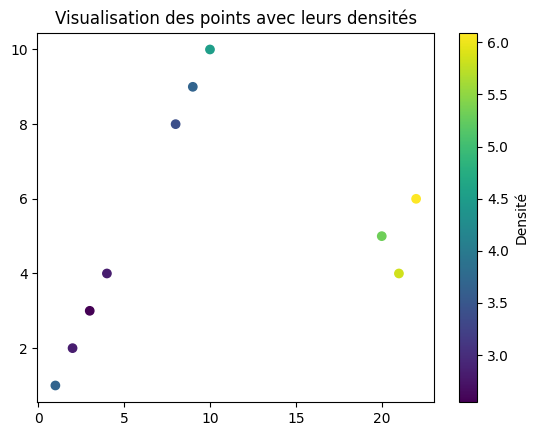

In [163]:
import numpy as np
import matplotlib.pyplot as plt

# Points dans un espace 2D (x, y)
X = np.array([
    [1, 1], [2, 2], [3, 3], [4, 4],  # Cluster dense (points proches)
    [8, 8], [9, 9], [10, 10],          # Cluster dense (points proches)
    [20, 5], [21, 4], [22, 6]          # Cluster faible densité (points éloignés)
])

# Calcul des distances entre chaque point
from sklearn.neighbors import NearestNeighbors

# Distance à 5 voisins
knn = NearestNeighbors(n_neighbors=5)
knn.fit(X)
distances, indices = knn.kneighbors(X)
print(distances, indices)

# Densité = moyenne des distances aux 5 plus proches voisins
densities = distances.mean(axis=1)
print(densities)
# Visualisation des clusters et de la densité
plt.scatter(X[:, 0], X[:, 1], c=densities, cmap='viridis')
plt.colorbar(label='Densité')
plt.title('Visualisation des points avec leurs densités')
plt.show()


In [182]:

labeled_ratio=0.03 # Nombre d'échantillons labellisés initialement
test_ratio = 0.2  # Proportion du dataset réservée au test
n_iterations = 25# Nombre d'itérations d'Active Learning
batch_ratio =0.02 # Taille du batch d'échantillons ajoutés à chaque itération
#methods=["random", "least_confident", "margin", "entropy","hybrid","qbc-variance","qbc-entropy","qbc-KL","distance_density"]
methods=["random","margin","distance_density"]
model_class=lambda : RandomForestClassifier()
# Créer un comité avec 3 modèles différents
# Liste de modèles pour le comité
models = [
    clone(RandomForestClassifier()),  # Random Forest
    clone(LogisticRegression(max_iter=1000)), # Régression Logistique
    clone(SVC(probability=True)),      # Régression Ridge pour classificati)           # Analyse discriminante quadratique
]
datasets={"MNIST":(X_MNIST,y_MNIST)}
#datasets={"MNIST":(X_MNIST,y_MNIST),"PRS":(X_PRS,y_PRS),"Foot":(X_foot,y_foot)}
# Exécution de l'expérience
run_active_learning_experiment_datasets(datasets, labeled_ratio, test_ratio, n_iterations, batch_ratio, methods, model_class, models)


Traitement du dataset: MNIST
Taille totale du dataset MNIST: 100.00% (10000/10000)
Taille de l'ensemble de test: 20.00% (2000/10000)
Taille de l'ensemble de training: 80.00% (8000/10000)
Taille de l'ensemble labellisé dans le training set: 3.75% (300/8000)
Taille de l'ensemble non-labellisé dans le training set: 96.25% (7700/8000)
Nb d'itérations: 25
Nb de données labellisées en plus à chaque itération: 2.00% (160/8000)
random - Iteration 1: 5.75% (460/8000) samples labeled, Accuracy: 0.8190 on MNIST
random - Iteration 2: 7.75% (620/8000) samples labeled, Accuracy: 0.8505 on MNIST
random - Iteration 3: 9.75% (780/8000) samples labeled, Accuracy: 0.8725 on MNIST
random - Iteration 4: 11.75% (940/8000) samples labeled, Accuracy: 0.8865 on MNIST
random - Iteration 5: 13.75% (1100/8000) samples labeled, Accuracy: 0.8875 on MNIST
random - Iteration 6: 15.75% (1260/8000) samples labeled, Accuracy: 0.9000 on MNIST
random - Iteration 7: 17.75% (1420/8000) samples labeled, Accuracy: 0.9035 on 

Initial Accuracy on MNIST: 0.8165
Full Training Set Accuracy on MNIST: 0.9500
Accuracy Improvement (random) on MNIST: 0.1195
Accuracy Improvement (margin) on MNIST: 0.1395
Accuracy Improvement (distance_density) on MNIST: 0.1190


{'MNIST': {'random': 0.936, 'margin': 0.956, 'distance_density': 0.9355}}